In [1]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
sys.path.append("..")
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from models import autoencoderV6
from utils.data_preprocessing import encode_sequences, MinMaxScaler3D, shuffle_array
from utils.parsers import parse_bulkiness, parse_hydrophobicity, parse_csv, load_kabat, aa_order, aa3_aa1
from utils.defines import VL_LENGTH, VH_LENGTH


Using TensorFlow backend.
W0417 09:47:10.081524 140033378449216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:360: The name name_scope is deprecated. Please use compat.v1.name_scope instead.



In [2]:
class AminoAcidEncoder:
    def __init__(self, max_length, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.aa_order = list(map(lambda x: aa3_aa1[x], aa_order))
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = np.zeros((len(X), self.max_length, len(aa_order)+1))
        for i in range(len(X)):
            for j in range(len(X[i])):
                try:
                    result[i, j, self.aa_order.index(X[i][j])] = 1
                except:
                    result[i, j, len(aa_order)] = 1
        return result

    def inverse_transform(self, X, y=None):
        result = list()
        for i in range(X.shape[0]):
            result_i=list()
            for j in range(self.max_length):
                idx = np.where(X[i,j]==1)[0]
                if idx.size != 0:
                    idx = int(idx)
                    if idx < len(self.aa_order):
                        result_i.append(self.aa_order[idx])
                    else:
                        result_i.append('')
            print(i, ''.join(result_i))
            result.append(''.join(result_i))
        return result

In [3]:
VL_sequences, VH_sequences, names_mask, animals_mask = \
    parse_csv(VH_LENGTH, VL_LENGTH,
              "../data/abysis_data_201801/abysis_data/emblig-20180125-7578.csv",
              "../data/abysis_data_201801/abysis_data/kabat-20180117-10288.csv")

VH_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_sequences)
VL_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_sequences)

VH_encoded_shuffled, VL_encoded_shuffled = shuffle_array(VH_encoded, VL_encoded)

In [4]:
encoder, autoencoder, sess = autoencoderV6(21, latent_dim=50, cuda_device=1, RNN_cell='LSTM')

W0417 09:47:16.913008 140033378449216 deprecation_wrapper.py:76] From ../models/RNN_autoencoder6.py:24: The name ConfigProto is deprecated. Please use compat.v1.ConfigProto instead.

W0417 09:47:16.916169 140033378449216 deprecation_wrapper.py:76] From ../models/RNN_autoencoder6.py:25: The name Session is deprecated. Please use compat.v1.Session instead.

W0417 09:47:17.030238 140033378449216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name placeholder is deprecated. Please use compat.v1.placeholder instead.

W0417 09:47:17.463572 140033378449216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name random_uniform is deprecated. Please use random.uniform instead.

W0417 09:47:17.823570 140033378449216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name train.Optimizer i

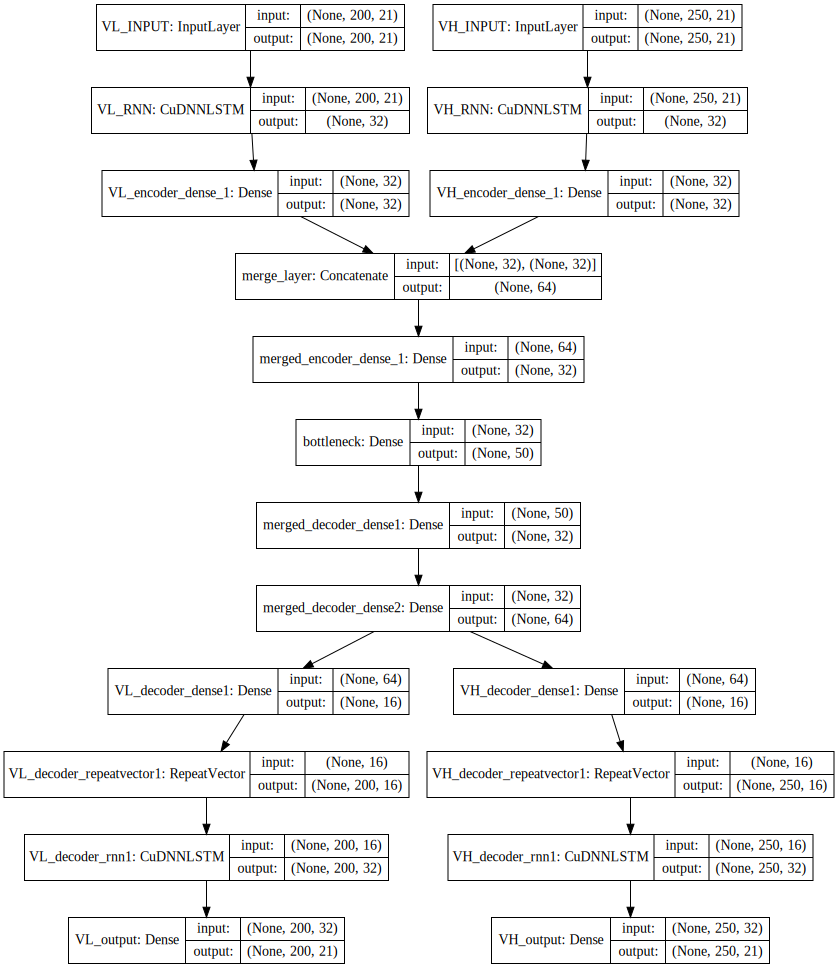

In [5]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VL_INPUT (InputLayer)           (None, 200, 21)      0                                            
__________________________________________________________________________________________________
VH_INPUT (InputLayer)           (None, 250, 21)      0                                            
__________________________________________________________________________________________________
VL_RNN (CuDNNLSTM)              (None, 32)           7040        VL_INPUT[0][0]                   
__________________________________________________________________________________________________
VH_RNN (CuDNNLSTM)              (None, 32)           7040        VH_INPUT[0][0]                   
__________________________________________________________________________________________________
VL_encoder

In [7]:
NAME= 'autoencoderV6_raw_lstm'
RUN = 'run1'

weight_path = '../model_weights/{}/{}/{}.hdf5'.format(NAME,RUN,NAME)
log_path = '../logs/{}/{}'.format(NAME, RUN)

In [8]:
if not os.path.exists('../model_weights/{}/{}/'.format(NAME,RUN)):
    if not os.path.exists('../model_weights/{}'.format(NAME)):
        os.mkdir('../model_weights/{}'.format(NAME))
    os.mkdir('../model_weights/{}/{}'.format(NAME,RUN))

In [9]:
from keras import backend as K

In [10]:
def get_loss(mask_value):

    """

    :param mask_value:
    :return:
    """

    mask_value = K.constant(mask_value, dtype=K.floatx())

    def masked_entropy(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = 1 - K.cast(mask, K.floatx())
        mask_sum = K.sum(mask)
        l=K.tf.contrib.seq2seq.sequence_loss(targets=K.argmax(y_true), logits=y_pred, weights=mask,
                                     average_across_batch=False, average_across_timesteps=False)
        return K.sum(l) / mask_sum
    return masked_entropy
    
lhs=K.placeholder((None,200,21))
rhs=K.placeholder((None,200,21))

func=get_loss(0)(lhs, rhs)
r=sess.run(func, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: VL_encoded_shuffled[:1]})

In [11]:
# lhs=K.placeholder((None,None, 2))
# rhs=K.placeholder((None, 2), dtype=K.tf.int32)
# mask = K.all(K.equal(rhs,  K.constant(0, dtype=K.tf.int32)), axis=-1)
# mask = K.tran\spose(K.reshape(K.tile(1 - K.cast(mask, K.floatx()),2), [2,-1]))
# l=K.tf.contrib.seq2seq.sequence_loss(targets=rhs, logits=lhs, weights=mask,
#                                      average_across_batch=False, average_across_timesteps=False)
# # VL_encoded_shuffled[:1][VL_encoded_shuffled[:1]==0.99]=1
# # VL_encoded_shuffled[:1][VL_encoded_shuffled[:1]==0.001]=0
# # a=np.expand_dims(np.array(VL_encoded_shuffled[0]),axis=0)
# # a[a[:1]==1]=0.99
# # a[a[:1]==0]=0.0001
# # K.get_session().run(l, feed_dict={lhs: VL_encoded_shuffled[:1], rhs: a})
# K.get_session().run(l, feed_dict={lhs: np.array([[[0, 9999],[9999, 0]], 
#                                                  [[0, 9999],[9999, 0]],
#                                                  [[0, 9999],[9999, 0]]]), 
#                                   rhs: np.array([[1, 0], [1, 0], [0, 0]])})

In [12]:
def acc(y_true, y_pred):
    mask = K.all(K.equal(y_true, 0), axis=-1)
    mask = 1 - K.cast(mask, K.floatx())
    mask_sum = K.sum(mask)
    acc = K.cast(K.equal(K.argmax(y_true), K.argmax(K.softmax(y_pred))), dtype=K.floatx()) * mask
    return K.sum(acc) / mask_sum

In [13]:
sess.run(acc(VL_encoded_shuffled[:1], VL_encoded_shuffled[:1]))

1.0

In [14]:
autoencoder.compile(optimizer=keras.optimizers.Adamax(), loss=get_loss(0), metrics=[acc])

In [15]:
class CosineAnnealingAdaptiveLRScheduler(keras.callbacks.Callback):

    """
    Keras adaptive learning scheduler implementation of cosine annealing
    that resets every cycle. A cycle unit is defined as the number of
    batches per epoch. The cycle can then be adjusted by a scalar after
    each cycle ending
    """

    def __init__(self, lr=None, cycle_len=1, cycle_mult=2):

        """
        CosineAnnealingAdaptiveLRScheduler constructor.
        Args:
            lr: base learning rate. If set to None it will be inferred from the model optimiser.
            cycle_len: initial cycle length. If set to 1 it will be equivalent to the number of batches per epoch
            cycle_mult: scalar to adjust cycle length at the end of each epoch
        """

        super(CosineAnnealingAdaptiveLRScheduler, self).__init__()

        self.lr = lr
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.iteration = 0
        self.steps_per_epoch = None
        self.current_cycle_iterations = None

    def on_batch_begin(self, epoch, logs=None):

        """
        Callback to adjust the learning rate at the start of each batch
        Args:
            epoch:
            logs:
        Returns:
        """

        if self.current_cycle_iterations < self.iteration:
            # update cycle length
            self.cycle_len *= self.cycle_mult
            self.current_cycle_iterations = self._get_iter_per_cycle()
            # reset state to start new cycle
            self._reset()

        # cosine annealing -> the self.current_cycle_iterations+1 avoids cos(pi) which is 0
        new_lr = (np.cos(self.iteration / (self.current_cycle_iterations + 1) * np.pi) + 1) * self.lr

        K.set_value(self.model.optimizer.lr, new_lr)

#         print('\nIteration {}/{}: {}\n'.format(self.iteration, self.current_cycle_iterations, new_lr))

        self.iteration += 1

    def _get_iter_per_cycle(self):
        """
        Calculate the number of iterations in current cycle
        Returns:
        """
        return self.steps_per_epoch * self.cycle_len

    # adapted from https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def on_train_begin(self, logs=None):
        """
        Sets some attributes that can only be inferred at model runtime.
        Args:
            logs:
        Returns:
        """
        if self.lr is None:
            self.lr = K.get_value(self.model.optimizer.lr)
        self.steps_per_epoch = self._autodetect_steps_per_epoch()
        self.current_cycle_iterations = self.steps_per_epoch * self.cycle_len

        # compensates for cosine annealing -> could divide by 2 at each step, or just do it here
        self.lr /= 2

    # https://github.com/uber/horovod/blob/master/horovod/keras/callbacks.py
    def _autodetect_steps_per_epoch(self):
        """
        Determine the number of steps per epoch.
        Returns:
        """
        if self.params.get('steps'):
            # The number of steps is provided in the parameters.
            return self.params['steps']
        elif self.params.get('samples') and self.params.get('batch_size'):
            # Compute the number of steps per epoch using # of samples and a batch size.
            return self.params['samples'] // self.params['batch_size']
        else:
            raise ValueError('Could not autodetect the number of steps per epoch. '
                             'Please specify the steps_per_epoch parameter to the '
                             '%s() or upgrade to the latest version of Keras.'
                             % self.__class__.__name__)

    def _reset(self):
        """
        Reset the state of the learning rate to start a new cycle.
        Returns:
        """
        self.iteration = 0

In [16]:
history = autoencoder.fit([VL_encoded_shuffled, VH_encoded_shuffled], [VL_encoded_shuffled, VH_encoded_shuffled],
                          epochs=5000, batch_size=32, validation_split=0.2,
                          callbacks=[CosineAnnealingAdaptiveLRScheduler(lr=0.01, cycle_len=2, cycle_mult=2),
                                     keras.callbacks.ModelCheckpoint(weight_path, save_best_only=True),
                                     keras.callbacks.TensorBoard(log_path)])

Train on 4144 samples, validate on 1036 samples


W0417 09:47:20.001149 140033378449216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name summary.merge_all is deprecated. Please use compat.v1.summary.merge_all instead.

W0417 09:47:20.001631 140033378449216 deprecation_wrapper.py:76] From /home/gil/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name summary.FileWriter is deprecated. Please use compat.v1.summary.FileWriter instead.



Epoch 1/5000
4144/4144 [==============================] - 6s 1ms/step - loss: 5.5828 - VL_output_loss: 2.7720 - VH_output_loss: 2.8108 - VL_output_acc: 0.1453 - VH_output_acc: 0.1281 - val_loss: 5.4569 - val_VL_output_loss: 2.7067 - val_VH_output_loss: 2.7502 - val_VL_output_acc: 0.1502 - val_VH_output_acc: 0.1430
Epoch 2/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.4131 - VL_output_loss: 2.6877 - VH_output_loss: 2.7255 - VL_output_acc: 0.1610 - VH_output_acc: 0.1489 - val_loss: 5.5286 - val_VL_output_loss: 2.7342 - val_VH_output_loss: 2.7944 - val_VL_output_acc: 0.1559 - val_VH_output_acc: 0.1283
Epoch 3/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.3381 - VL_output_loss: 2.6552 - VH_output_loss: 2.6829 - VL_output_acc: 0.1732 - VH_output_acc: 0.1551 - val_loss: 5.2592 - val_VL_output_loss: 2.6211 - val_VH_output_loss: 2.6380 - val_VL_output_acc: 0.1831 - val_VH_output_acc: 0.1623
Epoch 4/5000
4144/4144 [============================

Epoch 27/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8800 - VL_output_loss: 2.4589 - VH_output_loss: 2.4211 - VL_output_acc: 0.2380 - VH_output_acc: 0.2787 - val_loss: 4.9020 - val_VL_output_loss: 2.4850 - val_VH_output_loss: 2.4170 - val_VL_output_acc: 0.2308 - val_VH_output_acc: 0.2786
Epoch 28/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8752 - VL_output_loss: 2.4563 - VH_output_loss: 2.4189 - VL_output_acc: 0.2387 - VH_output_acc: 0.2782 - val_loss: 4.8988 - val_VL_output_loss: 2.4848 - val_VH_output_loss: 2.4141 - val_VL_output_acc: 0.2314 - val_VH_output_acc: 0.2797
Epoch 29/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8726 - VL_output_loss: 2.4555 - VH_output_loss: 2.4171 - VL_output_acc: 0.2390 - VH_output_acc: 0.2791 - val_loss: 4.8991 - val_VL_output_loss: 2.4851 - val_VH_output_loss: 2.4140 - val_VL_output_acc: 0.2293 - val_VH_output_acc: 0.2773
Epoch 30/5000
4144/4144 [========================

Epoch 53/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7609 - VL_output_loss: 2.4034 - VH_output_loss: 2.3575 - VL_output_acc: 0.2626 - VH_output_acc: 0.3021 - val_loss: 4.7896 - val_VL_output_loss: 2.4359 - val_VH_output_loss: 2.3537 - val_VL_output_acc: 0.2554 - val_VH_output_acc: 0.3069
Epoch 54/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7581 - VL_output_loss: 2.4009 - VH_output_loss: 2.3572 - VL_output_acc: 0.2641 - VH_output_acc: 0.3025 - val_loss: 4.7893 - val_VL_output_loss: 2.4349 - val_VH_output_loss: 2.3544 - val_VL_output_acc: 0.2521 - val_VH_output_acc: 0.3054
Epoch 55/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7569 - VL_output_loss: 2.4009 - VH_output_loss: 2.3560 - VL_output_acc: 0.2636 - VH_output_acc: 0.3035 - val_loss: 4.7865 - val_VL_output_loss: 2.4343 - val_VH_output_loss: 2.3522 - val_VL_output_acc: 0.2572 - val_VH_output_acc: 0.3064
Epoch 56/5000
4144/4144 [========================

Epoch 79/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7040 - VL_output_loss: 2.3717 - VH_output_loss: 2.3322 - VL_output_acc: 0.2772 - VH_output_acc: 0.3135 - val_loss: 4.7426 - val_VL_output_loss: 2.4140 - val_VH_output_loss: 2.3286 - val_VL_output_acc: 0.2602 - val_VH_output_acc: 0.3171
Epoch 80/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7099 - VL_output_loss: 2.3723 - VH_output_loss: 2.3375 - VL_output_acc: 0.2766 - VH_output_acc: 0.3088 - val_loss: 4.7387 - val_VL_output_loss: 2.4073 - val_VH_output_loss: 2.3314 - val_VL_output_acc: 0.2635 - val_VH_output_acc: 0.3131
Epoch 81/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7021 - VL_output_loss: 2.3685 - VH_output_loss: 2.3336 - VL_output_acc: 0.2789 - VH_output_acc: 0.3108 - val_loss: 4.7435 - val_VL_output_loss: 2.4137 - val_VH_output_loss: 2.3298 - val_VL_output_acc: 0.2599 - val_VH_output_acc: 0.3149
Epoch 82/5000
4144/4144 [========================

Epoch 105/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6641 - VL_output_loss: 2.3521 - VH_output_loss: 2.3120 - VL_output_acc: 0.2845 - VH_output_acc: 0.3222 - val_loss: 4.7000 - val_VL_output_loss: 2.3902 - val_VH_output_loss: 2.3098 - val_VL_output_acc: 0.2719 - val_VH_output_acc: 0.3275
Epoch 106/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6649 - VL_output_loss: 2.3533 - VH_output_loss: 2.3116 - VL_output_acc: 0.2837 - VH_output_acc: 0.3230 - val_loss: 4.7027 - val_VL_output_loss: 2.3902 - val_VH_output_loss: 2.3125 - val_VL_output_acc: 0.2702 - val_VH_output_acc: 0.3245
Epoch 107/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6632 - VL_output_loss: 2.3512 - VH_output_loss: 2.3120 - VL_output_acc: 0.2846 - VH_output_acc: 0.3222 - val_loss: 4.7013 - val_VL_output_loss: 2.3894 - val_VH_output_loss: 2.3120 - val_VL_output_acc: 0.2739 - val_VH_output_acc: 0.3183
Epoch 108/5000
4144/4144 [====================

Epoch 131/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6636 - VL_output_loss: 2.3526 - VH_output_loss: 2.3110 - VL_output_acc: 0.2832 - VH_output_acc: 0.3227 - val_loss: 4.7064 - val_VL_output_loss: 2.3993 - val_VH_output_loss: 2.3072 - val_VL_output_acc: 0.2612 - val_VH_output_acc: 0.3265
Epoch 132/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6652 - VL_output_loss: 2.3547 - VH_output_loss: 2.3105 - VL_output_acc: 0.2825 - VH_output_acc: 0.3228 - val_loss: 4.9081 - val_VL_output_loss: 2.6020 - val_VH_output_loss: 2.3061 - val_VL_output_acc: 0.1923 - val_VH_output_acc: 0.3279
Epoch 133/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6643 - VL_output_loss: 2.3528 - VH_output_loss: 2.3114 - VL_output_acc: 0.2831 - VH_output_acc: 0.3211 - val_loss: 4.6964 - val_VL_output_loss: 2.3882 - val_VH_output_loss: 2.3082 - val_VL_output_acc: 0.2696 - val_VH_output_acc: 0.3206
Epoch 134/5000
4144/4144 [====================

Epoch 157/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0703 - VL_output_loss: 2.3435 - VH_output_loss: 2.7268 - VL_output_acc: 0.2872 - VH_output_acc: 0.1680 - val_loss: 5.1003 - val_VL_output_loss: 2.3860 - val_VH_output_loss: 2.7143 - val_VL_output_acc: 0.2719 - val_VH_output_acc: 0.1769
Epoch 158/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0560 - VL_output_loss: 2.3455 - VH_output_loss: 2.7106 - VL_output_acc: 0.2860 - VH_output_acc: 0.1728 - val_loss: 5.0992 - val_VL_output_loss: 2.4019 - val_VH_output_loss: 2.6972 - val_VL_output_acc: 0.2564 - val_VH_output_acc: 0.1761
Epoch 159/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0362 - VL_output_loss: 2.3434 - VH_output_loss: 2.6929 - VL_output_acc: 0.2872 - VH_output_acc: 0.1764 - val_loss: 5.0574 - val_VL_output_loss: 2.3810 - val_VH_output_loss: 2.6764 - val_VL_output_acc: 0.2738 - val_VH_output_acc: 0.1886
Epoch 160/5000
4144/4144 [====================

Epoch 183/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7781 - VL_output_loss: 2.3351 - VH_output_loss: 2.4431 - VL_output_acc: 0.2892 - VH_output_acc: 0.2713 - val_loss: 4.8155 - val_VL_output_loss: 2.3744 - val_VH_output_loss: 2.4410 - val_VL_output_acc: 0.2742 - val_VH_output_acc: 0.2796
Epoch 184/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7738 - VL_output_loss: 2.3343 - VH_output_loss: 2.4395 - VL_output_acc: 0.2896 - VH_output_acc: 0.2727 - val_loss: 4.8082 - val_VL_output_loss: 2.3732 - val_VH_output_loss: 2.4350 - val_VL_output_acc: 0.2759 - val_VH_output_acc: 0.2729
Epoch 185/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7749 - VL_output_loss: 2.3346 - VH_output_loss: 2.4404 - VL_output_acc: 0.2902 - VH_output_acc: 0.2714 - val_loss: 4.8031 - val_VL_output_loss: 2.3744 - val_VH_output_loss: 2.4287 - val_VL_output_acc: 0.2769 - val_VH_output_acc: 0.2784
Epoch 186/5000
4144/4144 [====================

Epoch 209/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7115 - VL_output_loss: 2.3289 - VH_output_loss: 2.3825 - VL_output_acc: 0.2913 - VH_output_acc: 0.2956 - val_loss: 4.7487 - val_VL_output_loss: 2.3692 - val_VH_output_loss: 2.3795 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.2990
Epoch 210/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7118 - VL_output_loss: 2.3286 - VH_output_loss: 2.3832 - VL_output_acc: 0.2911 - VH_output_acc: 0.2957 - val_loss: 4.7490 - val_VL_output_loss: 2.3689 - val_VH_output_loss: 2.3800 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.2989
Epoch 211/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7092 - VL_output_loss: 2.3281 - VH_output_loss: 2.3811 - VL_output_acc: 0.2915 - VH_output_acc: 0.2977 - val_loss: 4.7440 - val_VL_output_loss: 2.3688 - val_VH_output_loss: 2.3752 - val_VL_output_acc: 0.2768 - val_VH_output_acc: 0.3064
Epoch 212/5000
4144/4144 [====================

Epoch 235/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6881 - VL_output_loss: 2.3251 - VH_output_loss: 2.3631 - VL_output_acc: 0.2923 - VH_output_acc: 0.3124 - val_loss: 4.7264 - val_VL_output_loss: 2.3668 - val_VH_output_loss: 2.3596 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3160
Epoch 236/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6879 - VL_output_loss: 2.3252 - VH_output_loss: 2.3627 - VL_output_acc: 0.2923 - VH_output_acc: 0.3130 - val_loss: 4.7255 - val_VL_output_loss: 2.3668 - val_VH_output_loss: 2.3587 - val_VL_output_acc: 0.2779 - val_VH_output_acc: 0.3177
Epoch 237/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6866 - VL_output_loss: 2.3249 - VH_output_loss: 2.3617 - VL_output_acc: 0.2922 - VH_output_acc: 0.3130 - val_loss: 4.7249 - val_VL_output_loss: 2.3666 - val_VH_output_loss: 2.3582 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3187
Epoch 238/5000
4144/4144 [====================

Epoch 261/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8934 - VL_output_loss: 2.3272 - VH_output_loss: 2.5662 - VL_output_acc: 0.2913 - VH_output_acc: 0.2138 - val_loss: 4.9235 - val_VL_output_loss: 2.3674 - val_VH_output_loss: 2.5561 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.2222
Epoch 262/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8820 - VL_output_loss: 2.3266 - VH_output_loss: 2.5554 - VL_output_acc: 0.2914 - VH_output_acc: 0.2212 - val_loss: 4.9142 - val_VL_output_loss: 2.3676 - val_VH_output_loss: 2.5466 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.2252
Epoch 263/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8682 - VL_output_loss: 2.3267 - VH_output_loss: 2.5415 - VL_output_acc: 0.2915 - VH_output_acc: 0.2348 - val_loss: 4.8910 - val_VL_output_loss: 2.3686 - val_VH_output_loss: 2.5224 - val_VL_output_acc: 0.2779 - val_VH_output_acc: 0.2488
Epoch 264/5000
4144/4144 [====================

Epoch 287/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7526 - VL_output_loss: 2.3270 - VH_output_loss: 2.4256 - VL_output_acc: 0.2913 - VH_output_acc: 0.2730 - val_loss: 4.7939 - val_VL_output_loss: 2.3702 - val_VH_output_loss: 2.4238 - val_VL_output_acc: 0.2765 - val_VH_output_acc: 0.2752
Epoch 288/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7802 - VL_output_loss: 2.3560 - VH_output_loss: 2.4242 - VL_output_acc: 0.2790 - VH_output_acc: 0.2737 - val_loss: 4.8828 - val_VL_output_loss: 2.4582 - val_VH_output_loss: 2.4247 - val_VL_output_acc: 0.2433 - val_VH_output_acc: 0.2726
Epoch 289/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7684 - VL_output_loss: 2.3455 - VH_output_loss: 2.4229 - VL_output_acc: 0.2854 - VH_output_acc: 0.2742 - val_loss: 4.7859 - val_VL_output_loss: 2.3707 - val_VH_output_loss: 2.4152 - val_VL_output_acc: 0.2780 - val_VH_output_acc: 0.2820
Epoch 290/5000
4144/4144 [====================

Epoch 313/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6977 - VL_output_loss: 2.3243 - VH_output_loss: 2.3735 - VL_output_acc: 0.2921 - VH_output_acc: 0.2984 - val_loss: 4.7305 - val_VL_output_loss: 2.3654 - val_VH_output_loss: 2.3651 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3020
Epoch 314/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6942 - VL_output_loss: 2.3242 - VH_output_loss: 2.3700 - VL_output_acc: 0.2917 - VH_output_acc: 0.2993 - val_loss: 4.7355 - val_VL_output_loss: 2.3671 - val_VH_output_loss: 2.3684 - val_VL_output_acc: 0.2784 - val_VH_output_acc: 0.3006
Epoch 315/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6955 - VL_output_loss: 2.3241 - VH_output_loss: 2.3715 - VL_output_acc: 0.2919 - VH_output_acc: 0.2992 - val_loss: 4.7299 - val_VL_output_loss: 2.3670 - val_VH_output_loss: 2.3628 - val_VL_output_acc: 0.2772 - val_VH_output_acc: 0.3053
Epoch 316/5000
4144/4144 [====================

Epoch 339/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6715 - VL_output_loss: 2.3235 - VH_output_loss: 2.3480 - VL_output_acc: 0.2921 - VH_output_acc: 0.3110 - val_loss: 4.7056 - val_VL_output_loss: 2.3639 - val_VH_output_loss: 2.3417 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3147
Epoch 340/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6709 - VL_output_loss: 2.3237 - VH_output_loss: 2.3472 - VL_output_acc: 0.2920 - VH_output_acc: 0.3118 - val_loss: 4.7078 - val_VL_output_loss: 2.3644 - val_VH_output_loss: 2.3434 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3165
Epoch 341/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6731 - VL_output_loss: 2.3229 - VH_output_loss: 2.3502 - VL_output_acc: 0.2924 - VH_output_acc: 0.3108 - val_loss: 4.7562 - val_VL_output_loss: 2.3644 - val_VH_output_loss: 2.3918 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3015
Epoch 342/5000
4144/4144 [====================

Epoch 365/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6584 - VL_output_loss: 2.3225 - VH_output_loss: 2.3359 - VL_output_acc: 0.2920 - VH_output_acc: 0.3169 - val_loss: 4.6955 - val_VL_output_loss: 2.3640 - val_VH_output_loss: 2.3315 - val_VL_output_acc: 0.2777 - val_VH_output_acc: 0.3186
Epoch 366/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6588 - VL_output_loss: 2.3226 - VH_output_loss: 2.3362 - VL_output_acc: 0.2923 - VH_output_acc: 0.3171 - val_loss: 4.6952 - val_VL_output_loss: 2.3644 - val_VH_output_loss: 2.3308 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3200
Epoch 367/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6586 - VL_output_loss: 2.3223 - VH_output_loss: 2.3362 - VL_output_acc: 0.2924 - VH_output_acc: 0.3174 - val_loss: 4.6959 - val_VL_output_loss: 2.3650 - val_VH_output_loss: 2.3309 - val_VL_output_acc: 0.2784 - val_VH_output_acc: 0.3195
Epoch 368/5000
4144/4144 [====================

Epoch 391/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6475 - VL_output_loss: 2.3208 - VH_output_loss: 2.3267 - VL_output_acc: 0.2922 - VH_output_acc: 0.3223 - val_loss: 4.6859 - val_VL_output_loss: 2.3628 - val_VH_output_loss: 2.3231 - val_VL_output_acc: 0.2782 - val_VH_output_acc: 0.3220
Epoch 392/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6484 - VL_output_loss: 2.3213 - VH_output_loss: 2.3272 - VL_output_acc: 0.2922 - VH_output_acc: 0.3221 - val_loss: 4.6958 - val_VL_output_loss: 2.3629 - val_VH_output_loss: 2.3329 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3208
Epoch 393/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6496 - VL_output_loss: 2.3212 - VH_output_loss: 2.3284 - VL_output_acc: 0.2924 - VH_output_acc: 0.3214 - val_loss: 4.6890 - val_VL_output_loss: 2.3660 - val_VH_output_loss: 2.3230 - val_VL_output_acc: 0.2766 - val_VH_output_acc: 0.3257
Epoch 394/5000
4144/4144 [====================

Epoch 417/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6384 - VL_output_loss: 2.3183 - VH_output_loss: 2.3201 - VL_output_acc: 0.2929 - VH_output_acc: 0.3263 - val_loss: 4.6790 - val_VL_output_loss: 2.3621 - val_VH_output_loss: 2.3169 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.3302
Epoch 418/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6390 - VL_output_loss: 2.3184 - VH_output_loss: 2.3206 - VL_output_acc: 0.2926 - VH_output_acc: 0.3255 - val_loss: 4.6782 - val_VL_output_loss: 2.3601 - val_VH_output_loss: 2.3181 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.3303
Epoch 419/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6385 - VL_output_loss: 2.3184 - VH_output_loss: 2.3201 - VL_output_acc: 0.2929 - VH_output_acc: 0.3257 - val_loss: 4.6778 - val_VL_output_loss: 2.3609 - val_VH_output_loss: 2.3169 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3249
Epoch 420/5000
4144/4144 [====================

Epoch 443/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6357 - VL_output_loss: 2.3178 - VH_output_loss: 2.3179 - VL_output_acc: 0.2930 - VH_output_acc: 0.3269 - val_loss: 4.6736 - val_VL_output_loss: 2.3597 - val_VH_output_loss: 2.3139 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3302
Epoch 444/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6339 - VL_output_loss: 2.3170 - VH_output_loss: 2.3169 - VL_output_acc: 0.2930 - VH_output_acc: 0.3275 - val_loss: 4.6734 - val_VL_output_loss: 2.3600 - val_VH_output_loss: 2.3134 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.3306
Epoch 445/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6352 - VL_output_loss: 2.3176 - VH_output_loss: 2.3177 - VL_output_acc: 0.2928 - VH_output_acc: 0.3269 - val_loss: 4.6737 - val_VL_output_loss: 2.3599 - val_VH_output_loss: 2.3138 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3305
Epoch 446/5000
4144/4144 [====================

Epoch 469/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6319 - VL_output_loss: 2.3162 - VH_output_loss: 2.3156 - VL_output_acc: 0.2930 - VH_output_acc: 0.3272 - val_loss: 4.6715 - val_VL_output_loss: 2.3588 - val_VH_output_loss: 2.3127 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3292
Epoch 470/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6312 - VL_output_loss: 2.3159 - VH_output_loss: 2.3153 - VL_output_acc: 0.2931 - VH_output_acc: 0.3273 - val_loss: 4.6708 - val_VL_output_loss: 2.3587 - val_VH_output_loss: 2.3121 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3303
Epoch 471/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6297 - VL_output_loss: 2.3154 - VH_output_loss: 2.3143 - VL_output_acc: 0.2934 - VH_output_acc: 0.3277 - val_loss: 4.6705 - val_VL_output_loss: 2.3586 - val_VH_output_loss: 2.3119 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3299
Epoch 472/5000
4144/4144 [====================

Epoch 495/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6294 - VL_output_loss: 2.3154 - VH_output_loss: 2.3139 - VL_output_acc: 0.2932 - VH_output_acc: 0.3276 - val_loss: 4.6697 - val_VL_output_loss: 2.3586 - val_VH_output_loss: 2.3111 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3303
Epoch 496/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6293 - VL_output_loss: 2.3154 - VH_output_loss: 2.3139 - VL_output_acc: 0.2932 - VH_output_acc: 0.3275 - val_loss: 4.6695 - val_VL_output_loss: 2.3586 - val_VH_output_loss: 2.3109 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3302
Epoch 497/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6289 - VL_output_loss: 2.3153 - VH_output_loss: 2.3136 - VL_output_acc: 0.2932 - VH_output_acc: 0.3277 - val_loss: 4.6696 - val_VL_output_loss: 2.3586 - val_VH_output_loss: 2.3110 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3303
Epoch 498/5000
4144/4144 [====================

Epoch 521/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6405 - VL_output_loss: 2.3187 - VH_output_loss: 2.3219 - VL_output_acc: 0.2927 - VH_output_acc: 0.3246 - val_loss: 4.6770 - val_VL_output_loss: 2.3609 - val_VH_output_loss: 2.3161 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3263
Epoch 522/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6370 - VL_output_loss: 2.3182 - VH_output_loss: 2.3188 - VL_output_acc: 0.2926 - VH_output_acc: 0.3253 - val_loss: 4.6757 - val_VL_output_loss: 2.3606 - val_VH_output_loss: 2.3151 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.3294
Epoch 523/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6377 - VL_output_loss: 2.3188 - VH_output_loss: 2.3190 - VL_output_acc: 0.2922 - VH_output_acc: 0.3253 - val_loss: 4.6743 - val_VL_output_loss: 2.3604 - val_VH_output_loss: 2.3139 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3311
Epoch 524/5000
4144/4144 [====================

Epoch 547/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6288 - VL_output_loss: 2.3192 - VH_output_loss: 2.3095 - VL_output_acc: 0.2926 - VH_output_acc: 0.3272 - val_loss: 4.6657 - val_VL_output_loss: 2.3617 - val_VH_output_loss: 2.3040 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3317
Epoch 548/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6302 - VL_output_loss: 2.3206 - VH_output_loss: 2.3095 - VL_output_acc: 0.2920 - VH_output_acc: 0.3274 - val_loss: 4.6712 - val_VL_output_loss: 2.3601 - val_VH_output_loss: 2.3110 - val_VL_output_acc: 0.2781 - val_VH_output_acc: 0.3285
Epoch 549/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6291 - VL_output_loss: 2.3194 - VH_output_loss: 2.3097 - VL_output_acc: 0.2922 - VH_output_acc: 0.3274 - val_loss: 4.6667 - val_VL_output_loss: 2.3619 - val_VH_output_loss: 2.3048 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.3307
Epoch 550/5000
4144/4144 [====================

Epoch 573/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6229 - VL_output_loss: 2.3171 - VH_output_loss: 2.3058 - VL_output_acc: 0.2927 - VH_output_acc: 0.3272 - val_loss: 4.6577 - val_VL_output_loss: 2.3598 - val_VH_output_loss: 2.2979 - val_VL_output_acc: 0.2784 - val_VH_output_acc: 0.3320
Epoch 574/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6188 - VL_output_loss: 2.3174 - VH_output_loss: 2.3013 - VL_output_acc: 0.2926 - VH_output_acc: 0.3282 - val_loss: 4.6549 - val_VL_output_loss: 2.3595 - val_VH_output_loss: 2.2954 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3316
Epoch 575/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6189 - VL_output_loss: 2.3178 - VH_output_loss: 2.3011 - VL_output_acc: 0.2928 - VH_output_acc: 0.3281 - val_loss: 4.6553 - val_VL_output_loss: 2.3600 - val_VH_output_loss: 2.2952 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.3327
Epoch 576/5000
4144/4144 [====================

Epoch 599/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7544 - VL_output_loss: 2.3166 - VH_output_loss: 2.4378 - VL_output_acc: 0.2929 - VH_output_acc: 0.2837 - val_loss: 4.7890 - val_VL_output_loss: 2.3598 - val_VH_output_loss: 2.4292 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.2871
Epoch 600/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7481 - VL_output_loss: 2.3164 - VH_output_loss: 2.4317 - VL_output_acc: 0.2930 - VH_output_acc: 0.2864 - val_loss: 4.7858 - val_VL_output_loss: 2.3603 - val_VH_output_loss: 2.4255 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.2957
Epoch 601/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7425 - VL_output_loss: 2.3164 - VH_output_loss: 2.4261 - VL_output_acc: 0.2931 - VH_output_acc: 0.2909 - val_loss: 4.7767 - val_VL_output_loss: 2.3583 - val_VH_output_loss: 2.4184 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.2905
Epoch 602/5000
4144/4144 [====================

Epoch 625/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.1010 - VL_output_loss: 2.3190 - VH_output_loss: 2.7819 - VL_output_acc: 0.2922 - VH_output_acc: 0.1524 - val_loss: 5.1798 - val_VL_output_loss: 2.3595 - val_VH_output_loss: 2.8203 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.1288
Epoch 626/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.1022 - VL_output_loss: 2.3176 - VH_output_loss: 2.7846 - VL_output_acc: 0.2927 - VH_output_acc: 0.1429 - val_loss: 5.1228 - val_VL_output_loss: 2.3629 - val_VH_output_loss: 2.7599 - val_VL_output_acc: 0.2779 - val_VH_output_acc: 0.1533
Epoch 627/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0667 - VL_output_loss: 2.3185 - VH_output_loss: 2.7482 - VL_output_acc: 0.2920 - VH_output_acc: 0.1524 - val_loss: 5.0944 - val_VL_output_loss: 2.3604 - val_VH_output_loss: 2.7339 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.1682
Epoch 628/5000
4144/4144 [====================

Epoch 651/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0339 - VL_output_loss: 2.3177 - VH_output_loss: 2.7162 - VL_output_acc: 0.2923 - VH_output_acc: 0.1650 - val_loss: 5.0714 - val_VL_output_loss: 2.3596 - val_VH_output_loss: 2.7118 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.1596
Epoch 652/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.9934 - VL_output_loss: 2.3177 - VH_output_loss: 2.6757 - VL_output_acc: 0.2924 - VH_output_acc: 0.1744 - val_loss: 5.0062 - val_VL_output_loss: 2.3593 - val_VH_output_loss: 2.6469 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.1942
Epoch 653/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.9679 - VL_output_loss: 2.3169 - VH_output_loss: 2.6509 - VL_output_acc: 0.2927 - VH_output_acc: 0.1836 - val_loss: 5.0292 - val_VL_output_loss: 2.3610 - val_VH_output_loss: 2.6682 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.1809
Epoch 654/5000
4144/4144 [====================

Epoch 677/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7374 - VL_output_loss: 2.3166 - VH_output_loss: 2.4208 - VL_output_acc: 0.2926 - VH_output_acc: 0.2842 - val_loss: 4.7749 - val_VL_output_loss: 2.3601 - val_VH_output_loss: 2.4147 - val_VL_output_acc: 0.2775 - val_VH_output_acc: 0.2867
Epoch 678/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7335 - VL_output_loss: 2.3168 - VH_output_loss: 2.4168 - VL_output_acc: 0.2923 - VH_output_acc: 0.2875 - val_loss: 4.7650 - val_VL_output_loss: 2.3576 - val_VH_output_loss: 2.4074 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.2937
Epoch 679/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7253 - VL_output_loss: 2.3161 - VH_output_loss: 2.4092 - VL_output_acc: 0.2926 - VH_output_acc: 0.2908 - val_loss: 4.7618 - val_VL_output_loss: 2.3583 - val_VH_output_loss: 2.4035 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.2937
Epoch 680/5000
4144/4144 [====================

Epoch 703/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7731 - VL_output_loss: 2.3175 - VH_output_loss: 2.4556 - VL_output_acc: 0.2928 - VH_output_acc: 0.2757 - val_loss: 4.8126 - val_VL_output_loss: 2.3602 - val_VH_output_loss: 2.4525 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.2760
Epoch 704/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7659 - VL_output_loss: 2.3162 - VH_output_loss: 2.4496 - VL_output_acc: 0.2929 - VH_output_acc: 0.2774 - val_loss: 4.8025 - val_VL_output_loss: 2.3597 - val_VH_output_loss: 2.4428 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.2784
Epoch 705/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7651 - VL_output_loss: 2.3163 - VH_output_loss: 2.4488 - VL_output_acc: 0.2928 - VH_output_acc: 0.2756 - val_loss: 4.8001 - val_VL_output_loss: 2.3594 - val_VH_output_loss: 2.4407 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.2863
Epoch 706/5000
4144/4144 [====================

Epoch 729/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6888 - VL_output_loss: 2.3138 - VH_output_loss: 2.3750 - VL_output_acc: 0.2934 - VH_output_acc: 0.3001 - val_loss: 4.7252 - val_VL_output_loss: 2.3573 - val_VH_output_loss: 2.3679 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.3025
Epoch 730/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6868 - VL_output_loss: 2.3140 - VH_output_loss: 2.3728 - VL_output_acc: 0.2930 - VH_output_acc: 0.2999 - val_loss: 4.7275 - val_VL_output_loss: 2.3573 - val_VH_output_loss: 2.3701 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.2976
Epoch 731/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6862 - VL_output_loss: 2.3144 - VH_output_loss: 2.3718 - VL_output_acc: 0.2931 - VH_output_acc: 0.3006 - val_loss: 4.7224 - val_VL_output_loss: 2.3567 - val_VH_output_loss: 2.3658 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.3007
Epoch 732/5000
4144/4144 [====================

Epoch 755/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6511 - VL_output_loss: 2.3136 - VH_output_loss: 2.3375 - VL_output_acc: 0.2934 - VH_output_acc: 0.3183 - val_loss: 4.6901 - val_VL_output_loss: 2.3570 - val_VH_output_loss: 2.3331 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3186
Epoch 756/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6518 - VL_output_loss: 2.3140 - VH_output_loss: 2.3378 - VL_output_acc: 0.2930 - VH_output_acc: 0.3186 - val_loss: 4.6896 - val_VL_output_loss: 2.3574 - val_VH_output_loss: 2.3322 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3238
Epoch 757/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6508 - VL_output_loss: 2.3148 - VH_output_loss: 2.3360 - VL_output_acc: 0.2926 - VH_output_acc: 0.3201 - val_loss: 4.6897 - val_VL_output_loss: 2.3571 - val_VH_output_loss: 2.3326 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3169
Epoch 758/5000
4144/4144 [====================

Epoch 781/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6411 - VL_output_loss: 2.3138 - VH_output_loss: 2.3273 - VL_output_acc: 0.2930 - VH_output_acc: 0.3229 - val_loss: 4.6773 - val_VL_output_loss: 2.3571 - val_VH_output_loss: 2.3202 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3275
Epoch 782/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6370 - VL_output_loss: 2.3146 - VH_output_loss: 2.3224 - VL_output_acc: 0.2931 - VH_output_acc: 0.3241 - val_loss: 4.6735 - val_VL_output_loss: 2.3560 - val_VH_output_loss: 2.3175 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3262
Epoch 783/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6346 - VL_output_loss: 2.3138 - VH_output_loss: 2.3208 - VL_output_acc: 0.2931 - VH_output_acc: 0.3240 - val_loss: 4.6719 - val_VL_output_loss: 2.3552 - val_VH_output_loss: 2.3167 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3277
Epoch 784/5000
4144/4144 [====================

Epoch 807/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6275 - VL_output_loss: 2.3131 - VH_output_loss: 2.3143 - VL_output_acc: 0.2932 - VH_output_acc: 0.3261 - val_loss: 4.6655 - val_VL_output_loss: 2.3553 - val_VH_output_loss: 2.3103 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3309
Epoch 808/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6270 - VL_output_loss: 2.3130 - VH_output_loss: 2.3140 - VL_output_acc: 0.2932 - VH_output_acc: 0.3261 - val_loss: 4.6675 - val_VL_output_loss: 2.3574 - val_VH_output_loss: 2.3101 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3298
Epoch 809/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6278 - VL_output_loss: 2.3136 - VH_output_loss: 2.3142 - VL_output_acc: 0.2931 - VH_output_acc: 0.3263 - val_loss: 4.6658 - val_VL_output_loss: 2.3563 - val_VH_output_loss: 2.3095 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3281
Epoch 810/5000
4144/4144 [====================

Epoch 833/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6207 - VL_output_loss: 2.3128 - VH_output_loss: 2.3079 - VL_output_acc: 0.2935 - VH_output_acc: 0.3289 - val_loss: 4.6585 - val_VL_output_loss: 2.3561 - val_VH_output_loss: 2.3024 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3325
Epoch 834/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6190 - VL_output_loss: 2.3129 - VH_output_loss: 2.3061 - VL_output_acc: 0.2933 - VH_output_acc: 0.3292 - val_loss: 4.6581 - val_VL_output_loss: 2.3561 - val_VH_output_loss: 2.3020 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3313
Epoch 835/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6192 - VL_output_loss: 2.3127 - VH_output_loss: 2.3065 - VL_output_acc: 0.2931 - VH_output_acc: 0.3287 - val_loss: 4.6576 - val_VL_output_loss: 2.3560 - val_VH_output_loss: 2.3016 - val_VL_output_acc: 0.2796 - val_VH_output_acc: 0.3315
Epoch 836/5000
4144/4144 [====================

Epoch 859/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6141 - VL_output_loss: 2.3119 - VH_output_loss: 2.3022 - VL_output_acc: 0.2932 - VH_output_acc: 0.3289 - val_loss: 4.6541 - val_VL_output_loss: 2.3556 - val_VH_output_loss: 2.2984 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3324
Epoch 860/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6146 - VL_output_loss: 2.3121 - VH_output_loss: 2.3024 - VL_output_acc: 0.2933 - VH_output_acc: 0.3288 - val_loss: 4.6528 - val_VL_output_loss: 2.3551 - val_VH_output_loss: 2.2977 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.3325
Epoch 861/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6147 - VL_output_loss: 2.3120 - VH_output_loss: 2.3027 - VL_output_acc: 0.2933 - VH_output_acc: 0.3290 - val_loss: 4.6542 - val_VL_output_loss: 2.3552 - val_VH_output_loss: 2.2990 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3315
Epoch 862/5000
4144/4144 [====================

Epoch 885/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6120 - VL_output_loss: 2.3120 - VH_output_loss: 2.3000 - VL_output_acc: 0.2934 - VH_output_acc: 0.3290 - val_loss: 4.6498 - val_VL_output_loss: 2.3547 - val_VH_output_loss: 2.2951 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.3316
Epoch 886/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6104 - VL_output_loss: 2.3117 - VH_output_loss: 2.2987 - VL_output_acc: 0.2933 - VH_output_acc: 0.3294 - val_loss: 4.6498 - val_VL_output_loss: 2.3546 - val_VH_output_loss: 2.2953 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.3323
Epoch 887/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6105 - VL_output_loss: 2.3115 - VH_output_loss: 2.2990 - VL_output_acc: 0.2935 - VH_output_acc: 0.3294 - val_loss: 4.6501 - val_VL_output_loss: 2.3548 - val_VH_output_loss: 2.2953 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3312
Epoch 888/5000
4144/4144 [====================

Epoch 911/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6085 - VL_output_loss: 2.3118 - VH_output_loss: 2.2966 - VL_output_acc: 0.2936 - VH_output_acc: 0.3293 - val_loss: 4.6479 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2925 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3315
Epoch 912/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6082 - VL_output_loss: 2.3115 - VH_output_loss: 2.2967 - VL_output_acc: 0.2935 - VH_output_acc: 0.3294 - val_loss: 4.6481 - val_VL_output_loss: 2.3553 - val_VH_output_loss: 2.2929 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3325
Epoch 913/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6091 - VL_output_loss: 2.3121 - VH_output_loss: 2.2970 - VL_output_acc: 0.2935 - VH_output_acc: 0.3290 - val_loss: 4.6478 - val_VL_output_loss: 2.3552 - val_VH_output_loss: 2.2926 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.3325
Epoch 914/5000
4144/4144 [====================

Epoch 937/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6068 - VL_output_loss: 2.3114 - VH_output_loss: 2.2954 - VL_output_acc: 0.2936 - VH_output_acc: 0.3295 - val_loss: 4.6476 - val_VL_output_loss: 2.3556 - val_VH_output_loss: 2.2920 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.3322
Epoch 938/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6074 - VL_output_loss: 2.3114 - VH_output_loss: 2.2960 - VL_output_acc: 0.2936 - VH_output_acc: 0.3294 - val_loss: 4.6476 - val_VL_output_loss: 2.3556 - val_VH_output_loss: 2.2921 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.3328
Epoch 939/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6068 - VL_output_loss: 2.3111 - VH_output_loss: 2.2957 - VL_output_acc: 0.2936 - VH_output_acc: 0.3291 - val_loss: 4.6477 - val_VL_output_loss: 2.3556 - val_VH_output_loss: 2.2922 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3322
Epoch 940/5000
4144/4144 [====================

Epoch 963/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6067 - VL_output_loss: 2.3117 - VH_output_loss: 2.2951 - VL_output_acc: 0.2936 - VH_output_acc: 0.3294 - val_loss: 4.6470 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2916 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3325
Epoch 964/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6066 - VL_output_loss: 2.3114 - VH_output_loss: 2.2952 - VL_output_acc: 0.2937 - VH_output_acc: 0.3293 - val_loss: 4.6469 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2915 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3325
Epoch 965/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6062 - VL_output_loss: 2.3112 - VH_output_loss: 2.2951 - VL_output_acc: 0.2939 - VH_output_acc: 0.3292 - val_loss: 4.6471 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2916 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3322
Epoch 966/5000
4144/4144 [====================

Epoch 989/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6050 - VL_output_loss: 2.3111 - VH_output_loss: 2.2939 - VL_output_acc: 0.2938 - VH_output_acc: 0.3297 - val_loss: 4.6465 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2911 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3322
Epoch 990/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6060 - VL_output_loss: 2.3112 - VH_output_loss: 2.2948 - VL_output_acc: 0.2936 - VH_output_acc: 0.3294 - val_loss: 4.6466 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2912 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3322
Epoch 991/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6070 - VL_output_loss: 2.3115 - VH_output_loss: 2.2954 - VL_output_acc: 0.2936 - VH_output_acc: 0.3290 - val_loss: 4.6465 - val_VL_output_loss: 2.3554 - val_VH_output_loss: 2.2912 - val_VL_output_acc: 0.2793 - val_VH_output_acc: 0.3322
Epoch 992/5000
4144/4144 [====================

Epoch 1015/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7059 - VL_output_loss: 2.3156 - VH_output_loss: 2.3903 - VL_output_acc: 0.2928 - VH_output_acc: 0.2945 - val_loss: 4.6933 - val_VL_output_loss: 2.3589 - val_VH_output_loss: 2.3344 - val_VL_output_acc: 0.2782 - val_VH_output_acc: 0.3263
Epoch 1016/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6372 - VL_output_loss: 2.3147 - VH_output_loss: 2.3225 - VL_output_acc: 0.2931 - VH_output_acc: 0.3260 - val_loss: 4.6652 - val_VL_output_loss: 2.3574 - val_VH_output_loss: 2.3078 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.3331
Epoch 1017/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6246 - VL_output_loss: 2.3150 - VH_output_loss: 2.3097 - VL_output_acc: 0.2930 - VH_output_acc: 0.3291 - val_loss: 4.6579 - val_VL_output_loss: 2.3567 - val_VH_output_loss: 2.3012 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3327
Epoch 1018/5000
4144/4144 [================

Epoch 1041/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6097 - VL_output_loss: 2.3129 - VH_output_loss: 2.2967 - VL_output_acc: 0.2931 - VH_output_acc: 0.3289 - val_loss: 4.6487 - val_VL_output_loss: 2.3556 - val_VH_output_loss: 2.2931 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3316
Epoch 1042/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6085 - VL_output_loss: 2.3124 - VH_output_loss: 2.2961 - VL_output_acc: 0.2931 - VH_output_acc: 0.3295 - val_loss: 4.6491 - val_VL_output_loss: 2.3565 - val_VH_output_loss: 2.2926 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.3332
Epoch 1043/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6092 - VL_output_loss: 2.3128 - VH_output_loss: 2.2964 - VL_output_acc: 0.2934 - VH_output_acc: 0.3292 - val_loss: 4.6505 - val_VL_output_loss: 2.3564 - val_VH_output_loss: 2.2941 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3333
Epoch 1044/5000
4144/4144 [================

Epoch 1067/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6343 - VL_output_loss: 2.3150 - VH_output_loss: 2.3193 - VL_output_acc: 0.2925 - VH_output_acc: 0.3266 - val_loss: 4.7198 - val_VL_output_loss: 2.3578 - val_VH_output_loss: 2.3620 - val_VL_output_acc: 0.2781 - val_VH_output_acc: 0.3077
Epoch 1068/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6402 - VL_output_loss: 2.3147 - VH_output_loss: 2.3255 - VL_output_acc: 0.2926 - VH_output_acc: 0.3261 - val_loss: 4.6681 - val_VL_output_loss: 2.3572 - val_VH_output_loss: 2.3109 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.3325
Epoch 1069/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6293 - VL_output_loss: 2.3148 - VH_output_loss: 2.3146 - VL_output_acc: 0.2930 - VH_output_acc: 0.3277 - val_loss: 4.6650 - val_VL_output_loss: 2.3562 - val_VH_output_loss: 2.3088 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3324
Epoch 1070/5000
4144/4144 [================

Epoch 1093/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6781 - VL_output_loss: 2.3134 - VH_output_loss: 2.3647 - VL_output_acc: 0.2930 - VH_output_acc: 0.3161 - val_loss: 4.7149 - val_VL_output_loss: 2.3560 - val_VH_output_loss: 2.3589 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.3166
Epoch 1094/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6755 - VL_output_loss: 2.3134 - VH_output_loss: 2.3621 - VL_output_acc: 0.2932 - VH_output_acc: 0.3162 - val_loss: 4.7119 - val_VL_output_loss: 2.3560 - val_VH_output_loss: 2.3559 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.3205
Epoch 1095/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6739 - VL_output_loss: 2.3134 - VH_output_loss: 2.3605 - VL_output_acc: 0.2931 - VH_output_acc: 0.3162 - val_loss: 4.7111 - val_VL_output_loss: 2.3568 - val_VH_output_loss: 2.3544 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3188
Epoch 1096/5000
4144/4144 [================

Epoch 1119/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8325 - VL_output_loss: 2.3129 - VH_output_loss: 2.5196 - VL_output_acc: 0.2936 - VH_output_acc: 0.2558 - val_loss: 4.8695 - val_VL_output_loss: 2.3575 - val_VH_output_loss: 2.5120 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.2620
Epoch 1120/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8240 - VL_output_loss: 2.3136 - VH_output_loss: 2.5104 - VL_output_acc: 0.2930 - VH_output_acc: 0.2587 - val_loss: 4.8614 - val_VL_output_loss: 2.3567 - val_VH_output_loss: 2.5046 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.2657
Epoch 1121/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8174 - VL_output_loss: 2.3136 - VH_output_loss: 2.5038 - VL_output_acc: 0.2932 - VH_output_acc: 0.2604 - val_loss: 4.8528 - val_VL_output_loss: 2.3563 - val_VH_output_loss: 2.4965 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.2646
Epoch 1122/5000
4144/4144 [================

Epoch 1145/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7868 - VL_output_loss: 2.3147 - VH_output_loss: 2.4721 - VL_output_acc: 0.2931 - VH_output_acc: 0.2750 - val_loss: 4.8660 - val_VL_output_loss: 2.3571 - val_VH_output_loss: 2.5089 - val_VL_output_acc: 0.2794 - val_VH_output_acc: 0.2454
Epoch 1146/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7748 - VL_output_loss: 2.3155 - VH_output_loss: 2.4594 - VL_output_acc: 0.2927 - VH_output_acc: 0.2792 - val_loss: 4.8015 - val_VL_output_loss: 2.3572 - val_VH_output_loss: 2.4443 - val_VL_output_acc: 0.2784 - val_VH_output_acc: 0.2953
Epoch 1147/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7581 - VL_output_loss: 2.3146 - VH_output_loss: 2.4435 - VL_output_acc: 0.2926 - VH_output_acc: 0.2874 - val_loss: 4.7897 - val_VL_output_loss: 2.3571 - val_VH_output_loss: 2.4327 - val_VL_output_acc: 0.2784 - val_VH_output_acc: 0.2946
Epoch 1148/5000
4144/4144 [================

Epoch 1171/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.2116 - VL_output_loss: 2.6549 - VH_output_loss: 2.5567 - VL_output_acc: 0.1793 - VH_output_acc: 0.2210 - val_loss: 5.2105 - val_VL_output_loss: 2.6563 - val_VH_output_loss: 2.5542 - val_VL_output_acc: 0.1786 - val_VH_output_acc: 0.2290
Epoch 1172/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.2070 - VL_output_loss: 2.6466 - VH_output_loss: 2.5604 - VL_output_acc: 0.1799 - VH_output_acc: 0.2201 - val_loss: 5.2139 - val_VL_output_loss: 2.6737 - val_VH_output_loss: 2.5402 - val_VL_output_acc: 0.1721 - val_VH_output_acc: 0.2297
Epoch 1173/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.1772 - VL_output_loss: 2.6408 - VH_output_loss: 2.5364 - VL_output_acc: 0.1803 - VH_output_acc: 0.2277 - val_loss: 5.1719 - val_VL_output_loss: 2.6432 - val_VH_output_loss: 2.5287 - val_VL_output_acc: 0.1793 - val_VH_output_acc: 0.2331
Epoch 1174/5000
4144/4144 [================

Epoch 1197/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8331 - VL_output_loss: 2.4360 - VH_output_loss: 2.3971 - VL_output_acc: 0.2598 - VH_output_acc: 0.2768 - val_loss: 4.8393 - val_VL_output_loss: 2.4428 - val_VH_output_loss: 2.3965 - val_VL_output_acc: 0.2528 - val_VH_output_acc: 0.2734
Epoch 1198/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7983 - VL_output_loss: 2.4110 - VH_output_loss: 2.3873 - VL_output_acc: 0.2672 - VH_output_acc: 0.2793 - val_loss: 4.8007 - val_VL_output_loss: 2.4117 - val_VH_output_loss: 2.3890 - val_VL_output_acc: 0.2687 - val_VH_output_acc: 0.2822
Epoch 1199/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0220 - VL_output_loss: 2.5954 - VH_output_loss: 2.4265 - VL_output_acc: 0.2084 - VH_output_acc: 0.2690 - val_loss: 4.8529 - val_VL_output_loss: 2.4604 - val_VH_output_loss: 2.3925 - val_VL_output_acc: 0.2479 - val_VH_output_acc: 0.2856
Epoch 1200/5000
4144/4144 [================

Epoch 1223/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.1417 - VL_output_loss: 2.3712 - VH_output_loss: 2.7706 - VL_output_acc: 0.2733 - VH_output_acc: 0.1565 - val_loss: 5.0476 - val_VL_output_loss: 2.2906 - val_VH_output_loss: 2.7570 - val_VL_output_acc: 0.3011 - val_VH_output_acc: 0.1601
Epoch 1224/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0034 - VL_output_loss: 2.2596 - VH_output_loss: 2.7438 - VL_output_acc: 0.3117 - VH_output_acc: 0.1608 - val_loss: 5.0067 - val_VL_output_loss: 2.2692 - val_VH_output_loss: 2.7375 - val_VL_output_acc: 0.3170 - val_VH_output_acc: 0.1591
Epoch 1225/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.9352 - VL_output_loss: 2.2113 - VH_output_loss: 2.7239 - VL_output_acc: 0.3330 - VH_output_acc: 0.1637 - val_loss: 4.9487 - val_VL_output_loss: 2.2303 - val_VH_output_loss: 2.7185 - val_VL_output_acc: 0.3322 - val_VH_output_acc: 0.1651
Epoch 1226/5000
4144/4144 [================

Epoch 1249/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7894 - VL_output_loss: 2.2524 - VH_output_loss: 2.5370 - VL_output_acc: 0.3212 - VH_output_acc: 0.2356 - val_loss: 4.7410 - val_VL_output_loss: 2.2067 - val_VH_output_loss: 2.5343 - val_VL_output_acc: 0.3433 - val_VH_output_acc: 0.2294
Epoch 1250/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7838 - VL_output_loss: 2.2645 - VH_output_loss: 2.5193 - VL_output_acc: 0.3159 - VH_output_acc: 0.2405 - val_loss: 4.7290 - val_VL_output_loss: 2.2032 - val_VH_output_loss: 2.5258 - val_VL_output_acc: 0.3428 - val_VH_output_acc: 0.2419
Epoch 1251/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.9000 - VL_output_loss: 2.2770 - VH_output_loss: 2.6230 - VL_output_acc: 0.3152 - VH_output_acc: 0.2143 - val_loss: 5.3374 - val_VL_output_loss: 2.5269 - val_VH_output_loss: 2.8105 - val_VL_output_acc: 0.2372 - val_VH_output_acc: 0.1375
Epoch 1252/5000
4144/4144 [================

Epoch 1275/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.9062 - VL_output_loss: 2.4775 - VH_output_loss: 2.4287 - VL_output_acc: 0.2848 - VH_output_acc: 0.2778 - val_loss: 4.7058 - val_VL_output_loss: 2.2790 - val_VH_output_loss: 2.4268 - val_VL_output_acc: 0.3089 - val_VH_output_acc: 0.2764
Epoch 1276/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5396 - VL_output_loss: 2.1424 - VH_output_loss: 2.3972 - VL_output_acc: 0.3597 - VH_output_acc: 0.2897 - val_loss: 4.4571 - val_VL_output_loss: 2.0256 - val_VH_output_loss: 2.4315 - val_VL_output_acc: 0.4154 - val_VH_output_acc: 0.2724
Epoch 1277/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.3503 - VL_output_loss: 1.9701 - VH_output_loss: 2.3802 - VL_output_acc: 0.4400 - VH_output_acc: 0.2945 - val_loss: 4.3646 - val_VL_output_loss: 1.9767 - val_VH_output_loss: 2.3879 - val_VL_output_acc: 0.4437 - val_VH_output_acc: 0.2933
Epoch 1278/5000
4144/4144 [================

Epoch 1301/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1447 - VL_output_loss: 1.8963 - VH_output_loss: 2.2483 - VL_output_acc: 0.4523 - VH_output_acc: 0.3376 - val_loss: 4.1883 - val_VL_output_loss: 1.9239 - val_VH_output_loss: 2.2644 - val_VL_output_acc: 0.4322 - val_VH_output_acc: 0.3308
Epoch 1302/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2497 - VL_output_loss: 1.9993 - VH_output_loss: 2.2503 - VL_output_acc: 0.4138 - VH_output_acc: 0.3384 - val_loss: 4.1311 - val_VL_output_loss: 1.8726 - val_VH_output_loss: 2.2586 - val_VL_output_acc: 0.4665 - val_VH_output_acc: 0.3342
Epoch 1303/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1313 - VL_output_loss: 1.8966 - VH_output_loss: 2.2347 - VL_output_acc: 0.4543 - VH_output_acc: 0.3426 - val_loss: 4.0818 - val_VL_output_loss: 1.8177 - val_VH_output_loss: 2.2641 - val_VL_output_acc: 0.4994 - val_VH_output_acc: 0.3310
Epoch 1304/5000
4144/4144 [================

Epoch 1327/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9333 - VL_output_loss: 1.7388 - VH_output_loss: 2.1945 - VL_output_acc: 0.5196 - VH_output_acc: 0.3523 - val_loss: 4.4099 - val_VL_output_loss: 2.1855 - val_VH_output_loss: 2.2244 - val_VL_output_acc: 0.3709 - val_VH_output_acc: 0.3448
Epoch 1328/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9452 - VL_output_loss: 1.7478 - VH_output_loss: 2.1974 - VL_output_acc: 0.5202 - VH_output_acc: 0.3519 - val_loss: 3.9372 - val_VL_output_loss: 1.7187 - val_VH_output_loss: 2.2185 - val_VL_output_acc: 0.5257 - val_VH_output_acc: 0.3469
Epoch 1329/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9248 - VL_output_loss: 1.7287 - VH_output_loss: 2.1961 - VL_output_acc: 0.5322 - VH_output_acc: 0.3526 - val_loss: 4.4699 - val_VL_output_loss: 2.2340 - val_VH_output_loss: 2.2359 - val_VL_output_acc: 0.3608 - val_VH_output_acc: 0.3377
Epoch 1330/5000
4144/4144 [================

Epoch 1353/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7606 - VL_output_loss: 2.5533 - VH_output_loss: 2.2072 - VL_output_acc: 0.2336 - VH_output_acc: 0.3580 - val_loss: 4.6853 - val_VL_output_loss: 2.4709 - val_VH_output_loss: 2.2144 - val_VL_output_acc: 0.2617 - val_VH_output_acc: 0.3559
Epoch 1354/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6452 - VL_output_loss: 2.4504 - VH_output_loss: 2.1948 - VL_output_acc: 0.2690 - VH_output_acc: 0.3602 - val_loss: 4.6534 - val_VL_output_loss: 2.4369 - val_VH_output_loss: 2.2166 - val_VL_output_acc: 0.2697 - val_VH_output_acc: 0.3572
Epoch 1355/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6892 - VL_output_loss: 2.4934 - VH_output_loss: 2.1958 - VL_output_acc: 0.2496 - VH_output_acc: 0.3603 - val_loss: 4.6993 - val_VL_output_loss: 2.4849 - val_VH_output_loss: 2.2144 - val_VL_output_acc: 0.2555 - val_VH_output_acc: 0.3555
Epoch 1356/5000
4144/4144 [================

Epoch 1379/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2795 - VL_output_loss: 2.1056 - VH_output_loss: 2.1739 - VL_output_acc: 0.3638 - VH_output_acc: 0.3588 - val_loss: 4.2287 - val_VL_output_loss: 2.0364 - val_VH_output_loss: 2.1924 - val_VL_output_acc: 0.4002 - val_VH_output_acc: 0.3544
Epoch 1380/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2174 - VL_output_loss: 2.0464 - VH_output_loss: 2.1710 - VL_output_acc: 0.3886 - VH_output_acc: 0.3591 - val_loss: 4.2715 - val_VL_output_loss: 2.0600 - val_VH_output_loss: 2.2115 - val_VL_output_acc: 0.3907 - val_VH_output_acc: 0.3476
Epoch 1381/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2120 - VL_output_loss: 2.0410 - VH_output_loss: 2.1710 - VL_output_acc: 0.3938 - VH_output_acc: 0.3582 - val_loss: 4.3269 - val_VL_output_loss: 2.1239 - val_VH_output_loss: 2.2030 - val_VL_output_acc: 0.3481 - val_VH_output_acc: 0.3514
Epoch 1382/5000
4144/4144 [================

Epoch 1405/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0517 - VL_output_loss: 1.8956 - VH_output_loss: 2.1561 - VL_output_acc: 0.4580 - VH_output_acc: 0.3612 - val_loss: 4.0433 - val_VL_output_loss: 1.8605 - val_VH_output_loss: 2.1829 - val_VL_output_acc: 0.4740 - val_VH_output_acc: 0.3547
Epoch 1406/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0074 - VL_output_loss: 1.8508 - VH_output_loss: 2.1565 - VL_output_acc: 0.4797 - VH_output_acc: 0.3613 - val_loss: 4.0113 - val_VL_output_loss: 1.8245 - val_VH_output_loss: 2.1868 - val_VL_output_acc: 0.4911 - val_VH_output_acc: 0.3531
Epoch 1407/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0591 - VL_output_loss: 1.8951 - VH_output_loss: 2.1640 - VL_output_acc: 0.4603 - VH_output_acc: 0.3597 - val_loss: 4.0966 - val_VL_output_loss: 1.9146 - val_VH_output_loss: 2.1820 - val_VL_output_acc: 0.4513 - val_VH_output_acc: 0.3549
Epoch 1408/5000
4144/4144 [================

Epoch 1431/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7365 - VL_output_loss: 2.4315 - VH_output_loss: 2.3050 - VL_output_acc: 0.2666 - VH_output_acc: 0.3273 - val_loss: 4.7582 - val_VL_output_loss: 2.4600 - val_VH_output_loss: 2.2982 - val_VL_output_acc: 0.2605 - val_VH_output_acc: 0.3314
Epoch 1432/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7357 - VL_output_loss: 2.4306 - VH_output_loss: 2.3052 - VL_output_acc: 0.2662 - VH_output_acc: 0.3271 - val_loss: 4.7650 - val_VL_output_loss: 2.4686 - val_VH_output_loss: 2.2964 - val_VL_output_acc: 0.2552 - val_VH_output_acc: 0.3314
Epoch 1433/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7335 - VL_output_loss: 2.4287 - VH_output_loss: 2.3047 - VL_output_acc: 0.2677 - VH_output_acc: 0.3270 - val_loss: 4.7627 - val_VL_output_loss: 2.4647 - val_VH_output_loss: 2.2980 - val_VL_output_acc: 0.2561 - val_VH_output_acc: 0.3304
Epoch 1434/5000
4144/4144 [================

Epoch 1457/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6928 - VL_output_loss: 2.3966 - VH_output_loss: 2.2962 - VL_output_acc: 0.2758 - VH_output_acc: 0.3283 - val_loss: 4.7154 - val_VL_output_loss: 2.4274 - val_VH_output_loss: 2.2881 - val_VL_output_acc: 0.2672 - val_VH_output_acc: 0.3310
Epoch 1458/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6885 - VL_output_loss: 2.3929 - VH_output_loss: 2.2956 - VL_output_acc: 0.2771 - VH_output_acc: 0.3284 - val_loss: 4.7159 - val_VL_output_loss: 2.4273 - val_VH_output_loss: 2.2886 - val_VL_output_acc: 0.2681 - val_VH_output_acc: 0.3322
Epoch 1459/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6864 - VL_output_loss: 2.3913 - VH_output_loss: 2.2951 - VL_output_acc: 0.2782 - VH_output_acc: 0.3284 - val_loss: 4.7123 - val_VL_output_loss: 2.4238 - val_VH_output_loss: 2.2885 - val_VL_output_acc: 0.2678 - val_VH_output_acc: 0.3308
Epoch 1460/5000
4144/4144 [================

Epoch 1483/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8474 - VL_output_loss: 1.6909 - VH_output_loss: 2.1565 - VL_output_acc: 0.5415 - VH_output_acc: 0.3574 - val_loss: 3.9346 - val_VL_output_loss: 1.7489 - val_VH_output_loss: 2.1857 - val_VL_output_acc: 0.5128 - val_VH_output_acc: 0.3484
Epoch 1484/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9627 - VL_output_loss: 1.8031 - VH_output_loss: 2.1595 - VL_output_acc: 0.4920 - VH_output_acc: 0.3569 - val_loss: 3.9623 - val_VL_output_loss: 1.7635 - val_VH_output_loss: 2.1988 - val_VL_output_acc: 0.5146 - val_VH_output_acc: 0.3468
Epoch 1485/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8846 - VL_output_loss: 1.7242 - VH_output_loss: 2.1604 - VL_output_acc: 0.5246 - VH_output_acc: 0.3564 - val_loss: 4.0620 - val_VL_output_loss: 1.8770 - val_VH_output_loss: 2.1850 - val_VL_output_acc: 0.4541 - val_VH_output_acc: 0.3483
Epoch 1486/5000
4144/4144 [================

Epoch 1509/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7431 - VL_output_loss: 1.5981 - VH_output_loss: 2.1450 - VL_output_acc: 0.5660 - VH_output_acc: 0.3592 - val_loss: 3.8643 - val_VL_output_loss: 1.6941 - val_VH_output_loss: 2.1702 - val_VL_output_acc: 0.5188 - val_VH_output_acc: 0.3531
Epoch 1510/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7251 - VL_output_loss: 1.5801 - VH_output_loss: 2.1450 - VL_output_acc: 0.5736 - VH_output_acc: 0.3591 - val_loss: 3.7994 - val_VL_output_loss: 1.6265 - val_VH_output_loss: 2.1729 - val_VL_output_acc: 0.5576 - val_VH_output_acc: 0.3517
Epoch 1511/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7922 - VL_output_loss: 1.6457 - VH_output_loss: 2.1465 - VL_output_acc: 0.5490 - VH_output_acc: 0.3586 - val_loss: 3.7844 - val_VL_output_loss: 1.6090 - val_VH_output_loss: 2.1755 - val_VL_output_acc: 0.5610 - val_VH_output_acc: 0.3498
Epoch 1512/5000
4144/4144 [================

Epoch 1535/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7206 - VL_output_loss: 1.5818 - VH_output_loss: 2.1389 - VL_output_acc: 0.5690 - VH_output_acc: 0.3606 - val_loss: 3.7150 - val_VL_output_loss: 1.5543 - val_VH_output_loss: 2.1607 - val_VL_output_acc: 0.5808 - val_VH_output_acc: 0.3556
Epoch 1536/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7414 - VL_output_loss: 1.6017 - VH_output_loss: 2.1396 - VL_output_acc: 0.5595 - VH_output_acc: 0.3601 - val_loss: 3.8279 - val_VL_output_loss: 1.6611 - val_VH_output_loss: 2.1667 - val_VL_output_acc: 0.5321 - val_VH_output_acc: 0.3522
Epoch 1537/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7010 - VL_output_loss: 1.5599 - VH_output_loss: 2.1412 - VL_output_acc: 0.5754 - VH_output_acc: 0.3596 - val_loss: 3.7291 - val_VL_output_loss: 1.5664 - val_VH_output_loss: 2.1627 - val_VL_output_acc: 0.5744 - val_VH_output_acc: 0.3541
Epoch 1538/5000
4144/4144 [================

Epoch 1561/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7690 - VL_output_loss: 1.6272 - VH_output_loss: 2.1418 - VL_output_acc: 0.5497 - VH_output_acc: 0.3606 - val_loss: 3.7625 - val_VL_output_loss: 1.5878 - val_VH_output_loss: 2.1747 - val_VL_output_acc: 0.5610 - val_VH_output_acc: 0.3507
Epoch 1562/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8857 - VL_output_loss: 1.7212 - VH_output_loss: 2.1645 - VL_output_acc: 0.5317 - VH_output_acc: 0.3562 - val_loss: 3.9827 - val_VL_output_loss: 1.7888 - val_VH_output_loss: 2.1939 - val_VL_output_acc: 0.5147 - val_VH_output_acc: 0.3478
Epoch 1563/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8875 - VL_output_loss: 1.7255 - VH_output_loss: 2.1620 - VL_output_acc: 0.5215 - VH_output_acc: 0.3573 - val_loss: 3.8429 - val_VL_output_loss: 1.6720 - val_VH_output_loss: 2.1709 - val_VL_output_acc: 0.5364 - val_VH_output_acc: 0.3547
Epoch 1564/5000
4144/4144 [================

Epoch 1587/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6281 - VL_output_loss: 1.4971 - VH_output_loss: 2.1310 - VL_output_acc: 0.5914 - VH_output_acc: 0.3625 - val_loss: 3.6721 - val_VL_output_loss: 1.5146 - val_VH_output_loss: 2.1575 - val_VL_output_acc: 0.5849 - val_VH_output_acc: 0.3568
Epoch 1588/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6366 - VL_output_loss: 1.5058 - VH_output_loss: 2.1308 - VL_output_acc: 0.5881 - VH_output_acc: 0.3627 - val_loss: 3.7101 - val_VL_output_loss: 1.5510 - val_VH_output_loss: 2.1591 - val_VL_output_acc: 0.5748 - val_VH_output_acc: 0.3554
Epoch 1589/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6327 - VL_output_loss: 1.5012 - VH_output_loss: 2.1316 - VL_output_acc: 0.5899 - VH_output_acc: 0.3624 - val_loss: 3.6785 - val_VL_output_loss: 1.5188 - val_VH_output_loss: 2.1597 - val_VL_output_acc: 0.5833 - val_VH_output_acc: 0.3550
Epoch 1590/5000
4144/4144 [================

Epoch 1613/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6527 - VL_output_loss: 1.5167 - VH_output_loss: 2.1360 - VL_output_acc: 0.5859 - VH_output_acc: 0.3619 - val_loss: 3.6820 - val_VL_output_loss: 1.5257 - val_VH_output_loss: 2.1563 - val_VL_output_acc: 0.5792 - val_VH_output_acc: 0.3578
Epoch 1614/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6345 - VL_output_loss: 1.5002 - VH_output_loss: 2.1343 - VL_output_acc: 0.5902 - VH_output_acc: 0.3626 - val_loss: 3.6570 - val_VL_output_loss: 1.5044 - val_VH_output_loss: 2.1525 - val_VL_output_acc: 0.5866 - val_VH_output_acc: 0.3587
Epoch 1615/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6234 - VL_output_loss: 1.4925 - VH_output_loss: 2.1309 - VL_output_acc: 0.5920 - VH_output_acc: 0.3630 - val_loss: 3.6692 - val_VL_output_loss: 1.5051 - val_VH_output_loss: 2.1641 - val_VL_output_acc: 0.5881 - val_VH_output_acc: 0.3554
Epoch 1616/5000
4144/4144 [================

Epoch 1639/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6081 - VL_output_loss: 1.4721 - VH_output_loss: 2.1360 - VL_output_acc: 0.5980 - VH_output_acc: 0.3599 - val_loss: 3.6526 - val_VL_output_loss: 1.4921 - val_VH_output_loss: 2.1605 - val_VL_output_acc: 0.5912 - val_VH_output_acc: 0.3560
Epoch 1640/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6021 - VL_output_loss: 1.4686 - VH_output_loss: 2.1335 - VL_output_acc: 0.5979 - VH_output_acc: 0.3607 - val_loss: 3.6466 - val_VL_output_loss: 1.4899 - val_VH_output_loss: 2.1567 - val_VL_output_acc: 0.5917 - val_VH_output_acc: 0.3577
Epoch 1641/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7088 - VL_output_loss: 1.5681 - VH_output_loss: 2.1407 - VL_output_acc: 0.5710 - VH_output_acc: 0.3587 - val_loss: 3.6831 - val_VL_output_loss: 1.5258 - val_VH_output_loss: 2.1573 - val_VL_output_acc: 0.5819 - val_VH_output_acc: 0.3553
Epoch 1642/5000
4144/4144 [================

Epoch 1665/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5845 - VL_output_loss: 1.4568 - VH_output_loss: 2.1277 - VL_output_acc: 0.6011 - VH_output_acc: 0.3627 - val_loss: 3.6211 - val_VL_output_loss: 1.4702 - val_VH_output_loss: 2.1509 - val_VL_output_acc: 0.5965 - val_VH_output_acc: 0.3582
Epoch 1666/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6254 - VL_output_loss: 1.4954 - VH_output_loss: 2.1300 - VL_output_acc: 0.5890 - VH_output_acc: 0.3622 - val_loss: 3.6295 - val_VL_output_loss: 1.4807 - val_VH_output_loss: 2.1488 - val_VL_output_acc: 0.5931 - val_VH_output_acc: 0.3595
Epoch 1667/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5781 - VL_output_loss: 1.4524 - VH_output_loss: 2.1257 - VL_output_acc: 0.6025 - VH_output_acc: 0.3628 - val_loss: 3.6268 - val_VL_output_loss: 1.4763 - val_VH_output_loss: 2.1505 - val_VL_output_acc: 0.5971 - val_VH_output_acc: 0.3589
Epoch 1668/5000
4144/4144 [================

Epoch 1691/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5733 - VL_output_loss: 1.4502 - VH_output_loss: 2.1231 - VL_output_acc: 0.6024 - VH_output_acc: 0.3644 - val_loss: 3.6246 - val_VL_output_loss: 1.4732 - val_VH_output_loss: 2.1514 - val_VL_output_acc: 0.5965 - val_VH_output_acc: 0.3587
Epoch 1692/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5682 - VL_output_loss: 1.4438 - VH_output_loss: 2.1243 - VL_output_acc: 0.6049 - VH_output_acc: 0.3642 - val_loss: 3.6176 - val_VL_output_loss: 1.4675 - val_VH_output_loss: 2.1501 - val_VL_output_acc: 0.5970 - val_VH_output_acc: 0.3598
Epoch 1693/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5910 - VL_output_loss: 1.4660 - VH_output_loss: 2.1250 - VL_output_acc: 0.5975 - VH_output_acc: 0.3630 - val_loss: 3.6817 - val_VL_output_loss: 1.5286 - val_VH_output_loss: 2.1531 - val_VL_output_acc: 0.5776 - val_VH_output_acc: 0.3580
Epoch 1694/5000
4144/4144 [================

Epoch 1717/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5701 - VL_output_loss: 1.4497 - VH_output_loss: 2.1204 - VL_output_acc: 0.6033 - VH_output_acc: 0.3648 - val_loss: 3.6078 - val_VL_output_loss: 1.4608 - val_VH_output_loss: 2.1470 - val_VL_output_acc: 0.5999 - val_VH_output_acc: 0.3615
Epoch 1718/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5565 - VL_output_loss: 1.4361 - VH_output_loss: 2.1204 - VL_output_acc: 0.6071 - VH_output_acc: 0.3649 - val_loss: 3.6111 - val_VL_output_loss: 1.4603 - val_VH_output_loss: 2.1508 - val_VL_output_acc: 0.5989 - val_VH_output_acc: 0.3587
Epoch 1719/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5578 - VL_output_loss: 1.4359 - VH_output_loss: 2.1219 - VL_output_acc: 0.6069 - VH_output_acc: 0.3647 - val_loss: 3.6137 - val_VL_output_loss: 1.4621 - val_VH_output_loss: 2.1517 - val_VL_output_acc: 0.5990 - val_VH_output_acc: 0.3592
Epoch 1720/5000
4144/4144 [================

Epoch 1743/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5704 - VL_output_loss: 1.4514 - VH_output_loss: 2.1190 - VL_output_acc: 0.6016 - VH_output_acc: 0.3654 - val_loss: 3.6102 - val_VL_output_loss: 1.4611 - val_VH_output_loss: 2.1491 - val_VL_output_acc: 0.5993 - val_VH_output_acc: 0.3596
Epoch 1744/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5521 - VL_output_loss: 1.4345 - VH_output_loss: 2.1175 - VL_output_acc: 0.6072 - VH_output_acc: 0.3657 - val_loss: 3.6019 - val_VL_output_loss: 1.4524 - val_VH_output_loss: 2.1495 - val_VL_output_acc: 0.6030 - val_VH_output_acc: 0.3585
Epoch 1745/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5496 - VL_output_loss: 1.4323 - VH_output_loss: 2.1173 - VL_output_acc: 0.6074 - VH_output_acc: 0.3659 - val_loss: 3.5939 - val_VL_output_loss: 1.4504 - val_VH_output_loss: 2.1435 - val_VL_output_acc: 0.6021 - val_VH_output_acc: 0.3615
Epoch 1746/5000
4144/4144 [================

Epoch 1769/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5425 - VL_output_loss: 1.4248 - VH_output_loss: 2.1177 - VL_output_acc: 0.6094 - VH_output_acc: 0.3656 - val_loss: 3.5930 - val_VL_output_loss: 1.4469 - val_VH_output_loss: 2.1461 - val_VL_output_acc: 0.6011 - val_VH_output_acc: 0.3611
Epoch 1770/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5430 - VL_output_loss: 1.4249 - VH_output_loss: 2.1181 - VL_output_acc: 0.6092 - VH_output_acc: 0.3657 - val_loss: 3.5929 - val_VL_output_loss: 1.4474 - val_VH_output_loss: 2.1455 - val_VL_output_acc: 0.6026 - val_VH_output_acc: 0.3619
Epoch 1771/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5442 - VL_output_loss: 1.4274 - VH_output_loss: 2.1168 - VL_output_acc: 0.6090 - VH_output_acc: 0.3660 - val_loss: 3.5925 - val_VL_output_loss: 1.4459 - val_VH_output_loss: 2.1465 - val_VL_output_acc: 0.6012 - val_VH_output_acc: 0.3605
Epoch 1772/5000
4144/4144 [================

Epoch 1795/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5373 - VL_output_loss: 1.4210 - VH_output_loss: 2.1163 - VL_output_acc: 0.6108 - VH_output_acc: 0.3661 - val_loss: 3.5894 - val_VL_output_loss: 1.4422 - val_VH_output_loss: 2.1472 - val_VL_output_acc: 0.6042 - val_VH_output_acc: 0.3611
Epoch 1796/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5414 - VL_output_loss: 1.4248 - VH_output_loss: 2.1166 - VL_output_acc: 0.6100 - VH_output_acc: 0.3659 - val_loss: 3.5853 - val_VL_output_loss: 1.4425 - val_VH_output_loss: 2.1428 - val_VL_output_acc: 0.6038 - val_VH_output_acc: 0.3634
Epoch 1797/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5355 - VL_output_loss: 1.4199 - VH_output_loss: 2.1156 - VL_output_acc: 0.6114 - VH_output_acc: 0.3666 - val_loss: 3.5922 - val_VL_output_loss: 1.4481 - val_VH_output_loss: 2.1442 - val_VL_output_acc: 0.6010 - val_VH_output_acc: 0.3620
Epoch 1798/5000
4144/4144 [================

Epoch 1821/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5518 - VL_output_loss: 1.4330 - VH_output_loss: 2.1189 - VL_output_acc: 0.6087 - VH_output_acc: 0.3659 - val_loss: 3.5868 - val_VL_output_loss: 1.4435 - val_VH_output_loss: 2.1433 - val_VL_output_acc: 0.6044 - val_VH_output_acc: 0.3628
Epoch 1822/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5609 - VL_output_loss: 1.4437 - VH_output_loss: 2.1172 - VL_output_acc: 0.6062 - VH_output_acc: 0.3667 - val_loss: 3.5923 - val_VL_output_loss: 1.4511 - val_VH_output_loss: 2.1413 - val_VL_output_acc: 0.6006 - val_VH_output_acc: 0.3623
Epoch 1823/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5568 - VL_output_loss: 1.4394 - VH_output_loss: 2.1174 - VL_output_acc: 0.6072 - VH_output_acc: 0.3661 - val_loss: 3.5916 - val_VL_output_loss: 1.4503 - val_VH_output_loss: 2.1413 - val_VL_output_acc: 0.6012 - val_VH_output_acc: 0.3633
Epoch 1824/5000
4144/4144 [================

Epoch 1847/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5335 - VL_output_loss: 1.4168 - VH_output_loss: 2.1167 - VL_output_acc: 0.6120 - VH_output_acc: 0.3661 - val_loss: 3.5927 - val_VL_output_loss: 1.4464 - val_VH_output_loss: 2.1463 - val_VL_output_acc: 0.6039 - val_VH_output_acc: 0.3608
Epoch 1848/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5342 - VL_output_loss: 1.4177 - VH_output_loss: 2.1165 - VL_output_acc: 0.6121 - VH_output_acc: 0.3665 - val_loss: 3.5712 - val_VL_output_loss: 1.4275 - val_VH_output_loss: 2.1436 - val_VL_output_acc: 0.6078 - val_VH_output_acc: 0.3617
Epoch 1849/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5304 - VL_output_loss: 1.4139 - VH_output_loss: 2.1166 - VL_output_acc: 0.6125 - VH_output_acc: 0.3662 - val_loss: 3.5740 - val_VL_output_loss: 1.4315 - val_VH_output_loss: 2.1424 - val_VL_output_acc: 0.6072 - val_VH_output_acc: 0.3634
Epoch 1850/5000
4144/4144 [================

Epoch 1873/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5265 - VL_output_loss: 1.4129 - VH_output_loss: 2.1135 - VL_output_acc: 0.6135 - VH_output_acc: 0.3670 - val_loss: 3.5750 - val_VL_output_loss: 1.4286 - val_VH_output_loss: 2.1464 - val_VL_output_acc: 0.6061 - val_VH_output_acc: 0.3604
Epoch 1874/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5222 - VL_output_loss: 1.4085 - VH_output_loss: 2.1137 - VL_output_acc: 0.6147 - VH_output_acc: 0.3668 - val_loss: 3.5726 - val_VL_output_loss: 1.4289 - val_VH_output_loss: 2.1437 - val_VL_output_acc: 0.6071 - val_VH_output_acc: 0.3616
Epoch 1875/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5225 - VL_output_loss: 1.4085 - VH_output_loss: 2.1140 - VL_output_acc: 0.6143 - VH_output_acc: 0.3669 - val_loss: 3.5723 - val_VL_output_loss: 1.4289 - val_VH_output_loss: 2.1433 - val_VL_output_acc: 0.6091 - val_VH_output_acc: 0.3616
Epoch 1876/5000
4144/4144 [================

Epoch 1899/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5205 - VL_output_loss: 1.4062 - VH_output_loss: 2.1143 - VL_output_acc: 0.6155 - VH_output_acc: 0.3666 - val_loss: 3.5702 - val_VL_output_loss: 1.4274 - val_VH_output_loss: 2.1428 - val_VL_output_acc: 0.6058 - val_VH_output_acc: 0.3621
Epoch 1900/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5186 - VL_output_loss: 1.4052 - VH_output_loss: 2.1134 - VL_output_acc: 0.6151 - VH_output_acc: 0.3670 - val_loss: 3.5736 - val_VL_output_loss: 1.4292 - val_VH_output_loss: 2.1444 - val_VL_output_acc: 0.6067 - val_VH_output_acc: 0.3612
Epoch 1901/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5193 - VL_output_loss: 1.4056 - VH_output_loss: 2.1137 - VL_output_acc: 0.6152 - VH_output_acc: 0.3665 - val_loss: 3.5699 - val_VL_output_loss: 1.4266 - val_VH_output_loss: 2.1434 - val_VL_output_acc: 0.6079 - val_VH_output_acc: 0.3620
Epoch 1902/5000
4144/4144 [================

Epoch 1925/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5173 - VL_output_loss: 1.4049 - VH_output_loss: 2.1125 - VL_output_acc: 0.6159 - VH_output_acc: 0.3672 - val_loss: 3.5676 - val_VL_output_loss: 1.4247 - val_VH_output_loss: 2.1429 - val_VL_output_acc: 0.6092 - val_VH_output_acc: 0.3621
Epoch 1926/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5177 - VL_output_loss: 1.4045 - VH_output_loss: 2.1131 - VL_output_acc: 0.6159 - VH_output_acc: 0.3667 - val_loss: 3.5686 - val_VL_output_loss: 1.4257 - val_VH_output_loss: 2.1429 - val_VL_output_acc: 0.6096 - val_VH_output_acc: 0.3625
Epoch 1927/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5171 - VL_output_loss: 1.4046 - VH_output_loss: 2.1125 - VL_output_acc: 0.6158 - VH_output_acc: 0.3672 - val_loss: 3.5707 - val_VL_output_loss: 1.4278 - val_VH_output_loss: 2.1429 - val_VL_output_acc: 0.6086 - val_VH_output_acc: 0.3619
Epoch 1928/5000
4144/4144 [================

Epoch 1951/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5139 - VL_output_loss: 1.4019 - VH_output_loss: 2.1120 - VL_output_acc: 0.6164 - VH_output_acc: 0.3672 - val_loss: 3.5668 - val_VL_output_loss: 1.4247 - val_VH_output_loss: 2.1421 - val_VL_output_acc: 0.6098 - val_VH_output_acc: 0.3623
Epoch 1952/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5138 - VL_output_loss: 1.4019 - VH_output_loss: 2.1118 - VL_output_acc: 0.6163 - VH_output_acc: 0.3670 - val_loss: 3.5667 - val_VL_output_loss: 1.4240 - val_VH_output_loss: 2.1427 - val_VL_output_acc: 0.6091 - val_VH_output_acc: 0.3618
Epoch 1953/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5131 - VL_output_loss: 1.4013 - VH_output_loss: 2.1118 - VL_output_acc: 0.6164 - VH_output_acc: 0.3672 - val_loss: 3.5657 - val_VL_output_loss: 1.4238 - val_VH_output_loss: 2.1419 - val_VL_output_acc: 0.6092 - val_VH_output_acc: 0.3624
Epoch 1954/5000
4144/4144 [================

Epoch 1977/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5133 - VL_output_loss: 1.4013 - VH_output_loss: 2.1119 - VL_output_acc: 0.6162 - VH_output_acc: 0.3672 - val_loss: 3.5666 - val_VL_output_loss: 1.4239 - val_VH_output_loss: 2.1427 - val_VL_output_acc: 0.6090 - val_VH_output_acc: 0.3617
Epoch 1978/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5132 - VL_output_loss: 1.4014 - VH_output_loss: 2.1118 - VL_output_acc: 0.6162 - VH_output_acc: 0.3673 - val_loss: 3.5670 - val_VL_output_loss: 1.4241 - val_VH_output_loss: 2.1430 - val_VL_output_acc: 0.6094 - val_VH_output_acc: 0.3620
Epoch 1979/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5124 - VL_output_loss: 1.4010 - VH_output_loss: 2.1113 - VL_output_acc: 0.6163 - VH_output_acc: 0.3675 - val_loss: 3.5663 - val_VL_output_loss: 1.4238 - val_VH_output_loss: 2.1425 - val_VL_output_acc: 0.6092 - val_VH_output_acc: 0.3622
Epoch 1980/5000
4144/4144 [================

Epoch 2003/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5110 - VL_output_loss: 1.3994 - VH_output_loss: 2.1116 - VL_output_acc: 0.6167 - VH_output_acc: 0.3673 - val_loss: 3.5663 - val_VL_output_loss: 1.4236 - val_VH_output_loss: 2.1426 - val_VL_output_acc: 0.6091 - val_VH_output_acc: 0.3622
Epoch 2004/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5098 - VL_output_loss: 1.3988 - VH_output_loss: 2.1110 - VL_output_acc: 0.6169 - VH_output_acc: 0.3675 - val_loss: 3.5653 - val_VL_output_loss: 1.4230 - val_VH_output_loss: 2.1423 - val_VL_output_acc: 0.6093 - val_VH_output_acc: 0.3623
Epoch 2005/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5104 - VL_output_loss: 1.3996 - VH_output_loss: 2.1108 - VL_output_acc: 0.6168 - VH_output_acc: 0.3676 - val_loss: 3.5654 - val_VL_output_loss: 1.4231 - val_VH_output_loss: 2.1423 - val_VL_output_acc: 0.6092 - val_VH_output_acc: 0.3623
Epoch 2006/5000
4144/4144 [================

Epoch 2029/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5105 - VL_output_loss: 1.3992 - VH_output_loss: 2.1114 - VL_output_acc: 0.6168 - VH_output_acc: 0.3674 - val_loss: 3.5654 - val_VL_output_loss: 1.4231 - val_VH_output_loss: 2.1423 - val_VL_output_acc: 0.6093 - val_VH_output_acc: 0.3622
Epoch 2030/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5098 - VL_output_loss: 1.3991 - VH_output_loss: 2.1107 - VL_output_acc: 0.6169 - VH_output_acc: 0.3676 - val_loss: 3.5654 - val_VL_output_loss: 1.4231 - val_VH_output_loss: 2.1423 - val_VL_output_acc: 0.6093 - val_VH_output_acc: 0.3622
Epoch 2031/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7144 - VL_output_loss: 2.3951 - VH_output_loss: 2.3194 - VL_output_acc: 0.3247 - VH_output_acc: 0.3118 - val_loss: 6.2437 - val_VL_output_loss: 2.8845 - val_VH_output_loss: 3.3592 - val_VL_output_acc: 0.1250 - val_VH_output_acc: 0.1004
Epoch 2032/5000
4144/4144 [================

Epoch 2055/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0096 - VL_output_loss: 1.8549 - VH_output_loss: 2.1547 - VL_output_acc: 0.4554 - VH_output_acc: 0.3567 - val_loss: 3.8852 - val_VL_output_loss: 1.7100 - val_VH_output_loss: 2.1752 - val_VL_output_acc: 0.5173 - val_VH_output_acc: 0.3503
Epoch 2056/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8473 - VL_output_loss: 2.5271 - VH_output_loss: 2.3202 - VL_output_acc: 0.2490 - VH_output_acc: 0.3164 - val_loss: 4.7981 - val_VL_output_loss: 2.5073 - val_VH_output_loss: 2.2909 - val_VL_output_acc: 0.2457 - val_VH_output_acc: 0.3285
Epoch 2057/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6189 - VL_output_loss: 2.3769 - VH_output_loss: 2.2420 - VL_output_acc: 0.2840 - VH_output_acc: 0.3368 - val_loss: 4.4844 - val_VL_output_loss: 2.2365 - val_VH_output_loss: 2.2478 - val_VL_output_acc: 0.3308 - val_VH_output_acc: 0.3357
Epoch 2058/5000
4144/4144 [================

Epoch 2081/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8808 - VL_output_loss: 1.7275 - VH_output_loss: 2.1533 - VL_output_acc: 0.5121 - VH_output_acc: 0.3588 - val_loss: 4.4833 - val_VL_output_loss: 2.2656 - val_VH_output_loss: 2.2177 - val_VL_output_acc: 0.3172 - val_VH_output_acc: 0.3455
Epoch 2082/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9400 - VL_output_loss: 1.7737 - VH_output_loss: 2.1663 - VL_output_acc: 0.4960 - VH_output_acc: 0.3572 - val_loss: 4.3518 - val_VL_output_loss: 2.1611 - val_VH_output_loss: 2.1907 - val_VL_output_acc: 0.3892 - val_VH_output_acc: 0.3498
Epoch 2083/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9050 - VL_output_loss: 1.7515 - VH_output_loss: 2.1535 - VL_output_acc: 0.5043 - VH_output_acc: 0.3587 - val_loss: 4.0593 - val_VL_output_loss: 1.8886 - val_VH_output_loss: 2.1707 - val_VL_output_acc: 0.4426 - val_VH_output_acc: 0.3578
Epoch 2084/5000
4144/4144 [================

Epoch 2107/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8126 - VL_output_loss: 1.5014 - VH_output_loss: 2.3111 - VL_output_acc: 0.5850 - VH_output_acc: 0.3107 - val_loss: 3.8379 - val_VL_output_loss: 1.5212 - val_VH_output_loss: 2.3167 - val_VL_output_acc: 0.5779 - val_VH_output_acc: 0.3103
Epoch 2108/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6424 - VL_output_loss: 2.2956 - VH_output_loss: 2.3468 - VL_output_acc: 0.3432 - VH_output_acc: 0.3042 - val_loss: 4.2615 - val_VL_output_loss: 1.9167 - val_VH_output_loss: 2.3448 - val_VL_output_acc: 0.4589 - val_VH_output_acc: 0.3078
Epoch 2109/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2962 - VL_output_loss: 1.9657 - VH_output_loss: 2.3305 - VL_output_acc: 0.4346 - VH_output_acc: 0.3124 - val_loss: 4.5759 - val_VL_output_loss: 2.2424 - val_VH_output_loss: 2.3335 - val_VL_output_acc: 0.3367 - val_VH_output_acc: 0.3108
Epoch 2110/5000
4144/4144 [================

Epoch 2133/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0134 - VL_output_loss: 1.7732 - VH_output_loss: 2.2402 - VL_output_acc: 0.4845 - VH_output_acc: 0.3476 - val_loss: 3.8875 - val_VL_output_loss: 1.6343 - val_VH_output_loss: 2.2532 - val_VL_output_acc: 0.5403 - val_VH_output_acc: 0.3402
Epoch 2134/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1552 - VL_output_loss: 1.8964 - VH_output_loss: 2.2588 - VL_output_acc: 0.4504 - VH_output_acc: 0.3431 - val_loss: 4.0627 - val_VL_output_loss: 1.8058 - val_VH_output_loss: 2.2569 - val_VL_output_acc: 0.4782 - val_VH_output_acc: 0.3416
Epoch 2135/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2934 - VL_output_loss: 2.0203 - VH_output_loss: 2.2730 - VL_output_acc: 0.4127 - VH_output_acc: 0.3361 - val_loss: 4.1728 - val_VL_output_loss: 1.9271 - val_VH_output_loss: 2.2457 - val_VL_output_acc: 0.4281 - val_VH_output_acc: 0.3500
Epoch 2136/5000
4144/4144 [================

Epoch 2159/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9461 - VL_output_loss: 1.7416 - VH_output_loss: 2.2045 - VL_output_acc: 0.5197 - VH_output_acc: 0.3512 - val_loss: 3.9722 - val_VL_output_loss: 1.7375 - val_VH_output_loss: 2.2347 - val_VL_output_acc: 0.5218 - val_VH_output_acc: 0.3374
Epoch 2160/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9250 - VL_output_loss: 1.7219 - VH_output_loss: 2.2031 - VL_output_acc: 0.5243 - VH_output_acc: 0.3508 - val_loss: 4.0145 - val_VL_output_loss: 1.7922 - val_VH_output_loss: 2.2223 - val_VL_output_acc: 0.4949 - val_VH_output_acc: 0.3414
Epoch 2161/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1142 - VL_output_loss: 1.9079 - VH_output_loss: 2.2064 - VL_output_acc: 0.4575 - VH_output_acc: 0.3502 - val_loss: 4.5021 - val_VL_output_loss: 2.2581 - val_VH_output_loss: 2.2440 - val_VL_output_acc: 0.3223 - val_VH_output_acc: 0.3441
Epoch 2162/5000
4144/4144 [================

Epoch 2185/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6546 - VL_output_loss: 2.3653 - VH_output_loss: 2.2892 - VL_output_acc: 0.2884 - VH_output_acc: 0.3296 - val_loss: 4.5661 - val_VL_output_loss: 2.3055 - val_VH_output_loss: 2.2605 - val_VL_output_acc: 0.3016 - val_VH_output_acc: 0.3331
Epoch 2186/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6447 - VL_output_loss: 2.3457 - VH_output_loss: 2.2990 - VL_output_acc: 0.2934 - VH_output_acc: 0.3266 - val_loss: 4.6772 - val_VL_output_loss: 2.3818 - val_VH_output_loss: 2.2954 - val_VL_output_acc: 0.2934 - val_VH_output_acc: 0.3300
Epoch 2187/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5538 - VL_output_loss: 2.2827 - VH_output_loss: 2.2711 - VL_output_acc: 0.3124 - VH_output_acc: 0.3299 - val_loss: 4.6486 - val_VL_output_loss: 2.4053 - val_VH_output_loss: 2.2433 - val_VL_output_acc: 0.2518 - val_VH_output_acc: 0.3371
Epoch 2188/5000
4144/4144 [================

Epoch 2211/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9725 - VL_output_loss: 1.7919 - VH_output_loss: 2.1806 - VL_output_acc: 0.4906 - VH_output_acc: 0.3538 - val_loss: 4.4027 - val_VL_output_loss: 2.1918 - val_VH_output_loss: 2.2109 - val_VL_output_acc: 0.3232 - val_VH_output_acc: 0.3467
Epoch 2212/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0214 - VL_output_loss: 1.8355 - VH_output_loss: 2.1858 - VL_output_acc: 0.4763 - VH_output_acc: 0.3532 - val_loss: 4.0053 - val_VL_output_loss: 1.8064 - val_VH_output_loss: 2.1990 - val_VL_output_acc: 0.4957 - val_VH_output_acc: 0.3470
Epoch 2213/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0864 - VL_output_loss: 1.9071 - VH_output_loss: 2.1793 - VL_output_acc: 0.4500 - VH_output_acc: 0.3540 - val_loss: 4.0590 - val_VL_output_loss: 1.8718 - val_VH_output_loss: 2.1872 - val_VL_output_acc: 0.4584 - val_VH_output_acc: 0.3522
Epoch 2214/5000
4144/4144 [================

Epoch 2237/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0672 - VL_output_loss: 1.8922 - VH_output_loss: 2.1750 - VL_output_acc: 0.4497 - VH_output_acc: 0.3562 - val_loss: 4.1892 - val_VL_output_loss: 2.0006 - val_VH_output_loss: 2.1886 - val_VL_output_acc: 0.4083 - val_VH_output_acc: 0.3510
Epoch 2238/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5996 - VL_output_loss: 2.3408 - VH_output_loss: 2.2588 - VL_output_acc: 0.2992 - VH_output_acc: 0.3360 - val_loss: 4.5648 - val_VL_output_loss: 2.3530 - val_VH_output_loss: 2.2118 - val_VL_output_acc: 0.2633 - val_VH_output_acc: 0.3478
Epoch 2239/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.3954 - VL_output_loss: 2.2074 - VH_output_loss: 2.1880 - VL_output_acc: 0.3209 - VH_output_acc: 0.3533 - val_loss: 4.4421 - val_VL_output_loss: 2.2245 - val_VH_output_loss: 2.2176 - val_VL_output_acc: 0.3353 - val_VH_output_acc: 0.3474
Epoch 2240/5000
4144/4144 [================

Epoch 2263/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2969 - VL_output_loss: 2.1022 - VH_output_loss: 2.1947 - VL_output_acc: 0.3829 - VH_output_acc: 0.3475 - val_loss: 4.6006 - val_VL_output_loss: 2.3709 - val_VH_output_loss: 2.2297 - val_VL_output_acc: 0.2803 - val_VH_output_acc: 0.3405
Epoch 2264/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2701 - VL_output_loss: 2.0673 - VH_output_loss: 2.2028 - VL_output_acc: 0.3920 - VH_output_acc: 0.3447 - val_loss: 4.1740 - val_VL_output_loss: 1.9732 - val_VH_output_loss: 2.2009 - val_VL_output_acc: 0.4282 - val_VH_output_acc: 0.3443
Epoch 2265/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1407 - VL_output_loss: 1.9658 - VH_output_loss: 2.1750 - VL_output_acc: 0.4254 - VH_output_acc: 0.3537 - val_loss: 4.1208 - val_VL_output_loss: 1.9203 - val_VH_output_loss: 2.2004 - val_VL_output_acc: 0.4326 - val_VH_output_acc: 0.3441
Epoch 2266/5000
4144/4144 [================

Epoch 2289/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0164 - VL_output_loss: 1.8411 - VH_output_loss: 2.1753 - VL_output_acc: 0.4755 - VH_output_acc: 0.3559 - val_loss: 3.9508 - val_VL_output_loss: 1.7605 - val_VH_output_loss: 2.1902 - val_VL_output_acc: 0.5193 - val_VH_output_acc: 0.3493
Epoch 2290/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8890 - VL_output_loss: 1.7237 - VH_output_loss: 2.1653 - VL_output_acc: 0.5217 - VH_output_acc: 0.3562 - val_loss: 4.0938 - val_VL_output_loss: 1.9164 - val_VH_output_loss: 2.1774 - val_VL_output_acc: 0.4635 - val_VH_output_acc: 0.3543
Epoch 2291/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9423 - VL_output_loss: 1.7794 - VH_output_loss: 2.1629 - VL_output_acc: 0.4993 - VH_output_acc: 0.3568 - val_loss: 4.0022 - val_VL_output_loss: 1.8226 - val_VH_output_loss: 2.1796 - val_VL_output_acc: 0.4886 - val_VH_output_acc: 0.3527
Epoch 2292/5000
4144/4144 [================

Epoch 2315/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0880 - VL_output_loss: 1.9117 - VH_output_loss: 2.1763 - VL_output_acc: 0.4623 - VH_output_acc: 0.3547 - val_loss: 3.9052 - val_VL_output_loss: 1.7285 - val_VH_output_loss: 2.1767 - val_VL_output_acc: 0.5218 - val_VH_output_acc: 0.3538
Epoch 2316/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.3017 - VL_output_loss: 2.0865 - VH_output_loss: 2.2151 - VL_output_acc: 0.3857 - VH_output_acc: 0.3444 - val_loss: 4.5163 - val_VL_output_loss: 2.2805 - val_VH_output_loss: 2.2359 - val_VL_output_acc: 0.3400 - val_VH_output_acc: 0.3408
Epoch 2317/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5436 - VL_output_loss: 2.2488 - VH_output_loss: 2.2948 - VL_output_acc: 0.3361 - VH_output_acc: 0.3182 - val_loss: 4.1975 - val_VL_output_loss: 1.9713 - val_VH_output_loss: 2.2261 - val_VL_output_acc: 0.4028 - val_VH_output_acc: 0.3318
Epoch 2318/5000
4144/4144 [================

Epoch 2341/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9729 - VL_output_loss: 1.8066 - VH_output_loss: 2.1663 - VL_output_acc: 0.4804 - VH_output_acc: 0.3552 - val_loss: 3.9489 - val_VL_output_loss: 1.7579 - val_VH_output_loss: 2.1909 - val_VL_output_acc: 0.5056 - val_VH_output_acc: 0.3475
Epoch 2342/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6855 - VL_output_loss: 2.3032 - VH_output_loss: 2.3823 - VL_output_acc: 0.3122 - VH_output_acc: 0.2860 - val_loss: 4.7427 - val_VL_output_loss: 2.2534 - val_VH_output_loss: 2.4893 - val_VL_output_acc: 0.3243 - val_VH_output_acc: 0.2395
Epoch 2343/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.4952 - VL_output_loss: 2.1901 - VH_output_loss: 2.3051 - VL_output_acc: 0.3410 - VH_output_acc: 0.3138 - val_loss: 4.2407 - val_VL_output_loss: 1.9996 - val_VH_output_loss: 2.2411 - val_VL_output_acc: 0.4048 - val_VH_output_acc: 0.3323
Epoch 2344/5000
4144/4144 [================

Epoch 2367/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6314 - VL_output_loss: 2.3412 - VH_output_loss: 2.2902 - VL_output_acc: 0.2992 - VH_output_acc: 0.3278 - val_loss: 4.6815 - val_VL_output_loss: 2.4148 - val_VH_output_loss: 2.2667 - val_VL_output_acc: 0.2699 - val_VH_output_acc: 0.3323
Epoch 2368/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6398 - VL_output_loss: 2.3694 - VH_output_loss: 2.2703 - VL_output_acc: 0.2900 - VH_output_acc: 0.3294 - val_loss: 4.7099 - val_VL_output_loss: 2.4448 - val_VH_output_loss: 2.2651 - val_VL_output_acc: 0.2609 - val_VH_output_acc: 0.3315
Epoch 2369/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6249 - VL_output_loss: 2.3612 - VH_output_loss: 2.2638 - VL_output_acc: 0.2918 - VH_output_acc: 0.3320 - val_loss: 4.6394 - val_VL_output_loss: 2.3842 - val_VH_output_loss: 2.2553 - val_VL_output_acc: 0.2854 - val_VH_output_acc: 0.3359
Epoch 2370/5000
4144/4144 [================

Epoch 2393/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9422 - VL_output_loss: 1.7755 - VH_output_loss: 2.1667 - VL_output_acc: 0.4902 - VH_output_acc: 0.3559 - val_loss: 3.8971 - val_VL_output_loss: 1.6923 - val_VH_output_loss: 2.2047 - val_VL_output_acc: 0.5281 - val_VH_output_acc: 0.3432
Epoch 2394/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8947 - VL_output_loss: 1.7206 - VH_output_loss: 2.1741 - VL_output_acc: 0.5116 - VH_output_acc: 0.3513 - val_loss: 4.0367 - val_VL_output_loss: 1.8420 - val_VH_output_loss: 2.1947 - val_VL_output_acc: 0.4624 - val_VH_output_acc: 0.3481
Epoch 2395/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8826 - VL_output_loss: 1.7100 - VH_output_loss: 2.1726 - VL_output_acc: 0.5188 - VH_output_acc: 0.3517 - val_loss: 3.8266 - val_VL_output_loss: 1.6440 - val_VH_output_loss: 2.1825 - val_VL_output_acc: 0.5518 - val_VH_output_acc: 0.3518
Epoch 2396/5000
4144/4144 [================

Epoch 2419/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.3421 - VL_output_loss: 2.7685 - VH_output_loss: 2.5737 - VL_output_acc: 0.1705 - VH_output_acc: 0.2364 - val_loss: 5.3213 - val_VL_output_loss: 2.7634 - val_VH_output_loss: 2.5579 - val_VL_output_acc: 0.1695 - val_VH_output_acc: 0.2436
Epoch 2420/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.3634 - VL_output_loss: 2.7705 - VH_output_loss: 2.5929 - VL_output_acc: 0.1695 - VH_output_acc: 0.2296 - val_loss: 5.2725 - val_VL_output_loss: 2.7312 - val_VH_output_loss: 2.5412 - val_VL_output_acc: 0.1758 - val_VH_output_acc: 0.2483
Epoch 2421/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.3440 - VL_output_loss: 2.7552 - VH_output_loss: 2.5887 - VL_output_acc: 0.1720 - VH_output_acc: 0.2303 - val_loss: 5.3377 - val_VL_output_loss: 2.7680 - val_VH_output_loss: 2.5698 - val_VL_output_acc: 0.1684 - val_VH_output_acc: 0.2359
Epoch 2422/5000
4144/4144 [================

Epoch 2445/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.1297 - VL_output_loss: 2.6222 - VH_output_loss: 2.5075 - VL_output_acc: 0.1939 - VH_output_acc: 0.2507 - val_loss: 5.0808 - val_VL_output_loss: 2.6106 - val_VH_output_loss: 2.4702 - val_VL_output_acc: 0.1955 - val_VH_output_acc: 0.2665
Epoch 2446/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.1450 - VL_output_loss: 2.6272 - VH_output_loss: 2.5178 - VL_output_acc: 0.1894 - VH_output_acc: 0.2466 - val_loss: 5.1657 - val_VL_output_loss: 2.6467 - val_VH_output_loss: 2.5190 - val_VL_output_acc: 0.1835 - val_VH_output_acc: 0.2486
Epoch 2447/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.2065 - VL_output_loss: 2.6559 - VH_output_loss: 2.5506 - VL_output_acc: 0.1811 - VH_output_acc: 0.2345 - val_loss: 5.1713 - val_VL_output_loss: 2.6501 - val_VH_output_loss: 2.5211 - val_VL_output_acc: 0.1832 - val_VH_output_acc: 0.2489
Epoch 2448/5000
4144/4144 [================

Epoch 2471/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6559 - VL_output_loss: 2.3599 - VH_output_loss: 2.2960 - VL_output_acc: 0.2904 - VH_output_acc: 0.3275 - val_loss: 4.6884 - val_VL_output_loss: 2.4005 - val_VH_output_loss: 2.2879 - val_VL_output_acc: 0.2746 - val_VH_output_acc: 0.3299
Epoch 2472/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6507 - VL_output_loss: 2.3583 - VH_output_loss: 2.2924 - VL_output_acc: 0.2899 - VH_output_acc: 0.3279 - val_loss: 4.6865 - val_VL_output_loss: 2.3985 - val_VH_output_loss: 2.2880 - val_VL_output_acc: 0.2746 - val_VH_output_acc: 0.3300
Epoch 2473/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6435 - VL_output_loss: 2.3548 - VH_output_loss: 2.2887 - VL_output_acc: 0.2910 - VH_output_acc: 0.3284 - val_loss: 4.6900 - val_VL_output_loss: 2.3983 - val_VH_output_loss: 2.2917 - val_VL_output_acc: 0.2758 - val_VH_output_acc: 0.3284
Epoch 2474/5000
4144/4144 [================

Epoch 2497/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.4282 - VL_output_loss: 2.1814 - VH_output_loss: 2.2468 - VL_output_acc: 0.3421 - VH_output_acc: 0.3329 - val_loss: 4.4541 - val_VL_output_loss: 2.2031 - val_VH_output_loss: 2.2510 - val_VL_output_acc: 0.3374 - val_VH_output_acc: 0.3318
Epoch 2498/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.4370 - VL_output_loss: 2.1899 - VH_output_loss: 2.2471 - VL_output_acc: 0.3384 - VH_output_acc: 0.3325 - val_loss: 4.4454 - val_VL_output_loss: 2.2014 - val_VH_output_loss: 2.2440 - val_VL_output_acc: 0.3367 - val_VH_output_acc: 0.3349
Epoch 2499/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.3978 - VL_output_loss: 2.1559 - VH_output_loss: 2.2420 - VL_output_acc: 0.3531 - VH_output_acc: 0.3329 - val_loss: 4.4376 - val_VL_output_loss: 2.1916 - val_VH_output_loss: 2.2460 - val_VL_output_acc: 0.3407 - val_VH_output_acc: 0.3356
Epoch 2500/5000
4144/4144 [================

Epoch 2523/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.3743 - VL_output_loss: 2.1397 - VH_output_loss: 2.2346 - VL_output_acc: 0.3794 - VH_output_acc: 0.3420 - val_loss: 4.2477 - val_VL_output_loss: 2.0257 - val_VH_output_loss: 2.2219 - val_VL_output_acc: 0.4142 - val_VH_output_acc: 0.3434
Epoch 2524/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5992 - VL_output_loss: 2.3423 - VH_output_loss: 2.2569 - VL_output_acc: 0.3147 - VH_output_acc: 0.3370 - val_loss: 4.5220 - val_VL_output_loss: 2.2827 - val_VH_output_loss: 2.2393 - val_VL_output_acc: 0.3286 - val_VH_output_acc: 0.3450
Epoch 2525/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.3636 - VL_output_loss: 2.1285 - VH_output_loss: 2.2351 - VL_output_acc: 0.3952 - VH_output_acc: 0.3415 - val_loss: 4.4360 - val_VL_output_loss: 2.1914 - val_VH_output_loss: 2.2446 - val_VL_output_acc: 0.3659 - val_VH_output_acc: 0.3358
Epoch 2526/5000
4144/4144 [================

Epoch 2549/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1034 - VL_output_loss: 1.9295 - VH_output_loss: 2.1739 - VL_output_acc: 0.4323 - VH_output_acc: 0.3541 - val_loss: 4.0759 - val_VL_output_loss: 1.8886 - val_VH_output_loss: 2.1873 - val_VL_output_acc: 0.4455 - val_VH_output_acc: 0.3488
Epoch 2550/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9718 - VL_output_loss: 1.8058 - VH_output_loss: 2.1660 - VL_output_acc: 0.4806 - VH_output_acc: 0.3557 - val_loss: 3.9436 - val_VL_output_loss: 1.7670 - val_VH_output_loss: 2.1766 - val_VL_output_acc: 0.5044 - val_VH_output_acc: 0.3525
Epoch 2551/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9636 - VL_output_loss: 1.7991 - VH_output_loss: 2.1645 - VL_output_acc: 0.4831 - VH_output_acc: 0.3550 - val_loss: 4.0884 - val_VL_output_loss: 1.8945 - val_VH_output_loss: 2.1939 - val_VL_output_acc: 0.4376 - val_VH_output_acc: 0.3479
Epoch 2552/5000
4144/4144 [================

Epoch 2575/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9416 - VL_output_loss: 1.7796 - VH_output_loss: 2.1620 - VL_output_acc: 0.4918 - VH_output_acc: 0.3558 - val_loss: 3.8558 - val_VL_output_loss: 1.6736 - val_VH_output_loss: 2.1822 - val_VL_output_acc: 0.5403 - val_VH_output_acc: 0.3510
Epoch 2576/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8223 - VL_output_loss: 1.6637 - VH_output_loss: 2.1586 - VL_output_acc: 0.5406 - VH_output_acc: 0.3571 - val_loss: 4.2614 - val_VL_output_loss: 2.0164 - val_VH_output_loss: 2.2450 - val_VL_output_acc: 0.3983 - val_VH_output_acc: 0.3298
Epoch 2577/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8922 - VL_output_loss: 1.7300 - VH_output_loss: 2.1622 - VL_output_acc: 0.5117 - VH_output_acc: 0.3563 - val_loss: 3.9606 - val_VL_output_loss: 1.7826 - val_VH_output_loss: 2.1780 - val_VL_output_acc: 0.4933 - val_VH_output_acc: 0.3507
Epoch 2578/5000
4144/4144 [================

Epoch 2601/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8957 - VL_output_loss: 1.7311 - VH_output_loss: 2.1646 - VL_output_acc: 0.5115 - VH_output_acc: 0.3544 - val_loss: 3.8894 - val_VL_output_loss: 1.7091 - val_VH_output_loss: 2.1803 - val_VL_output_acc: 0.5156 - val_VH_output_acc: 0.3502
Epoch 2602/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0057 - VL_output_loss: 1.8326 - VH_output_loss: 2.1730 - VL_output_acc: 0.4740 - VH_output_acc: 0.3524 - val_loss: 3.9552 - val_VL_output_loss: 1.7792 - val_VH_output_loss: 2.1760 - val_VL_output_acc: 0.4929 - val_VH_output_acc: 0.3519
Epoch 2603/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9267 - VL_output_loss: 1.7690 - VH_output_loss: 2.1577 - VL_output_acc: 0.4946 - VH_output_acc: 0.3559 - val_loss: 4.0771 - val_VL_output_loss: 1.9038 - val_VH_output_loss: 2.1733 - val_VL_output_acc: 0.4430 - val_VH_output_acc: 0.3539
Epoch 2604/5000
4144/4144 [================

Epoch 2627/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0004 - VL_output_loss: 1.8383 - VH_output_loss: 2.1621 - VL_output_acc: 0.4589 - VH_output_acc: 0.3545 - val_loss: 3.9268 - val_VL_output_loss: 1.7471 - val_VH_output_loss: 2.1797 - val_VL_output_acc: 0.4906 - val_VH_output_acc: 0.3481
Epoch 2628/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7737 - VL_output_loss: 1.6261 - VH_output_loss: 2.1475 - VL_output_acc: 0.5375 - VH_output_acc: 0.3570 - val_loss: 3.8580 - val_VL_output_loss: 1.6731 - val_VH_output_loss: 2.1848 - val_VL_output_acc: 0.5227 - val_VH_output_acc: 0.3488
Epoch 2629/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9550 - VL_output_loss: 1.7922 - VH_output_loss: 2.1628 - VL_output_acc: 0.4844 - VH_output_acc: 0.3533 - val_loss: 4.5250 - val_VL_output_loss: 2.3326 - val_VH_output_loss: 2.1925 - val_VL_output_acc: 0.2926 - val_VH_output_acc: 0.3559
Epoch 2630/5000
4144/4144 [================

Epoch 2653/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8674 - VL_output_loss: 1.7128 - VH_output_loss: 2.1546 - VL_output_acc: 0.5095 - VH_output_acc: 0.3567 - val_loss: 4.0899 - val_VL_output_loss: 1.9055 - val_VH_output_loss: 2.1845 - val_VL_output_acc: 0.4386 - val_VH_output_acc: 0.3474
Epoch 2654/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9067 - VL_output_loss: 1.7510 - VH_output_loss: 2.1557 - VL_output_acc: 0.4917 - VH_output_acc: 0.3566 - val_loss: 3.8801 - val_VL_output_loss: 1.7081 - val_VH_output_loss: 2.1719 - val_VL_output_acc: 0.5171 - val_VH_output_acc: 0.3540
Epoch 2655/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8487 - VL_output_loss: 1.6975 - VH_output_loss: 2.1512 - VL_output_acc: 0.5149 - VH_output_acc: 0.3571 - val_loss: 3.8495 - val_VL_output_loss: 1.6755 - val_VH_output_loss: 2.1740 - val_VL_output_acc: 0.5240 - val_VH_output_acc: 0.3516
Epoch 2656/5000
4144/4144 [================

Epoch 2679/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6891 - VL_output_loss: 1.5503 - VH_output_loss: 2.1388 - VL_output_acc: 0.5644 - VH_output_acc: 0.3587 - val_loss: 3.7545 - val_VL_output_loss: 1.5884 - val_VH_output_loss: 2.1662 - val_VL_output_acc: 0.5532 - val_VH_output_acc: 0.3508
Epoch 2680/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0870 - VL_output_loss: 1.9150 - VH_output_loss: 2.1720 - VL_output_acc: 0.4448 - VH_output_acc: 0.3534 - val_loss: 4.0544 - val_VL_output_loss: 1.8748 - val_VH_output_loss: 2.1796 - val_VL_output_acc: 0.4456 - val_VH_output_acc: 0.3499
Epoch 2681/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9759 - VL_output_loss: 1.8231 - VH_output_loss: 2.1529 - VL_output_acc: 0.4634 - VH_output_acc: 0.3575 - val_loss: 3.8471 - val_VL_output_loss: 1.6765 - val_VH_output_loss: 2.1706 - val_VL_output_acc: 0.5245 - val_VH_output_acc: 0.3533
Epoch 2682/5000
4144/4144 [================

Epoch 2705/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1317 - VL_output_loss: 1.9478 - VH_output_loss: 2.1839 - VL_output_acc: 0.4438 - VH_output_acc: 0.3535 - val_loss: 4.1640 - val_VL_output_loss: 1.9654 - val_VH_output_loss: 2.1985 - val_VL_output_acc: 0.4156 - val_VH_output_acc: 0.3461
Epoch 2706/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8211 - VL_output_loss: 1.6637 - VH_output_loss: 2.1575 - VL_output_acc: 0.5322 - VH_output_acc: 0.3580 - val_loss: 3.8273 - val_VL_output_loss: 1.6528 - val_VH_output_loss: 2.1745 - val_VL_output_acc: 0.5360 - val_VH_output_acc: 0.3492
Epoch 2707/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7607 - VL_output_loss: 1.6079 - VH_output_loss: 2.1528 - VL_output_acc: 0.5509 - VH_output_acc: 0.3581 - val_loss: 3.8715 - val_VL_output_loss: 1.6926 - val_VH_output_loss: 2.1789 - val_VL_output_acc: 0.5211 - val_VH_output_acc: 0.3500
Epoch 2708/5000
4144/4144 [================

Epoch 2731/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6891 - VL_output_loss: 1.5480 - VH_output_loss: 2.1411 - VL_output_acc: 0.5672 - VH_output_acc: 0.3590 - val_loss: 3.7518 - val_VL_output_loss: 1.5931 - val_VH_output_loss: 2.1588 - val_VL_output_acc: 0.5506 - val_VH_output_acc: 0.3555
Epoch 2732/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7101 - VL_output_loss: 1.5688 - VH_output_loss: 2.1413 - VL_output_acc: 0.5587 - VH_output_acc: 0.3593 - val_loss: 3.7680 - val_VL_output_loss: 1.6108 - val_VH_output_loss: 2.1573 - val_VL_output_acc: 0.5463 - val_VH_output_acc: 0.3583
Epoch 2733/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7220 - VL_output_loss: 1.5765 - VH_output_loss: 2.1455 - VL_output_acc: 0.5561 - VH_output_acc: 0.3579 - val_loss: 3.7323 - val_VL_output_loss: 1.5726 - val_VH_output_loss: 2.1597 - val_VL_output_acc: 0.5557 - val_VH_output_acc: 0.3562
Epoch 2734/5000
4144/4144 [================

Epoch 2757/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0464 - VL_output_loss: 1.8605 - VH_output_loss: 2.1858 - VL_output_acc: 0.4817 - VH_output_acc: 0.3514 - val_loss: 4.0069 - val_VL_output_loss: 1.8110 - val_VH_output_loss: 2.1959 - val_VL_output_acc: 0.5010 - val_VH_output_acc: 0.3480
Epoch 2758/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9727 - VL_output_loss: 1.7945 - VH_output_loss: 2.1782 - VL_output_acc: 0.5042 - VH_output_acc: 0.3528 - val_loss: 3.9887 - val_VL_output_loss: 1.7944 - val_VH_output_loss: 2.1943 - val_VL_output_acc: 0.5072 - val_VH_output_acc: 0.3477
Epoch 2759/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1232 - VL_output_loss: 1.9442 - VH_output_loss: 2.1790 - VL_output_acc: 0.4416 - VH_output_acc: 0.3528 - val_loss: 4.1536 - val_VL_output_loss: 1.9554 - val_VH_output_loss: 2.1982 - val_VL_output_acc: 0.4324 - val_VH_output_acc: 0.3496
Epoch 2760/5000
4144/4144 [================

Epoch 2783/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.1414 - VL_output_loss: 1.9629 - VH_output_loss: 2.1786 - VL_output_acc: 0.4332 - VH_output_acc: 0.3538 - val_loss: 3.8474 - val_VL_output_loss: 1.6868 - val_VH_output_loss: 2.1605 - val_VL_output_acc: 0.5241 - val_VH_output_acc: 0.3551
Epoch 2784/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7887 - VL_output_loss: 1.6410 - VH_output_loss: 2.1477 - VL_output_acc: 0.5379 - VH_output_acc: 0.3586 - val_loss: 3.8023 - val_VL_output_loss: 1.6443 - val_VH_output_loss: 2.1580 - val_VL_output_acc: 0.5306 - val_VH_output_acc: 0.3557
Epoch 2785/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7405 - VL_output_loss: 1.5988 - VH_output_loss: 2.1417 - VL_output_acc: 0.5495 - VH_output_acc: 0.3585 - val_loss: 3.7845 - val_VL_output_loss: 1.6266 - val_VH_output_loss: 2.1580 - val_VL_output_acc: 0.5350 - val_VH_output_acc: 0.3543
Epoch 2786/5000
4144/4144 [================

Epoch 2809/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8246 - VL_output_loss: 1.6858 - VH_output_loss: 2.1388 - VL_output_acc: 0.5179 - VH_output_acc: 0.3600 - val_loss: 3.7836 - val_VL_output_loss: 1.6248 - val_VH_output_loss: 2.1588 - val_VL_output_acc: 0.5397 - val_VH_output_acc: 0.3521
Epoch 2810/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7726 - VL_output_loss: 1.6406 - VH_output_loss: 2.1321 - VL_output_acc: 0.5319 - VH_output_acc: 0.3604 - val_loss: 3.7586 - val_VL_output_loss: 1.6051 - val_VH_output_loss: 2.1535 - val_VL_output_acc: 0.5464 - val_VH_output_acc: 0.3556
Epoch 2811/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7182 - VL_output_loss: 1.5876 - VH_output_loss: 2.1306 - VL_output_acc: 0.5503 - VH_output_acc: 0.3607 - val_loss: 3.7458 - val_VL_output_loss: 1.5916 - val_VH_output_loss: 2.1542 - val_VL_output_acc: 0.5493 - val_VH_output_acc: 0.3559
Epoch 2812/5000
4144/4144 [================

Epoch 2835/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9239 - VL_output_loss: 1.7530 - VH_output_loss: 2.1709 - VL_output_acc: 0.5006 - VH_output_acc: 0.3525 - val_loss: 3.9031 - val_VL_output_loss: 1.7142 - val_VH_output_loss: 2.1889 - val_VL_output_acc: 0.5141 - val_VH_output_acc: 0.3462
Epoch 2836/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8158 - VL_output_loss: 1.6594 - VH_output_loss: 2.1564 - VL_output_acc: 0.5311 - VH_output_acc: 0.3549 - val_loss: 3.8808 - val_VL_output_loss: 1.7146 - val_VH_output_loss: 2.1662 - val_VL_output_acc: 0.5029 - val_VH_output_acc: 0.3512
Epoch 2837/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8070 - VL_output_loss: 1.6580 - VH_output_loss: 2.1491 - VL_output_acc: 0.5289 - VH_output_acc: 0.3562 - val_loss: 3.8445 - val_VL_output_loss: 1.6811 - val_VH_output_loss: 2.1634 - val_VL_output_acc: 0.5189 - val_VH_output_acc: 0.3526
Epoch 2838/5000
4144/4144 [================

Epoch 2861/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9326 - VL_output_loss: 1.7883 - VH_output_loss: 2.1443 - VL_output_acc: 0.4779 - VH_output_acc: 0.3573 - val_loss: 3.9900 - val_VL_output_loss: 1.8281 - val_VH_output_loss: 2.1619 - val_VL_output_acc: 0.4559 - val_VH_output_acc: 0.3532
Epoch 2862/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8657 - VL_output_loss: 1.7239 - VH_output_loss: 2.1418 - VL_output_acc: 0.5040 - VH_output_acc: 0.3579 - val_loss: 3.8815 - val_VL_output_loss: 1.7177 - val_VH_output_loss: 2.1638 - val_VL_output_acc: 0.5078 - val_VH_output_acc: 0.3528
Epoch 2863/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8854 - VL_output_loss: 1.7401 - VH_output_loss: 2.1453 - VL_output_acc: 0.4956 - VH_output_acc: 0.3559 - val_loss: 3.9458 - val_VL_output_loss: 1.7824 - val_VH_output_loss: 2.1634 - val_VL_output_acc: 0.4786 - val_VH_output_acc: 0.3545
Epoch 2864/5000
4144/4144 [================

Epoch 2887/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7978 - VL_output_loss: 1.6607 - VH_output_loss: 2.1371 - VL_output_acc: 0.5249 - VH_output_acc: 0.3591 - val_loss: 3.7961 - val_VL_output_loss: 1.6395 - val_VH_output_loss: 2.1565 - val_VL_output_acc: 0.5336 - val_VH_output_acc: 0.3562
Epoch 2888/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7340 - VL_output_loss: 1.5979 - VH_output_loss: 2.1362 - VL_output_acc: 0.5523 - VH_output_acc: 0.3588 - val_loss: 3.8379 - val_VL_output_loss: 1.6801 - val_VH_output_loss: 2.1578 - val_VL_output_acc: 0.5236 - val_VH_output_acc: 0.3562
Epoch 2889/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0088 - VL_output_loss: 1.8579 - VH_output_loss: 2.1509 - VL_output_acc: 0.4490 - VH_output_acc: 0.3574 - val_loss: 4.2578 - val_VL_output_loss: 2.0923 - val_VH_output_loss: 2.1655 - val_VL_output_acc: 0.3413 - val_VH_output_acc: 0.3536
Epoch 2890/5000
4144/4144 [================

Epoch 2913/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.0734 - VL_output_loss: 1.9104 - VH_output_loss: 2.1630 - VL_output_acc: 0.4397 - VH_output_acc: 0.3527 - val_loss: 4.0611 - val_VL_output_loss: 1.8648 - val_VH_output_loss: 2.1963 - val_VL_output_acc: 0.4518 - val_VH_output_acc: 0.3421
Epoch 2914/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8243 - VL_output_loss: 1.6741 - VH_output_loss: 2.1501 - VL_output_acc: 0.5223 - VH_output_acc: 0.3560 - val_loss: 3.8317 - val_VL_output_loss: 1.6660 - val_VH_output_loss: 2.1657 - val_VL_output_acc: 0.5274 - val_VH_output_acc: 0.3527
Epoch 2915/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7449 - VL_output_loss: 1.6055 - VH_output_loss: 2.1395 - VL_output_acc: 0.5477 - VH_output_acc: 0.3587 - val_loss: 3.9356 - val_VL_output_loss: 1.7747 - val_VH_output_loss: 2.1609 - val_VL_output_acc: 0.4877 - val_VH_output_acc: 0.3534
Epoch 2916/5000
4144/4144 [================

Epoch 2939/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7523 - VL_output_loss: 1.6185 - VH_output_loss: 2.1338 - VL_output_acc: 0.5384 - VH_output_acc: 0.3601 - val_loss: 4.0576 - val_VL_output_loss: 1.8884 - val_VH_output_loss: 2.1692 - val_VL_output_acc: 0.4287 - val_VH_output_acc: 0.3580
Epoch 2940/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7385 - VL_output_loss: 1.5824 - VH_output_loss: 2.1561 - VL_output_acc: 0.5510 - VH_output_acc: 0.3554 - val_loss: 3.7828 - val_VL_output_loss: 1.6148 - val_VH_output_loss: 2.1680 - val_VL_output_acc: 0.5428 - val_VH_output_acc: 0.3507
Epoch 2941/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7183 - VL_output_loss: 1.5719 - VH_output_loss: 2.1464 - VL_output_acc: 0.5547 - VH_output_acc: 0.3543 - val_loss: 3.7779 - val_VL_output_loss: 1.6027 - val_VH_output_loss: 2.1751 - val_VL_output_acc: 0.5381 - val_VH_output_acc: 0.3457
Epoch 2942/5000
4144/4144 [================

Epoch 2965/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6242 - VL_output_loss: 1.5012 - VH_output_loss: 2.1229 - VL_output_acc: 0.5774 - VH_output_acc: 0.3623 - val_loss: 3.6606 - val_VL_output_loss: 1.5119 - val_VH_output_loss: 2.1487 - val_VL_output_acc: 0.5740 - val_VH_output_acc: 0.3542
Epoch 2966/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6688 - VL_output_loss: 1.5422 - VH_output_loss: 2.1266 - VL_output_acc: 0.5626 - VH_output_acc: 0.3608 - val_loss: 3.6941 - val_VL_output_loss: 1.5517 - val_VH_output_loss: 2.1423 - val_VL_output_acc: 0.5618 - val_VH_output_acc: 0.3585
Epoch 2967/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5971 - VL_output_loss: 1.4760 - VH_output_loss: 2.1211 - VL_output_acc: 0.5866 - VH_output_acc: 0.3626 - val_loss: 3.6827 - val_VL_output_loss: 1.5435 - val_VH_output_loss: 2.1391 - val_VL_output_acc: 0.5600 - val_VH_output_acc: 0.3609
Epoch 2968/5000
4144/4144 [================

Epoch 2991/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7883 - VL_output_loss: 1.6658 - VH_output_loss: 2.1225 - VL_output_acc: 0.5291 - VH_output_acc: 0.3628 - val_loss: 3.8324 - val_VL_output_loss: 1.6913 - val_VH_output_loss: 2.1411 - val_VL_output_acc: 0.5202 - val_VH_output_acc: 0.3598
Epoch 2992/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.7887 - VL_output_loss: 1.6672 - VH_output_loss: 2.1215 - VL_output_acc: 0.5282 - VH_output_acc: 0.3626 - val_loss: 4.0636 - val_VL_output_loss: 1.9125 - val_VH_output_loss: 2.1511 - val_VL_output_acc: 0.4427 - val_VH_output_acc: 0.3564
Epoch 2993/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8987 - VL_output_loss: 1.7747 - VH_output_loss: 2.1240 - VL_output_acc: 0.4890 - VH_output_acc: 0.3626 - val_loss: 3.8340 - val_VL_output_loss: 1.6875 - val_VH_output_loss: 2.1465 - val_VL_output_acc: 0.5203 - val_VH_output_acc: 0.3584
Epoch 2994/5000
4144/4144 [================

Epoch 3017/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5926 - VL_output_loss: 1.4672 - VH_output_loss: 2.1254 - VL_output_acc: 0.5939 - VH_output_acc: 0.3620 - val_loss: 3.6545 - val_VL_output_loss: 1.5105 - val_VH_output_loss: 2.1440 - val_VL_output_acc: 0.5796 - val_VH_output_acc: 0.3585
Epoch 3018/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6107 - VL_output_loss: 1.4862 - VH_output_loss: 2.1245 - VL_output_acc: 0.5871 - VH_output_acc: 0.3625 - val_loss: 3.6529 - val_VL_output_loss: 1.5146 - val_VH_output_loss: 2.1383 - val_VL_output_acc: 0.5771 - val_VH_output_acc: 0.3596
Epoch 3019/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5863 - VL_output_loss: 1.4635 - VH_output_loss: 2.1228 - VL_output_acc: 0.5943 - VH_output_acc: 0.3625 - val_loss: 3.6489 - val_VL_output_loss: 1.5094 - val_VH_output_loss: 2.1395 - val_VL_output_acc: 0.5795 - val_VH_output_acc: 0.3603
Epoch 3020/5000
4144/4144 [================

Epoch 3043/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6112 - VL_output_loss: 1.4891 - VH_output_loss: 2.1221 - VL_output_acc: 0.5846 - VH_output_acc: 0.3627 - val_loss: 3.6292 - val_VL_output_loss: 1.4907 - val_VH_output_loss: 2.1386 - val_VL_output_acc: 0.5872 - val_VH_output_acc: 0.3613
Epoch 3044/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.8916 - VL_output_loss: 1.7440 - VH_output_loss: 2.1477 - VL_output_acc: 0.4936 - VH_output_acc: 0.3566 - val_loss: 3.9665 - val_VL_output_loss: 1.7907 - val_VH_output_loss: 2.1758 - val_VL_output_acc: 0.4743 - val_VH_output_acc: 0.3517
Epoch 3045/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.9328 - VL_output_loss: 1.7742 - VH_output_loss: 2.1586 - VL_output_acc: 0.4839 - VH_output_acc: 0.3553 - val_loss: 3.8146 - val_VL_output_loss: 1.6552 - val_VH_output_loss: 2.1594 - val_VL_output_acc: 0.5378 - val_VH_output_acc: 0.3559
Epoch 3046/5000
4144/4144 [================

Epoch 3069/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5858 - VL_output_loss: 1.4612 - VH_output_loss: 2.1246 - VL_output_acc: 0.5920 - VH_output_acc: 0.3620 - val_loss: 3.6827 - val_VL_output_loss: 1.5397 - val_VH_output_loss: 2.1430 - val_VL_output_acc: 0.5658 - val_VH_output_acc: 0.3588
Epoch 3070/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5928 - VL_output_loss: 1.4690 - VH_output_loss: 2.1238 - VL_output_acc: 0.5886 - VH_output_acc: 0.3623 - val_loss: 3.6574 - val_VL_output_loss: 1.5159 - val_VH_output_loss: 2.1415 - val_VL_output_acc: 0.5765 - val_VH_output_acc: 0.3599
Epoch 3071/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5900 - VL_output_loss: 1.4668 - VH_output_loss: 2.1232 - VL_output_acc: 0.5898 - VH_output_acc: 0.3621 - val_loss: 3.6648 - val_VL_output_loss: 1.5270 - val_VH_output_loss: 2.1378 - val_VL_output_acc: 0.5692 - val_VH_output_acc: 0.3616
Epoch 3072/5000
4144/4144 [================

Epoch 3095/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5658 - VL_output_loss: 1.4444 - VH_output_loss: 2.1214 - VL_output_acc: 0.5965 - VH_output_acc: 0.3628 - val_loss: 3.6120 - val_VL_output_loss: 1.4728 - val_VH_output_loss: 2.1392 - val_VL_output_acc: 0.5893 - val_VH_output_acc: 0.3606
Epoch 3096/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5821 - VL_output_loss: 1.4614 - VH_output_loss: 2.1207 - VL_output_acc: 0.5901 - VH_output_acc: 0.3627 - val_loss: 3.6577 - val_VL_output_loss: 1.5152 - val_VH_output_loss: 2.1425 - val_VL_output_acc: 0.5678 - val_VH_output_acc: 0.3570
Epoch 3097/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5604 - VL_output_loss: 1.4394 - VH_output_loss: 2.1210 - VL_output_acc: 0.5982 - VH_output_acc: 0.3628 - val_loss: 3.6046 - val_VL_output_loss: 1.4663 - val_VH_output_loss: 2.1383 - val_VL_output_acc: 0.5907 - val_VH_output_acc: 0.3609
Epoch 3098/5000
4144/4144 [================

Epoch 3121/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5271 - VL_output_loss: 1.4092 - VH_output_loss: 2.1179 - VL_output_acc: 0.6072 - VH_output_acc: 0.3633 - val_loss: 3.6015 - val_VL_output_loss: 1.4655 - val_VH_output_loss: 2.1360 - val_VL_output_acc: 0.5850 - val_VH_output_acc: 0.3596
Epoch 3122/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5403 - VL_output_loss: 1.4215 - VH_output_loss: 2.1189 - VL_output_acc: 0.6029 - VH_output_acc: 0.3631 - val_loss: 3.6045 - val_VL_output_loss: 1.4678 - val_VH_output_loss: 2.1367 - val_VL_output_acc: 0.5856 - val_VH_output_acc: 0.3592
Epoch 3123/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5443 - VL_output_loss: 1.4258 - VH_output_loss: 2.1185 - VL_output_acc: 0.6026 - VH_output_acc: 0.3635 - val_loss: 3.5848 - val_VL_output_loss: 1.4503 - val_VH_output_loss: 2.1345 - val_VL_output_acc: 0.5933 - val_VH_output_acc: 0.3612
Epoch 3124/5000
4144/4144 [================

Epoch 3147/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5652 - VL_output_loss: 1.4481 - VH_output_loss: 2.1171 - VL_output_acc: 0.5938 - VH_output_acc: 0.3640 - val_loss: 3.6016 - val_VL_output_loss: 1.4681 - val_VH_output_loss: 2.1335 - val_VL_output_acc: 0.5775 - val_VH_output_acc: 0.3626
Epoch 3148/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5596 - VL_output_loss: 1.4435 - VH_output_loss: 2.1160 - VL_output_acc: 0.5947 - VH_output_acc: 0.3642 - val_loss: 3.7135 - val_VL_output_loss: 1.5782 - val_VH_output_loss: 2.1353 - val_VL_output_acc: 0.5439 - val_VH_output_acc: 0.3623
Epoch 3149/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.6571 - VL_output_loss: 1.5386 - VH_output_loss: 2.1185 - VL_output_acc: 0.5650 - VH_output_acc: 0.3635 - val_loss: 3.5884 - val_VL_output_loss: 1.4537 - val_VH_output_loss: 2.1348 - val_VL_output_acc: 0.5913 - val_VH_output_acc: 0.3607
Epoch 3150/5000
4144/4144 [================

Epoch 3173/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5335 - VL_output_loss: 1.4184 - VH_output_loss: 2.1151 - VL_output_acc: 0.6051 - VH_output_acc: 0.3641 - val_loss: 3.5780 - val_VL_output_loss: 1.4420 - val_VH_output_loss: 2.1360 - val_VL_output_acc: 0.5991 - val_VH_output_acc: 0.3602
Epoch 3174/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5277 - VL_output_loss: 1.4120 - VH_output_loss: 2.1157 - VL_output_acc: 0.6072 - VH_output_acc: 0.3643 - val_loss: 3.5863 - val_VL_output_loss: 1.4489 - val_VH_output_loss: 2.1373 - val_VL_output_acc: 0.5958 - val_VH_output_acc: 0.3587
Epoch 3175/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5304 - VL_output_loss: 1.4155 - VH_output_loss: 2.1149 - VL_output_acc: 0.6066 - VH_output_acc: 0.3646 - val_loss: 3.5815 - val_VL_output_loss: 1.4467 - val_VH_output_loss: 2.1348 - val_VL_output_acc: 0.5973 - val_VH_output_acc: 0.3600
Epoch 3176/5000
4144/4144 [================

Epoch 3199/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5321 - VL_output_loss: 1.4154 - VH_output_loss: 2.1168 - VL_output_acc: 0.6080 - VH_output_acc: 0.3638 - val_loss: 3.5767 - val_VL_output_loss: 1.4417 - val_VH_output_loss: 2.1350 - val_VL_output_acc: 0.6016 - val_VH_output_acc: 0.3613
Epoch 3200/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5276 - VL_output_loss: 1.4122 - VH_output_loss: 2.1154 - VL_output_acc: 0.6095 - VH_output_acc: 0.3645 - val_loss: 3.5811 - val_VL_output_loss: 1.4451 - val_VH_output_loss: 2.1360 - val_VL_output_acc: 0.5991 - val_VH_output_acc: 0.3599
Epoch 3201/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5428 - VL_output_loss: 1.4261 - VH_output_loss: 2.1167 - VL_output_acc: 0.6046 - VH_output_acc: 0.3640 - val_loss: 3.5798 - val_VL_output_loss: 1.4400 - val_VH_output_loss: 2.1398 - val_VL_output_acc: 0.6011 - val_VH_output_acc: 0.3589
Epoch 3202/5000
4144/4144 [================

Epoch 3225/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5248 - VL_output_loss: 1.4079 - VH_output_loss: 2.1169 - VL_output_acc: 0.6097 - VH_output_acc: 0.3641 - val_loss: 3.5684 - val_VL_output_loss: 1.4349 - val_VH_output_loss: 2.1335 - val_VL_output_acc: 0.6023 - val_VH_output_acc: 0.3606
Epoch 3226/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5219 - VL_output_loss: 1.4055 - VH_output_loss: 2.1164 - VL_output_acc: 0.6103 - VH_output_acc: 0.3639 - val_loss: 3.5707 - val_VL_output_loss: 1.4369 - val_VH_output_loss: 2.1338 - val_VL_output_acc: 0.6009 - val_VH_output_acc: 0.3616
Epoch 3227/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5321 - VL_output_loss: 1.4149 - VH_output_loss: 2.1172 - VL_output_acc: 0.6078 - VH_output_acc: 0.3642 - val_loss: 3.5885 - val_VL_output_loss: 1.4527 - val_VH_output_loss: 2.1358 - val_VL_output_acc: 0.5962 - val_VH_output_acc: 0.3602
Epoch 3228/5000
4144/4144 [================

Epoch 3251/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5394 - VL_output_loss: 1.4227 - VH_output_loss: 2.1167 - VL_output_acc: 0.6020 - VH_output_acc: 0.3642 - val_loss: 3.5733 - val_VL_output_loss: 1.4373 - val_VH_output_loss: 2.1360 - val_VL_output_acc: 0.5982 - val_VH_output_acc: 0.3597
Epoch 3252/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5372 - VL_output_loss: 1.4203 - VH_output_loss: 2.1168 - VL_output_acc: 0.6036 - VH_output_acc: 0.3643 - val_loss: 3.5811 - val_VL_output_loss: 1.4475 - val_VH_output_loss: 2.1336 - val_VL_output_acc: 0.5947 - val_VH_output_acc: 0.3608
Epoch 3253/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5236 - VL_output_loss: 1.4072 - VH_output_loss: 2.1164 - VL_output_acc: 0.6079 - VH_output_acc: 0.3644 - val_loss: 3.5765 - val_VL_output_loss: 1.4445 - val_VH_output_loss: 2.1319 - val_VL_output_acc: 0.5940 - val_VH_output_acc: 0.3618
Epoch 3254/5000
4144/4144 [================

Epoch 3277/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 3.5075 - VL_output_loss: 1.3937 - VH_output_loss: 2.1138 - VL_output_acc: 0.6110 - VH_output_acc: 0.3649 - val_loss: 3.5493 - val_VL_output_loss: 1.4161 - val_VH_output_loss: 2.1332 - val_VL_output_acc: 0.6059 - val_VH_output_acc: 0.3622
Epoch 3278/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5156 - VL_output_loss: 1.4013 - VH_output_loss: 2.1143 - VL_output_acc: 0.6100 - VH_output_acc: 0.3646 - val_loss: 3.5460 - val_VL_output_loss: 1.4154 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6051 - val_VH_output_acc: 0.3623
Epoch 3279/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5041 - VL_output_loss: 1.3916 - VH_output_loss: 2.1125 - VL_output_acc: 0.6128 - VH_output_acc: 0.3659 - val_loss: 3.5523 - val_VL_output_loss: 1.4202 - val_VH_output_loss: 2.1321 - val_VL_output_acc: 0.6046 - val_VH_output_acc: 0.3618
Epoch 3280/5000
4144/4144 [================

Epoch 3303/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5174 - VL_output_loss: 1.4022 - VH_output_loss: 2.1151 - VL_output_acc: 0.6109 - VH_output_acc: 0.3641 - val_loss: 3.5702 - val_VL_output_loss: 1.4330 - val_VH_output_loss: 2.1373 - val_VL_output_acc: 0.6029 - val_VH_output_acc: 0.3605
Epoch 3304/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5333 - VL_output_loss: 1.4179 - VH_output_loss: 2.1155 - VL_output_acc: 0.6071 - VH_output_acc: 0.3644 - val_loss: 3.7127 - val_VL_output_loss: 1.5779 - val_VH_output_loss: 2.1348 - val_VL_output_acc: 0.5489 - val_VH_output_acc: 0.3609
Epoch 3305/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5586 - VL_output_loss: 1.4428 - VH_output_loss: 2.1158 - VL_output_acc: 0.5987 - VH_output_acc: 0.3642 - val_loss: 3.5882 - val_VL_output_loss: 1.4521 - val_VH_output_loss: 2.1360 - val_VL_output_acc: 0.5991 - val_VH_output_acc: 0.3602
Epoch 3306/5000
4144/4144 [================

Epoch 3329/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5089 - VL_output_loss: 1.3945 - VH_output_loss: 2.1144 - VL_output_acc: 0.6128 - VH_output_acc: 0.3646 - val_loss: 3.5825 - val_VL_output_loss: 1.4452 - val_VH_output_loss: 2.1373 - val_VL_output_acc: 0.5986 - val_VH_output_acc: 0.3589
Epoch 3330/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5094 - VL_output_loss: 1.3947 - VH_output_loss: 2.1147 - VL_output_acc: 0.6131 - VH_output_acc: 0.3641 - val_loss: 3.5638 - val_VL_output_loss: 1.4292 - val_VH_output_loss: 2.1345 - val_VL_output_acc: 0.6038 - val_VH_output_acc: 0.3609
Epoch 3331/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5138 - VL_output_loss: 1.3993 - VH_output_loss: 2.1145 - VL_output_acc: 0.6111 - VH_output_acc: 0.3646 - val_loss: 3.5685 - val_VL_output_loss: 1.4313 - val_VH_output_loss: 2.1372 - val_VL_output_acc: 0.6025 - val_VH_output_acc: 0.3599
Epoch 3332/5000
4144/4144 [================

Epoch 3355/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5083 - VL_output_loss: 1.3941 - VH_output_loss: 2.1142 - VL_output_acc: 0.6130 - VH_output_acc: 0.3647 - val_loss: 3.5649 - val_VL_output_loss: 1.4294 - val_VH_output_loss: 2.1355 - val_VL_output_acc: 0.6033 - val_VH_output_acc: 0.3601
Epoch 3356/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5284 - VL_output_loss: 1.4128 - VH_output_loss: 2.1156 - VL_output_acc: 0.6079 - VH_output_acc: 0.3643 - val_loss: 3.5650 - val_VL_output_loss: 1.4296 - val_VH_output_loss: 2.1354 - val_VL_output_acc: 0.6065 - val_VH_output_acc: 0.3595
Epoch 3357/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5203 - VL_output_loss: 1.4052 - VH_output_loss: 2.1151 - VL_output_acc: 0.6102 - VH_output_acc: 0.3646 - val_loss: 3.5648 - val_VL_output_loss: 1.4270 - val_VH_output_loss: 2.1378 - val_VL_output_acc: 0.6054 - val_VH_output_acc: 0.3599
Epoch 3358/5000
4144/4144 [================

Epoch 3381/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4948 - VL_output_loss: 1.3828 - VH_output_loss: 2.1120 - VL_output_acc: 0.6153 - VH_output_acc: 0.3651 - val_loss: 3.5610 - val_VL_output_loss: 1.4249 - val_VH_output_loss: 2.1360 - val_VL_output_acc: 0.6039 - val_VH_output_acc: 0.3580
Epoch 3382/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4982 - VL_output_loss: 1.3856 - VH_output_loss: 2.1126 - VL_output_acc: 0.6146 - VH_output_acc: 0.3645 - val_loss: 3.5491 - val_VL_output_loss: 1.4184 - val_VH_output_loss: 2.1307 - val_VL_output_acc: 0.6028 - val_VH_output_acc: 0.3609
Epoch 3383/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5159 - VL_output_loss: 1.4028 - VH_output_loss: 2.1131 - VL_output_acc: 0.6087 - VH_output_acc: 0.3647 - val_loss: 3.5457 - val_VL_output_loss: 1.4163 - val_VH_output_loss: 2.1295 - val_VL_output_acc: 0.6039 - val_VH_output_acc: 0.3619
Epoch 3384/5000
4144/4144 [================

Epoch 3407/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4893 - VL_output_loss: 1.3782 - VH_output_loss: 2.1111 - VL_output_acc: 0.6173 - VH_output_acc: 0.3653 - val_loss: 3.5497 - val_VL_output_loss: 1.4184 - val_VH_output_loss: 2.1312 - val_VL_output_acc: 0.6061 - val_VH_output_acc: 0.3617
Epoch 3408/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4936 - VL_output_loss: 1.3827 - VH_output_loss: 2.1109 - VL_output_acc: 0.6159 - VH_output_acc: 0.3655 - val_loss: 3.5888 - val_VL_output_loss: 1.4573 - val_VH_output_loss: 2.1315 - val_VL_output_acc: 0.5937 - val_VH_output_acc: 0.3613
Epoch 3409/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5082 - VL_output_loss: 1.3956 - VH_output_loss: 2.1126 - VL_output_acc: 0.6111 - VH_output_acc: 0.3647 - val_loss: 3.5514 - val_VL_output_loss: 1.4198 - val_VH_output_loss: 2.1316 - val_VL_output_acc: 0.6045 - val_VH_output_acc: 0.3610
Epoch 3410/5000
4144/4144 [================

Epoch 3433/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4892 - VL_output_loss: 1.3785 - VH_output_loss: 2.1107 - VL_output_acc: 0.6169 - VH_output_acc: 0.3658 - val_loss: 3.5368 - val_VL_output_loss: 1.4070 - val_VH_output_loss: 2.1298 - val_VL_output_acc: 0.6073 - val_VH_output_acc: 0.3616
Epoch 3434/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4885 - VL_output_loss: 1.3786 - VH_output_loss: 2.1099 - VL_output_acc: 0.6173 - VH_output_acc: 0.3662 - val_loss: 3.9302 - val_VL_output_loss: 1.7864 - val_VH_output_loss: 2.1437 - val_VL_output_acc: 0.5044 - val_VH_output_acc: 0.3606
Epoch 3435/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.5703 - VL_output_loss: 1.4563 - VH_output_loss: 2.1140 - VL_output_acc: 0.5961 - VH_output_acc: 0.3655 - val_loss: 3.5535 - val_VL_output_loss: 1.4211 - val_VH_output_loss: 2.1324 - val_VL_output_acc: 0.6058 - val_VH_output_acc: 0.3619
Epoch 3436/5000
4144/4144 [================

Epoch 3459/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4881 - VL_output_loss: 1.3787 - VH_output_loss: 2.1094 - VL_output_acc: 0.6181 - VH_output_acc: 0.3664 - val_loss: 3.5386 - val_VL_output_loss: 1.4067 - val_VH_output_loss: 2.1319 - val_VL_output_acc: 0.6101 - val_VH_output_acc: 0.3616
Epoch 3460/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4833 - VL_output_loss: 1.3733 - VH_output_loss: 2.1100 - VL_output_acc: 0.6196 - VH_output_acc: 0.3663 - val_loss: 3.5295 - val_VL_output_loss: 1.4001 - val_VH_output_loss: 2.1294 - val_VL_output_acc: 0.6112 - val_VH_output_acc: 0.3629
Epoch 3461/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4976 - VL_output_loss: 1.3874 - VH_output_loss: 2.1101 - VL_output_acc: 0.6147 - VH_output_acc: 0.3662 - val_loss: 3.6939 - val_VL_output_loss: 1.5600 - val_VH_output_loss: 2.1339 - val_VL_output_acc: 0.5487 - val_VH_output_acc: 0.3612
Epoch 3462/5000
4144/4144 [================

Epoch 3485/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4896 - VL_output_loss: 1.3797 - VH_output_loss: 2.1099 - VL_output_acc: 0.6182 - VH_output_acc: 0.3664 - val_loss: 3.5372 - val_VL_output_loss: 1.4057 - val_VH_output_loss: 2.1315 - val_VL_output_acc: 0.6102 - val_VH_output_acc: 0.3622
Epoch 3486/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4905 - VL_output_loss: 1.3789 - VH_output_loss: 2.1116 - VL_output_acc: 0.6183 - VH_output_acc: 0.3657 - val_loss: 3.5365 - val_VL_output_loss: 1.4043 - val_VH_output_loss: 2.1323 - val_VL_output_acc: 0.6116 - val_VH_output_acc: 0.3619
Epoch 3487/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4896 - VL_output_loss: 1.3795 - VH_output_loss: 2.1101 - VL_output_acc: 0.6183 - VH_output_acc: 0.3663 - val_loss: 3.5401 - val_VL_output_loss: 1.4083 - val_VH_output_loss: 2.1318 - val_VL_output_acc: 0.6106 - val_VH_output_acc: 0.3627
Epoch 3488/5000
4144/4144 [================

Epoch 3511/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4793 - VL_output_loss: 1.3710 - VH_output_loss: 2.1083 - VL_output_acc: 0.6193 - VH_output_acc: 0.3667 - val_loss: 3.5317 - val_VL_output_loss: 1.4026 - val_VH_output_loss: 2.1291 - val_VL_output_acc: 0.6090 - val_VH_output_acc: 0.3621
Epoch 3512/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4833 - VL_output_loss: 1.3738 - VH_output_loss: 2.1096 - VL_output_acc: 0.6184 - VH_output_acc: 0.3659 - val_loss: 3.5520 - val_VL_output_loss: 1.4185 - val_VH_output_loss: 2.1334 - val_VL_output_acc: 0.6089 - val_VH_output_acc: 0.3614
Epoch 3513/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4920 - VL_output_loss: 1.3821 - VH_output_loss: 2.1099 - VL_output_acc: 0.6168 - VH_output_acc: 0.3662 - val_loss: 3.5305 - val_VL_output_loss: 1.4001 - val_VH_output_loss: 2.1303 - val_VL_output_acc: 0.6121 - val_VH_output_acc: 0.3613
Epoch 3514/5000
4144/4144 [================

Epoch 3537/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4839 - VL_output_loss: 1.3738 - VH_output_loss: 2.1101 - VL_output_acc: 0.6192 - VH_output_acc: 0.3657 - val_loss: 3.5494 - val_VL_output_loss: 1.4152 - val_VH_output_loss: 2.1343 - val_VL_output_acc: 0.6082 - val_VH_output_acc: 0.3604
Epoch 3538/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4855 - VL_output_loss: 1.3748 - VH_output_loss: 2.1107 - VL_output_acc: 0.6187 - VH_output_acc: 0.3657 - val_loss: 3.5501 - val_VL_output_loss: 1.4189 - val_VH_output_loss: 2.1312 - val_VL_output_acc: 0.6069 - val_VH_output_acc: 0.3614
Epoch 3539/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4863 - VL_output_loss: 1.3773 - VH_output_loss: 2.1090 - VL_output_acc: 0.6180 - VH_output_acc: 0.3661 - val_loss: 3.5618 - val_VL_output_loss: 1.4287 - val_VH_output_loss: 2.1331 - val_VL_output_acc: 0.6067 - val_VH_output_acc: 0.3624
Epoch 3540/5000
4144/4144 [================

Epoch 3563/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4922 - VL_output_loss: 1.3815 - VH_output_loss: 2.1107 - VL_output_acc: 0.6165 - VH_output_acc: 0.3654 - val_loss: 3.5422 - val_VL_output_loss: 1.4113 - val_VH_output_loss: 2.1309 - val_VL_output_acc: 0.6078 - val_VH_output_acc: 0.3626
Epoch 3564/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4910 - VL_output_loss: 1.3794 - VH_output_loss: 2.1116 - VL_output_acc: 0.6169 - VH_output_acc: 0.3655 - val_loss: 3.5443 - val_VL_output_loss: 1.4097 - val_VH_output_loss: 2.1346 - val_VL_output_acc: 0.6089 - val_VH_output_acc: 0.3598
Epoch 3565/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4867 - VL_output_loss: 1.3767 - VH_output_loss: 2.1100 - VL_output_acc: 0.6180 - VH_output_acc: 0.3658 - val_loss: 3.5396 - val_VL_output_loss: 1.4098 - val_VH_output_loss: 2.1298 - val_VL_output_acc: 0.6074 - val_VH_output_acc: 0.3628
Epoch 3566/5000
4144/4144 [================

Epoch 3589/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4921 - VL_output_loss: 1.3822 - VH_output_loss: 2.1099 - VL_output_acc: 0.6164 - VH_output_acc: 0.3660 - val_loss: 3.5613 - val_VL_output_loss: 1.4277 - val_VH_output_loss: 2.1336 - val_VL_output_acc: 0.6055 - val_VH_output_acc: 0.3611
Epoch 3590/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4957 - VL_output_loss: 1.3867 - VH_output_loss: 2.1090 - VL_output_acc: 0.6157 - VH_output_acc: 0.3662 - val_loss: 3.5598 - val_VL_output_loss: 1.4254 - val_VH_output_loss: 2.1344 - val_VL_output_acc: 0.6066 - val_VH_output_acc: 0.3611
Epoch 3591/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4933 - VL_output_loss: 1.3838 - VH_output_loss: 2.1095 - VL_output_acc: 0.6164 - VH_output_acc: 0.3663 - val_loss: 3.5587 - val_VL_output_loss: 1.4230 - val_VH_output_loss: 2.1357 - val_VL_output_acc: 0.6068 - val_VH_output_acc: 0.3600
Epoch 3592/5000
4144/4144 [================

Epoch 3615/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4813 - VL_output_loss: 1.3716 - VH_output_loss: 2.1097 - VL_output_acc: 0.6186 - VH_output_acc: 0.3662 - val_loss: 3.5567 - val_VL_output_loss: 1.4226 - val_VH_output_loss: 2.1340 - val_VL_output_acc: 0.6077 - val_VH_output_acc: 0.3611
Epoch 3616/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4892 - VL_output_loss: 1.3789 - VH_output_loss: 2.1103 - VL_output_acc: 0.6179 - VH_output_acc: 0.3660 - val_loss: 3.5468 - val_VL_output_loss: 1.4144 - val_VH_output_loss: 2.1324 - val_VL_output_acc: 0.6080 - val_VH_output_acc: 0.3610
Epoch 3617/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4838 - VL_output_loss: 1.3740 - VH_output_loss: 2.1098 - VL_output_acc: 0.6189 - VH_output_acc: 0.3662 - val_loss: 3.5521 - val_VL_output_loss: 1.4175 - val_VH_output_loss: 2.1346 - val_VL_output_acc: 0.6084 - val_VH_output_acc: 0.3615
Epoch 3618/5000
4144/4144 [================

Epoch 3641/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4787 - VL_output_loss: 1.3699 - VH_output_loss: 2.1089 - VL_output_acc: 0.6201 - VH_output_acc: 0.3665 - val_loss: 3.5448 - val_VL_output_loss: 1.4111 - val_VH_output_loss: 2.1337 - val_VL_output_acc: 0.6091 - val_VH_output_acc: 0.3607
Epoch 3642/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4793 - VL_output_loss: 1.3696 - VH_output_loss: 2.1098 - VL_output_acc: 0.6201 - VH_output_acc: 0.3664 - val_loss: 3.5440 - val_VL_output_loss: 1.4116 - val_VH_output_loss: 2.1323 - val_VL_output_acc: 0.6069 - val_VH_output_acc: 0.3621
Epoch 3643/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4790 - VL_output_loss: 1.3696 - VH_output_loss: 2.1094 - VL_output_acc: 0.6201 - VH_output_acc: 0.3662 - val_loss: 3.5445 - val_VL_output_loss: 1.4113 - val_VH_output_loss: 2.1332 - val_VL_output_acc: 0.6086 - val_VH_output_acc: 0.3622
Epoch 3644/5000
4144/4144 [================

Epoch 3667/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4876 - VL_output_loss: 1.3793 - VH_output_loss: 2.1083 - VL_output_acc: 0.6175 - VH_output_acc: 0.3666 - val_loss: 3.5631 - val_VL_output_loss: 1.4298 - val_VH_output_loss: 2.1332 - val_VL_output_acc: 0.6056 - val_VH_output_acc: 0.3623
Epoch 3668/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4921 - VL_output_loss: 1.3830 - VH_output_loss: 2.1091 - VL_output_acc: 0.6166 - VH_output_acc: 0.3664 - val_loss: 3.5587 - val_VL_output_loss: 1.4242 - val_VH_output_loss: 2.1345 - val_VL_output_acc: 0.6065 - val_VH_output_acc: 0.3613
Epoch 3669/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4886 - VL_output_loss: 1.3793 - VH_output_loss: 2.1093 - VL_output_acc: 0.6174 - VH_output_acc: 0.3667 - val_loss: 3.5598 - val_VL_output_loss: 1.4252 - val_VH_output_loss: 2.1346 - val_VL_output_acc: 0.6063 - val_VH_output_acc: 0.3608
Epoch 3670/5000
4144/4144 [================

Epoch 3693/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4766 - VL_output_loss: 1.3683 - VH_output_loss: 2.1083 - VL_output_acc: 0.6195 - VH_output_acc: 0.3664 - val_loss: 3.5420 - val_VL_output_loss: 1.4104 - val_VH_output_loss: 2.1316 - val_VL_output_acc: 0.6106 - val_VH_output_acc: 0.3620
Epoch 3694/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4761 - VL_output_loss: 1.3677 - VH_output_loss: 2.1084 - VL_output_acc: 0.6198 - VH_output_acc: 0.3664 - val_loss: 3.5414 - val_VL_output_loss: 1.4098 - val_VH_output_loss: 2.1315 - val_VL_output_acc: 0.6101 - val_VH_output_acc: 0.3615
Epoch 3695/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4767 - VL_output_loss: 1.3684 - VH_output_loss: 2.1082 - VL_output_acc: 0.6194 - VH_output_acc: 0.3663 - val_loss: 3.5372 - val_VL_output_loss: 1.4070 - val_VH_output_loss: 2.1302 - val_VL_output_acc: 0.6071 - val_VH_output_acc: 0.3611
Epoch 3696/5000
4144/4144 [================

Epoch 3719/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4735 - VL_output_loss: 1.3665 - VH_output_loss: 2.1070 - VL_output_acc: 0.6195 - VH_output_acc: 0.3666 - val_loss: 3.5325 - val_VL_output_loss: 1.4018 - val_VH_output_loss: 2.1307 - val_VL_output_acc: 0.6094 - val_VH_output_acc: 0.3623
Epoch 3720/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4719 - VL_output_loss: 1.3652 - VH_output_loss: 2.1067 - VL_output_acc: 0.6197 - VH_output_acc: 0.3667 - val_loss: 3.5320 - val_VL_output_loss: 1.4025 - val_VH_output_loss: 2.1295 - val_VL_output_acc: 0.6094 - val_VH_output_acc: 0.3623
Epoch 3721/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4722 - VL_output_loss: 1.3655 - VH_output_loss: 2.1067 - VL_output_acc: 0.6196 - VH_output_acc: 0.3668 - val_loss: 3.5353 - val_VL_output_loss: 1.4062 - val_VH_output_loss: 2.1291 - val_VL_output_acc: 0.6075 - val_VH_output_acc: 0.3625
Epoch 3722/5000
4144/4144 [================

Epoch 3745/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4875 - VL_output_loss: 1.3805 - VH_output_loss: 2.1070 - VL_output_acc: 0.6155 - VH_output_acc: 0.3665 - val_loss: 3.5381 - val_VL_output_loss: 1.4094 - val_VH_output_loss: 2.1287 - val_VL_output_acc: 0.6074 - val_VH_output_acc: 0.3612
Epoch 3746/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4833 - VL_output_loss: 1.3760 - VH_output_loss: 2.1073 - VL_output_acc: 0.6165 - VH_output_acc: 0.3660 - val_loss: 3.5322 - val_VL_output_loss: 1.4040 - val_VH_output_loss: 2.1283 - val_VL_output_acc: 0.6088 - val_VH_output_acc: 0.3621
Epoch 3747/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4765 - VL_output_loss: 1.3698 - VH_output_loss: 2.1067 - VL_output_acc: 0.6186 - VH_output_acc: 0.3665 - val_loss: 3.5283 - val_VL_output_loss: 1.3984 - val_VH_output_loss: 2.1298 - val_VL_output_acc: 0.6105 - val_VH_output_acc: 0.3614
Epoch 3748/5000
4144/4144 [================

Epoch 3771/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4719 - VL_output_loss: 1.3654 - VH_output_loss: 2.1065 - VL_output_acc: 0.6200 - VH_output_acc: 0.3669 - val_loss: 3.5478 - val_VL_output_loss: 1.4176 - val_VH_output_loss: 2.1303 - val_VL_output_acc: 0.6087 - val_VH_output_acc: 0.3625
Epoch 3772/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4817 - VL_output_loss: 1.3754 - VH_output_loss: 2.1063 - VL_output_acc: 0.6181 - VH_output_acc: 0.3669 - val_loss: 3.5426 - val_VL_output_loss: 1.4127 - val_VH_output_loss: 2.1299 - val_VL_output_acc: 0.6093 - val_VH_output_acc: 0.3622
Epoch 3773/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4759 - VL_output_loss: 1.3690 - VH_output_loss: 2.1069 - VL_output_acc: 0.6194 - VH_output_acc: 0.3670 - val_loss: 3.5339 - val_VL_output_loss: 1.4044 - val_VH_output_loss: 2.1295 - val_VL_output_acc: 0.6103 - val_VH_output_acc: 0.3624
Epoch 3774/5000
4144/4144 [================

Epoch 3797/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4687 - VL_output_loss: 1.3623 - VH_output_loss: 2.1064 - VL_output_acc: 0.6207 - VH_output_acc: 0.3670 - val_loss: 3.5359 - val_VL_output_loss: 1.4042 - val_VH_output_loss: 2.1317 - val_VL_output_acc: 0.6109 - val_VH_output_acc: 0.3614
Epoch 3798/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4687 - VL_output_loss: 1.3615 - VH_output_loss: 2.1073 - VL_output_acc: 0.6205 - VH_output_acc: 0.3668 - val_loss: 3.5348 - val_VL_output_loss: 1.4041 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6111 - val_VH_output_acc: 0.3624
Epoch 3799/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4685 - VL_output_loss: 1.3624 - VH_output_loss: 2.1061 - VL_output_acc: 0.6201 - VH_output_acc: 0.3669 - val_loss: 3.5339 - val_VL_output_loss: 1.4017 - val_VH_output_loss: 2.1322 - val_VL_output_acc: 0.6111 - val_VH_output_acc: 0.3615
Epoch 3800/5000
4144/4144 [================

Epoch 3823/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4669 - VL_output_loss: 1.3608 - VH_output_loss: 2.1060 - VL_output_acc: 0.6206 - VH_output_acc: 0.3670 - val_loss: 3.5333 - val_VL_output_loss: 1.4036 - val_VH_output_loss: 2.1297 - val_VL_output_acc: 0.6112 - val_VH_output_acc: 0.3624
Epoch 3824/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4669 - VL_output_loss: 1.3611 - VH_output_loss: 2.1058 - VL_output_acc: 0.6206 - VH_output_acc: 0.3672 - val_loss: 3.5347 - val_VL_output_loss: 1.4038 - val_VH_output_loss: 2.1309 - val_VL_output_acc: 0.6108 - val_VH_output_acc: 0.3623
Epoch 3825/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4664 - VL_output_loss: 1.3604 - VH_output_loss: 2.1060 - VL_output_acc: 0.6208 - VH_output_acc: 0.3671 - val_loss: 3.5355 - val_VL_output_loss: 1.4029 - val_VH_output_loss: 2.1326 - val_VL_output_acc: 0.6112 - val_VH_output_acc: 0.3618
Epoch 3826/5000
4144/4144 [================

Epoch 3849/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4666 - VL_output_loss: 1.3612 - VH_output_loss: 2.1054 - VL_output_acc: 0.6205 - VH_output_acc: 0.3672 - val_loss: 3.5343 - val_VL_output_loss: 1.4038 - val_VH_output_loss: 2.1305 - val_VL_output_acc: 0.6111 - val_VH_output_acc: 0.3627
Epoch 3850/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4670 - VL_output_loss: 1.3608 - VH_output_loss: 2.1062 - VL_output_acc: 0.6209 - VH_output_acc: 0.3669 - val_loss: 3.5363 - val_VL_output_loss: 1.4042 - val_VH_output_loss: 2.1321 - val_VL_output_acc: 0.6111 - val_VH_output_acc: 0.3620
Epoch 3851/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4673 - VL_output_loss: 1.3615 - VH_output_loss: 2.1058 - VL_output_acc: 0.6208 - VH_output_acc: 0.3672 - val_loss: 3.5354 - val_VL_output_loss: 1.4040 - val_VH_output_loss: 2.1314 - val_VL_output_acc: 0.6123 - val_VH_output_acc: 0.3619
Epoch 3852/5000
4144/4144 [================

Epoch 3875/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4655 - VL_output_loss: 1.3596 - VH_output_loss: 2.1058 - VL_output_acc: 0.6208 - VH_output_acc: 0.3671 - val_loss: 3.5335 - val_VL_output_loss: 1.4019 - val_VH_output_loss: 2.1316 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3621
Epoch 3876/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4642 - VL_output_loss: 1.3585 - VH_output_loss: 2.1058 - VL_output_acc: 0.6211 - VH_output_acc: 0.3671 - val_loss: 3.5325 - val_VL_output_loss: 1.4011 - val_VH_output_loss: 2.1314 - val_VL_output_acc: 0.6114 - val_VH_output_acc: 0.3622
Epoch 3877/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4646 - VL_output_loss: 1.3585 - VH_output_loss: 2.1061 - VL_output_acc: 0.6213 - VH_output_acc: 0.3671 - val_loss: 3.5323 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1314 - val_VL_output_acc: 0.6112 - val_VH_output_acc: 0.3619
Epoch 3878/5000
4144/4144 [================

Epoch 3901/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4649 - VL_output_loss: 1.3591 - VH_output_loss: 2.1058 - VL_output_acc: 0.6209 - VH_output_acc: 0.3671 - val_loss: 3.5340 - val_VL_output_loss: 1.4032 - val_VH_output_loss: 2.1308 - val_VL_output_acc: 0.6115 - val_VH_output_acc: 0.3624
Epoch 3902/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4643 - VL_output_loss: 1.3592 - VH_output_loss: 2.1052 - VL_output_acc: 0.6210 - VH_output_acc: 0.3674 - val_loss: 3.5331 - val_VL_output_loss: 1.4021 - val_VH_output_loss: 2.1311 - val_VL_output_acc: 0.6119 - val_VH_output_acc: 0.3624
Epoch 3903/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4649 - VL_output_loss: 1.3596 - VH_output_loss: 2.1053 - VL_output_acc: 0.6209 - VH_output_acc: 0.3672 - val_loss: 3.5369 - val_VL_output_loss: 1.4057 - val_VH_output_loss: 2.1312 - val_VL_output_acc: 0.6111 - val_VH_output_acc: 0.3621
Epoch 3904/5000
4144/4144 [================

Epoch 3927/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4635 - VL_output_loss: 1.3580 - VH_output_loss: 2.1055 - VL_output_acc: 0.6213 - VH_output_acc: 0.3674 - val_loss: 3.5320 - val_VL_output_loss: 1.4015 - val_VH_output_loss: 2.1305 - val_VL_output_acc: 0.6112 - val_VH_output_acc: 0.3622
Epoch 3928/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4619 - VL_output_loss: 1.3572 - VH_output_loss: 2.1046 - VL_output_acc: 0.6216 - VH_output_acc: 0.3676 - val_loss: 3.5332 - val_VL_output_loss: 1.4031 - val_VH_output_loss: 2.1302 - val_VL_output_acc: 0.6113 - val_VH_output_acc: 0.3623
Epoch 3929/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4626 - VL_output_loss: 1.3575 - VH_output_loss: 2.1051 - VL_output_acc: 0.6215 - VH_output_acc: 0.3673 - val_loss: 3.5332 - val_VL_output_loss: 1.4025 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6110 - val_VH_output_acc: 0.3624
Epoch 3930/5000
4144/4144 [================

Epoch 3953/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4608 - VL_output_loss: 1.3560 - VH_output_loss: 2.1048 - VL_output_acc: 0.6218 - VH_output_acc: 0.3675 - val_loss: 3.5330 - val_VL_output_loss: 1.4022 - val_VH_output_loss: 2.1308 - val_VL_output_acc: 0.6115 - val_VH_output_acc: 0.3624
Epoch 3954/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4625 - VL_output_loss: 1.3567 - VH_output_loss: 2.1058 - VL_output_acc: 0.6217 - VH_output_acc: 0.3673 - val_loss: 3.5340 - val_VL_output_loss: 1.4029 - val_VH_output_loss: 2.1311 - val_VL_output_acc: 0.6118 - val_VH_output_acc: 0.3621
Epoch 3955/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 3.4634 - VL_output_loss: 1.3576 - VH_output_loss: 2.1058 - VL_output_acc: 0.6216 - VH_output_acc: 0.3671 - val_loss: 3.5344 - val_VL_output_loss: 1.4039 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3621
Epoch 3956/5000
4144/4144 [================

Epoch 3979/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4615 - VL_output_loss: 1.3562 - VH_output_loss: 2.1053 - VL_output_acc: 0.6219 - VH_output_acc: 0.3673 - val_loss: 3.5319 - val_VL_output_loss: 1.4013 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6121 - val_VH_output_acc: 0.3621
Epoch 3980/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4613 - VL_output_loss: 1.3556 - VH_output_loss: 2.1057 - VL_output_acc: 0.6222 - VH_output_acc: 0.3672 - val_loss: 3.5319 - val_VL_output_loss: 1.4011 - val_VH_output_loss: 2.1307 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3622
Epoch 3981/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4605 - VL_output_loss: 1.3557 - VH_output_loss: 2.1048 - VL_output_acc: 0.6221 - VH_output_acc: 0.3676 - val_loss: 3.5317 - val_VL_output_loss: 1.4011 - val_VH_output_loss: 2.1307 - val_VL_output_acc: 0.6118 - val_VH_output_acc: 0.3622
Epoch 3982/5000
4144/4144 [================

Epoch 4005/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4604 - VL_output_loss: 1.3553 - VH_output_loss: 2.1052 - VL_output_acc: 0.6222 - VH_output_acc: 0.3673 - val_loss: 3.5318 - val_VL_output_loss: 1.4012 - val_VH_output_loss: 2.1307 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3621
Epoch 4006/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4589 - VL_output_loss: 1.3546 - VH_output_loss: 2.1043 - VL_output_acc: 0.6224 - VH_output_acc: 0.3677 - val_loss: 3.5317 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1307 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3621
Epoch 4007/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4605 - VL_output_loss: 1.3554 - VH_output_loss: 2.1051 - VL_output_acc: 0.6221 - VH_output_acc: 0.3674 - val_loss: 3.5319 - val_VL_output_loss: 1.4012 - val_VH_output_loss: 2.1307 - val_VL_output_acc: 0.6121 - val_VH_output_acc: 0.3620
Epoch 4008/5000
4144/4144 [================

Epoch 4031/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4598 - VL_output_loss: 1.3547 - VH_output_loss: 2.1052 - VL_output_acc: 0.6223 - VH_output_acc: 0.3675 - val_loss: 3.5316 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3622
Epoch 4032/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4603 - VL_output_loss: 1.3550 - VH_output_loss: 2.1053 - VL_output_acc: 0.6222 - VH_output_acc: 0.3674 - val_loss: 3.5316 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3622
Epoch 4033/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4598 - VL_output_loss: 1.3546 - VH_output_loss: 2.1052 - VL_output_acc: 0.6224 - VH_output_acc: 0.3674 - val_loss: 3.5316 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3622
Epoch 4034/5000
4144/4144 [================

Epoch 4057/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4603 - VL_output_loss: 1.3555 - VH_output_loss: 2.1048 - VL_output_acc: 0.6220 - VH_output_acc: 0.3676 - val_loss: 3.5316 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3622
Epoch 4058/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4602 - VL_output_loss: 1.3550 - VH_output_loss: 2.1052 - VL_output_acc: 0.6222 - VH_output_acc: 0.3675 - val_loss: 3.5316 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3622
Epoch 4059/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 3.4601 - VL_output_loss: 1.3552 - VH_output_loss: 2.1049 - VL_output_acc: 0.6222 - VH_output_acc: 0.3675 - val_loss: 3.5316 - val_VL_output_loss: 1.4010 - val_VH_output_loss: 2.1306 - val_VL_output_acc: 0.6122 - val_VH_output_acc: 0.3622
Epoch 4060/5000
4144/4144 [================

Epoch 4083/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8485 - VL_output_loss: 2.5637 - VH_output_loss: 2.2848 - VL_output_acc: 0.2190 - VH_output_acc: 0.3278 - val_loss: 4.8460 - val_VL_output_loss: 2.5727 - val_VH_output_loss: 2.2733 - val_VL_output_acc: 0.2186 - val_VH_output_acc: 0.3335
Epoch 4084/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8241 - VL_output_loss: 2.5388 - VH_output_loss: 2.2853 - VL_output_acc: 0.2279 - VH_output_acc: 0.3287 - val_loss: 4.8151 - val_VL_output_loss: 2.5354 - val_VH_output_loss: 2.2797 - val_VL_output_acc: 0.2270 - val_VH_output_acc: 0.3318
Epoch 4085/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7974 - VL_output_loss: 2.5133 - VH_output_loss: 2.2841 - VL_output_acc: 0.2362 - VH_output_acc: 0.3286 - val_loss: 4.8048 - val_VL_output_loss: 2.5298 - val_VH_output_loss: 2.2750 - val_VL_output_acc: 0.2310 - val_VH_output_acc: 0.3331
Epoch 4086/5000
4144/4144 [================

Epoch 4109/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5175 - VL_output_loss: 2.3111 - VH_output_loss: 2.2064 - VL_output_acc: 0.3002 - VH_output_acc: 0.3504 - val_loss: 4.5283 - val_VL_output_loss: 2.3072 - val_VH_output_loss: 2.2211 - val_VL_output_acc: 0.3043 - val_VH_output_acc: 0.3473
Epoch 4110/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5223 - VL_output_loss: 2.3123 - VH_output_loss: 2.2100 - VL_output_acc: 0.2998 - VH_output_acc: 0.3516 - val_loss: 4.5213 - val_VL_output_loss: 2.3025 - val_VH_output_loss: 2.2188 - val_VL_output_acc: 0.3044 - val_VH_output_acc: 0.3468
Epoch 4111/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.4953 - VL_output_loss: 2.2909 - VH_output_loss: 2.2044 - VL_output_acc: 0.3077 - VH_output_acc: 0.3506 - val_loss: 4.5919 - val_VL_output_loss: 2.3790 - val_VH_output_loss: 2.2130 - val_VL_output_acc: 0.2781 - val_VH_output_acc: 0.3492
Epoch 4112/5000
4144/4144 [================

Epoch 4135/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.3116 - VL_output_loss: 2.1330 - VH_output_loss: 2.1786 - VL_output_acc: 0.3604 - VH_output_acc: 0.3591 - val_loss: 4.2921 - val_VL_output_loss: 2.0989 - val_VH_output_loss: 2.1931 - val_VL_output_acc: 0.3843 - val_VH_output_acc: 0.3591
Epoch 4136/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.4286 - VL_output_loss: 2.2049 - VH_output_loss: 2.2237 - VL_output_acc: 0.3418 - VH_output_acc: 0.3460 - val_loss: 4.6223 - val_VL_output_loss: 2.3512 - val_VH_output_loss: 2.2711 - val_VL_output_acc: 0.2939 - val_VH_output_acc: 0.3326
Epoch 4137/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.2900 - VL_output_loss: 2.0986 - VH_output_loss: 2.1914 - VL_output_acc: 0.3768 - VH_output_acc: 0.3553 - val_loss: 4.3235 - val_VL_output_loss: 2.1316 - val_VH_output_loss: 2.1919 - val_VL_output_acc: 0.3520 - val_VH_output_acc: 0.3561
Epoch 4138/5000
4144/4144 [================

Epoch 4161/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5627 - VL_output_loss: 2.3372 - VH_output_loss: 2.2255 - VL_output_acc: 0.2988 - VH_output_acc: 0.3461 - val_loss: 4.5260 - val_VL_output_loss: 2.2939 - val_VH_output_loss: 2.2321 - val_VL_output_acc: 0.3136 - val_VH_output_acc: 0.3416
Epoch 4162/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.4284 - VL_output_loss: 2.2196 - VH_output_loss: 2.2088 - VL_output_acc: 0.3504 - VH_output_acc: 0.3491 - val_loss: 4.4024 - val_VL_output_loss: 2.1828 - val_VH_output_loss: 2.2197 - val_VL_output_acc: 0.3748 - val_VH_output_acc: 0.3462
Epoch 4163/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.5513 - VL_output_loss: 2.3120 - VH_output_loss: 2.2393 - VL_output_acc: 0.3267 - VH_output_acc: 0.3427 - val_loss: 4.8341 - val_VL_output_loss: 2.5435 - val_VH_output_loss: 2.2906 - val_VL_output_acc: 0.2403 - val_VH_output_acc: 0.3333
Epoch 4164/5000
4144/4144 [================

Epoch 4187/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6722 - VL_output_loss: 2.3949 - VH_output_loss: 2.2773 - VL_output_acc: 0.2745 - VH_output_acc: 0.3299 - val_loss: 4.7029 - val_VL_output_loss: 2.4307 - val_VH_output_loss: 2.2721 - val_VL_output_acc: 0.2656 - val_VH_output_acc: 0.3331
Epoch 4188/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6736 - VL_output_loss: 2.3972 - VH_output_loss: 2.2764 - VL_output_acc: 0.2739 - VH_output_acc: 0.3299 - val_loss: 4.7043 - val_VL_output_loss: 2.4313 - val_VH_output_loss: 2.2730 - val_VL_output_acc: 0.2665 - val_VH_output_acc: 0.3333
Epoch 4189/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6727 - VL_output_loss: 2.3962 - VH_output_loss: 2.2765 - VL_output_acc: 0.2742 - VH_output_acc: 0.3299 - val_loss: 4.7057 - val_VL_output_loss: 2.4353 - val_VH_output_loss: 2.2705 - val_VL_output_acc: 0.2639 - val_VH_output_acc: 0.3335
Epoch 4190/5000
4144/4144 [================

Epoch 4213/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6536 - VL_output_loss: 2.3788 - VH_output_loss: 2.2749 - VL_output_acc: 0.2791 - VH_output_acc: 0.3301 - val_loss: 4.6906 - val_VL_output_loss: 2.4216 - val_VH_output_loss: 2.2690 - val_VL_output_acc: 0.2660 - val_VH_output_acc: 0.3328
Epoch 4214/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6544 - VL_output_loss: 2.3804 - VH_output_loss: 2.2740 - VL_output_acc: 0.2778 - VH_output_acc: 0.3302 - val_loss: 4.6835 - val_VL_output_loss: 2.4146 - val_VH_output_loss: 2.2689 - val_VL_output_acc: 0.2654 - val_VH_output_acc: 0.3342
Epoch 4215/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6530 - VL_output_loss: 2.3787 - VH_output_loss: 2.2743 - VL_output_acc: 0.2785 - VH_output_acc: 0.3298 - val_loss: 4.6898 - val_VL_output_loss: 2.4210 - val_VH_output_loss: 2.2688 - val_VL_output_acc: 0.2591 - val_VH_output_acc: 0.3340
Epoch 4216/5000
4144/4144 [================

Epoch 4239/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6428 - VL_output_loss: 2.3674 - VH_output_loss: 2.2754 - VL_output_acc: 0.2822 - VH_output_acc: 0.3298 - val_loss: 4.6756 - val_VL_output_loss: 2.4058 - val_VH_output_loss: 2.2698 - val_VL_output_acc: 0.2700 - val_VH_output_acc: 0.3334
Epoch 4240/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6425 - VL_output_loss: 2.3680 - VH_output_loss: 2.2745 - VL_output_acc: 0.2819 - VH_output_acc: 0.3298 - val_loss: 4.6811 - val_VL_output_loss: 2.4121 - val_VH_output_loss: 2.2690 - val_VL_output_acc: 0.2661 - val_VH_output_acc: 0.3344
Epoch 4241/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6423 - VL_output_loss: 2.3675 - VH_output_loss: 2.2748 - VL_output_acc: 0.2818 - VH_output_acc: 0.3296 - val_loss: 4.6781 - val_VL_output_loss: 2.4080 - val_VH_output_loss: 2.2700 - val_VL_output_acc: 0.2691 - val_VH_output_acc: 0.3335
Epoch 4242/5000
4144/4144 [================

Epoch 4265/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6343 - VL_output_loss: 2.3627 - VH_output_loss: 2.2716 - VL_output_acc: 0.2833 - VH_output_acc: 0.3305 - val_loss: 4.6695 - val_VL_output_loss: 2.4010 - val_VH_output_loss: 2.2686 - val_VL_output_acc: 0.2705 - val_VH_output_acc: 0.3337
Epoch 4266/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6324 - VL_output_loss: 2.3612 - VH_output_loss: 2.2712 - VL_output_acc: 0.2843 - VH_output_acc: 0.3306 - val_loss: 4.6652 - val_VL_output_loss: 2.3978 - val_VH_output_loss: 2.2673 - val_VL_output_acc: 0.2721 - val_VH_output_acc: 0.3340
Epoch 4267/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6383 - VL_output_loss: 2.3661 - VH_output_loss: 2.2722 - VL_output_acc: 0.2822 - VH_output_acc: 0.3304 - val_loss: 4.6808 - val_VL_output_loss: 2.4140 - val_VH_output_loss: 2.2668 - val_VL_output_acc: 0.2645 - val_VH_output_acc: 0.3340
Epoch 4268/5000
4144/4144 [================

Epoch 4291/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6305 - VL_output_loss: 2.3575 - VH_output_loss: 2.2730 - VL_output_acc: 0.2848 - VH_output_acc: 0.3299 - val_loss: 4.6664 - val_VL_output_loss: 2.3986 - val_VH_output_loss: 2.2679 - val_VL_output_acc: 0.2722 - val_VH_output_acc: 0.3343
Epoch 4292/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6268 - VL_output_loss: 2.3540 - VH_output_loss: 2.2728 - VL_output_acc: 0.2862 - VH_output_acc: 0.3297 - val_loss: 4.6643 - val_VL_output_loss: 2.3960 - val_VH_output_loss: 2.2683 - val_VL_output_acc: 0.2706 - val_VH_output_acc: 0.3343
Epoch 4293/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6260 - VL_output_loss: 2.3540 - VH_output_loss: 2.2720 - VL_output_acc: 0.2857 - VH_output_acc: 0.3300 - val_loss: 4.6640 - val_VL_output_loss: 2.3949 - val_VH_output_loss: 2.2690 - val_VL_output_acc: 0.2736 - val_VH_output_acc: 0.3324
Epoch 4294/5000
4144/4144 [================

Epoch 4317/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6233 - VL_output_loss: 2.3505 - VH_output_loss: 2.2728 - VL_output_acc: 0.2869 - VH_output_acc: 0.3300 - val_loss: 4.6625 - val_VL_output_loss: 2.3945 - val_VH_output_loss: 2.2680 - val_VL_output_acc: 0.2734 - val_VH_output_acc: 0.3344
Epoch 4318/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6243 - VL_output_loss: 2.3516 - VH_output_loss: 2.2727 - VL_output_acc: 0.2867 - VH_output_acc: 0.3297 - val_loss: 4.6653 - val_VL_output_loss: 2.3959 - val_VH_output_loss: 2.2694 - val_VL_output_acc: 0.2736 - val_VH_output_acc: 0.3326
Epoch 4319/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6216 - VL_output_loss: 2.3495 - VH_output_loss: 2.2722 - VL_output_acc: 0.2879 - VH_output_acc: 0.3301 - val_loss: 4.6615 - val_VL_output_loss: 2.3923 - val_VH_output_loss: 2.2692 - val_VL_output_acc: 0.2724 - val_VH_output_acc: 0.3334
Epoch 4320/5000
4144/4144 [================

Epoch 4343/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6212 - VL_output_loss: 2.3482 - VH_output_loss: 2.2730 - VL_output_acc: 0.2871 - VH_output_acc: 0.3299 - val_loss: 4.6573 - val_VL_output_loss: 2.3866 - val_VH_output_loss: 2.2707 - val_VL_output_acc: 0.2779 - val_VH_output_acc: 0.3321
Epoch 4344/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6182 - VL_output_loss: 2.3459 - VH_output_loss: 2.2723 - VL_output_acc: 0.2881 - VH_output_acc: 0.3299 - val_loss: 4.6516 - val_VL_output_loss: 2.3843 - val_VH_output_loss: 2.2673 - val_VL_output_acc: 0.2763 - val_VH_output_acc: 0.3330
Epoch 4345/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6190 - VL_output_loss: 2.3472 - VH_output_loss: 2.2718 - VL_output_acc: 0.2874 - VH_output_acc: 0.3300 - val_loss: 4.6549 - val_VL_output_loss: 2.3876 - val_VH_output_loss: 2.2673 - val_VL_output_acc: 0.2743 - val_VH_output_acc: 0.3334
Epoch 4346/5000
4144/4144 [================

Epoch 4369/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6164 - VL_output_loss: 2.3447 - VH_output_loss: 2.2717 - VL_output_acc: 0.2884 - VH_output_acc: 0.3301 - val_loss: 4.6596 - val_VL_output_loss: 2.3899 - val_VH_output_loss: 2.2697 - val_VL_output_acc: 0.2730 - val_VH_output_acc: 0.3334
Epoch 4370/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6190 - VL_output_loss: 2.3469 - VH_output_loss: 2.2722 - VL_output_acc: 0.2871 - VH_output_acc: 0.3300 - val_loss: 4.6484 - val_VL_output_loss: 2.3817 - val_VH_output_loss: 2.2667 - val_VL_output_acc: 0.2757 - val_VH_output_acc: 0.3342
Epoch 4371/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6138 - VL_output_loss: 2.3424 - VH_output_loss: 2.2714 - VL_output_acc: 0.2883 - VH_output_acc: 0.3303 - val_loss: 4.6493 - val_VL_output_loss: 2.3818 - val_VH_output_loss: 2.2675 - val_VL_output_acc: 0.2765 - val_VH_output_acc: 0.3330
Epoch 4372/5000
4144/4144 [================

Epoch 4395/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6129 - VL_output_loss: 2.3418 - VH_output_loss: 2.2711 - VL_output_acc: 0.2891 - VH_output_acc: 0.3302 - val_loss: 4.6470 - val_VL_output_loss: 2.3792 - val_VH_output_loss: 2.2678 - val_VL_output_acc: 0.2765 - val_VH_output_acc: 0.3328
Epoch 4396/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6143 - VL_output_loss: 2.3431 - VH_output_loss: 2.2712 - VL_output_acc: 0.2883 - VH_output_acc: 0.3303 - val_loss: 4.6510 - val_VL_output_loss: 2.3850 - val_VH_output_loss: 2.2660 - val_VL_output_acc: 0.2747 - val_VH_output_acc: 0.3341
Epoch 4397/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6117 - VL_output_loss: 2.3411 - VH_output_loss: 2.2706 - VL_output_acc: 0.2897 - VH_output_acc: 0.3304 - val_loss: 4.6468 - val_VL_output_loss: 2.3804 - val_VH_output_loss: 2.2664 - val_VL_output_acc: 0.2753 - val_VH_output_acc: 0.3343
Epoch 4398/5000
4144/4144 [================

Epoch 4421/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6141 - VL_output_loss: 2.3425 - VH_output_loss: 2.2716 - VL_output_acc: 0.2889 - VH_output_acc: 0.3297 - val_loss: 4.6495 - val_VL_output_loss: 2.3824 - val_VH_output_loss: 2.2671 - val_VL_output_acc: 0.2769 - val_VH_output_acc: 0.3343
Epoch 4422/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6108 - VL_output_loss: 2.3398 - VH_output_loss: 2.2710 - VL_output_acc: 0.2900 - VH_output_acc: 0.3304 - val_loss: 4.6450 - val_VL_output_loss: 2.3789 - val_VH_output_loss: 2.2661 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.3339
Epoch 4423/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6093 - VL_output_loss: 2.3384 - VH_output_loss: 2.2710 - VL_output_acc: 0.2897 - VH_output_acc: 0.3302 - val_loss: 4.6441 - val_VL_output_loss: 2.3776 - val_VH_output_loss: 2.2665 - val_VL_output_acc: 0.2772 - val_VH_output_acc: 0.3341
Epoch 4424/5000
4144/4144 [================

Epoch 4447/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6103 - VL_output_loss: 2.3386 - VH_output_loss: 2.2717 - VL_output_acc: 0.2899 - VH_output_acc: 0.3300 - val_loss: 4.6455 - val_VL_output_loss: 2.3790 - val_VH_output_loss: 2.2665 - val_VL_output_acc: 0.2770 - val_VH_output_acc: 0.3335
Epoch 4448/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6180 - VL_output_loss: 2.3436 - VH_output_loss: 2.2744 - VL_output_acc: 0.2888 - VH_output_acc: 0.3292 - val_loss: 4.6565 - val_VL_output_loss: 2.3872 - val_VH_output_loss: 2.2694 - val_VL_output_acc: 0.2764 - val_VH_output_acc: 0.3345
Epoch 4449/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6079 - VL_output_loss: 2.3369 - VH_output_loss: 2.2710 - VL_output_acc: 0.2906 - VH_output_acc: 0.3301 - val_loss: 4.6453 - val_VL_output_loss: 2.3798 - val_VH_output_loss: 2.2655 - val_VL_output_acc: 0.2767 - val_VH_output_acc: 0.3344
Epoch 4450/5000
4144/4144 [================

Epoch 4473/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6037 - VL_output_loss: 2.3339 - VH_output_loss: 2.2698 - VL_output_acc: 0.2911 - VH_output_acc: 0.3304 - val_loss: 4.6437 - val_VL_output_loss: 2.3776 - val_VH_output_loss: 2.2661 - val_VL_output_acc: 0.2766 - val_VH_output_acc: 0.3338
Epoch 4474/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6034 - VL_output_loss: 2.3339 - VH_output_loss: 2.2695 - VL_output_acc: 0.2909 - VH_output_acc: 0.3305 - val_loss: 4.6414 - val_VL_output_loss: 2.3735 - val_VH_output_loss: 2.2679 - val_VL_output_acc: 0.2782 - val_VH_output_acc: 0.3341
Epoch 4475/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6056 - VL_output_loss: 2.3346 - VH_output_loss: 2.2710 - VL_output_acc: 0.2909 - VH_output_acc: 0.3301 - val_loss: 4.6398 - val_VL_output_loss: 2.3747 - val_VH_output_loss: 2.2650 - val_VL_output_acc: 0.2775 - val_VH_output_acc: 0.3335
Epoch 4476/5000
4144/4144 [================

Epoch 4499/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6246 - VL_output_loss: 2.3354 - VH_output_loss: 2.2892 - VL_output_acc: 0.2908 - VH_output_acc: 0.3273 - val_loss: 4.6581 - val_VL_output_loss: 2.3737 - val_VH_output_loss: 2.2844 - val_VL_output_acc: 0.2782 - val_VH_output_acc: 0.3302
Epoch 4500/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6213 - VL_output_loss: 2.3330 - VH_output_loss: 2.2883 - VL_output_acc: 0.2914 - VH_output_acc: 0.3272 - val_loss: 4.6559 - val_VL_output_loss: 2.3735 - val_VH_output_loss: 2.2824 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.3317
Epoch 4501/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6212 - VL_output_loss: 2.3343 - VH_output_loss: 2.2868 - VL_output_acc: 0.2912 - VH_output_acc: 0.3274 - val_loss: 4.6561 - val_VL_output_loss: 2.3749 - val_VH_output_loss: 2.2812 - val_VL_output_acc: 0.2751 - val_VH_output_acc: 0.3310
Epoch 4502/5000
4144/4144 [================

Epoch 4525/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6042 - VL_output_loss: 2.3333 - VH_output_loss: 2.2709 - VL_output_acc: 0.2910 - VH_output_acc: 0.3300 - val_loss: 4.6398 - val_VL_output_loss: 2.3733 - val_VH_output_loss: 2.2666 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.3327
Epoch 4526/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6038 - VL_output_loss: 2.3333 - VH_output_loss: 2.2705 - VL_output_acc: 0.2913 - VH_output_acc: 0.3303 - val_loss: 4.6394 - val_VL_output_loss: 2.3732 - val_VH_output_loss: 2.2662 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.3335
Epoch 4527/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6036 - VL_output_loss: 2.3331 - VH_output_loss: 2.2705 - VL_output_acc: 0.2917 - VH_output_acc: 0.3301 - val_loss: 4.6427 - val_VL_output_loss: 2.3759 - val_VH_output_loss: 2.2667 - val_VL_output_acc: 0.2768 - val_VH_output_acc: 0.3334
Epoch 4528/5000
4144/4144 [================

Epoch 4551/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6023 - VL_output_loss: 2.3324 - VH_output_loss: 2.2700 - VL_output_acc: 0.2914 - VH_output_acc: 0.3299 - val_loss: 4.6381 - val_VL_output_loss: 2.3734 - val_VH_output_loss: 2.2648 - val_VL_output_acc: 0.2773 - val_VH_output_acc: 0.3340
Epoch 4552/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6010 - VL_output_loss: 2.3319 - VH_output_loss: 2.2691 - VL_output_acc: 0.2918 - VH_output_acc: 0.3304 - val_loss: 4.6358 - val_VL_output_loss: 2.3712 - val_VH_output_loss: 2.2647 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3338
Epoch 4553/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6033 - VL_output_loss: 2.3330 - VH_output_loss: 2.2702 - VL_output_acc: 0.2911 - VH_output_acc: 0.3300 - val_loss: 4.6377 - val_VL_output_loss: 2.3718 - val_VH_output_loss: 2.2659 - val_VL_output_acc: 0.2773 - val_VH_output_acc: 0.3348
Epoch 4554/5000
4144/4144 [================

Epoch 4577/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6022 - VL_output_loss: 2.3309 - VH_output_loss: 2.2713 - VL_output_acc: 0.2915 - VH_output_acc: 0.3301 - val_loss: 4.6402 - val_VL_output_loss: 2.3736 - val_VH_output_loss: 2.2667 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.3329
Epoch 4578/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6032 - VL_output_loss: 2.3319 - VH_output_loss: 2.2713 - VL_output_acc: 0.2913 - VH_output_acc: 0.3299 - val_loss: 4.6397 - val_VL_output_loss: 2.3735 - val_VH_output_loss: 2.2662 - val_VL_output_acc: 0.2779 - val_VH_output_acc: 0.3341
Epoch 4579/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6019 - VL_output_loss: 2.3315 - VH_output_loss: 2.2704 - VL_output_acc: 0.2913 - VH_output_acc: 0.3305 - val_loss: 4.6362 - val_VL_output_loss: 2.3696 - val_VH_output_loss: 2.2666 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3344
Epoch 4580/5000
4144/4144 [================

Epoch 4603/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6012 - VL_output_loss: 2.3305 - VH_output_loss: 2.2707 - VL_output_acc: 0.2910 - VH_output_acc: 0.3301 - val_loss: 4.6352 - val_VL_output_loss: 2.3701 - val_VH_output_loss: 2.2651 - val_VL_output_acc: 0.2789 - val_VH_output_acc: 0.3339
Epoch 4604/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.5999 - VL_output_loss: 2.3304 - VH_output_loss: 2.2695 - VL_output_acc: 0.2915 - VH_output_acc: 0.3306 - val_loss: 4.6396 - val_VL_output_loss: 2.3718 - val_VH_output_loss: 2.2678 - val_VL_output_acc: 0.2769 - val_VH_output_acc: 0.3334
Epoch 4605/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6010 - VL_output_loss: 2.3301 - VH_output_loss: 2.2709 - VL_output_acc: 0.2917 - VH_output_acc: 0.3296 - val_loss: 4.6343 - val_VL_output_loss: 2.3691 - val_VH_output_loss: 2.2652 - val_VL_output_acc: 0.2781 - val_VH_output_acc: 0.3336
Epoch 4606/5000
4144/4144 [================

Epoch 4629/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6005 - VL_output_loss: 2.3301 - VH_output_loss: 2.2704 - VL_output_acc: 0.2917 - VH_output_acc: 0.3300 - val_loss: 4.6362 - val_VL_output_loss: 2.3712 - val_VH_output_loss: 2.2650 - val_VL_output_acc: 0.2780 - val_VH_output_acc: 0.3338
Epoch 4630/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.5994 - VL_output_loss: 2.3293 - VH_output_loss: 2.2701 - VL_output_acc: 0.2917 - VH_output_acc: 0.3298 - val_loss: 4.6355 - val_VL_output_loss: 2.3703 - val_VH_output_loss: 2.2652 - val_VL_output_acc: 0.2782 - val_VH_output_acc: 0.3340
Epoch 4631/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.5993 - VL_output_loss: 2.3298 - VH_output_loss: 2.2696 - VL_output_acc: 0.2919 - VH_output_acc: 0.3305 - val_loss: 4.6329 - val_VL_output_loss: 2.3682 - val_VH_output_loss: 2.2647 - val_VL_output_acc: 0.2790 - val_VH_output_acc: 0.3343
Epoch 4632/5000
4144/4144 [================

Epoch 4655/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8001 - VL_output_loss: 2.3293 - VH_output_loss: 2.4708 - VL_output_acc: 0.2919 - VH_output_acc: 0.2487 - val_loss: 4.8342 - val_VL_output_loss: 2.3725 - val_VH_output_loss: 2.4617 - val_VL_output_acc: 0.2753 - val_VH_output_acc: 0.2570
Epoch 4656/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7902 - VL_output_loss: 2.3294 - VH_output_loss: 2.4608 - VL_output_acc: 0.2918 - VH_output_acc: 0.2541 - val_loss: 4.8168 - val_VL_output_loss: 2.3717 - val_VH_output_loss: 2.4451 - val_VL_output_acc: 0.2781 - val_VH_output_acc: 0.2606
Epoch 4657/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7771 - VL_output_loss: 2.3304 - VH_output_loss: 2.4467 - VL_output_acc: 0.2914 - VH_output_acc: 0.2582 - val_loss: 4.8056 - val_VL_output_loss: 2.3716 - val_VH_output_loss: 2.4340 - val_VL_output_acc: 0.2777 - val_VH_output_acc: 0.2678
Epoch 4658/5000
4144/4144 [================

Epoch 4681/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 5.0494 - VL_output_loss: 2.3292 - VH_output_loss: 2.7202 - VL_output_acc: 0.2917 - VH_output_acc: 0.1904 - val_loss: 5.0338 - val_VL_output_loss: 2.3723 - val_VH_output_loss: 2.6614 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.2118
Epoch 4682/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.9660 - VL_output_loss: 2.3288 - VH_output_loss: 2.6372 - VL_output_acc: 0.2920 - VH_output_acc: 0.2073 - val_loss: 4.9736 - val_VL_output_loss: 2.3710 - val_VH_output_loss: 2.6025 - val_VL_output_acc: 0.2778 - val_VH_output_acc: 0.2246
Epoch 4683/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.9029 - VL_output_loss: 2.3289 - VH_output_loss: 2.5740 - VL_output_acc: 0.2919 - VH_output_acc: 0.2119 - val_loss: 4.9091 - val_VL_output_loss: 2.3713 - val_VH_output_loss: 2.5378 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.2241
Epoch 4684/5000
4144/4144 [================

Epoch 4707/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8022 - VL_output_loss: 2.3266 - VH_output_loss: 2.4756 - VL_output_acc: 0.2924 - VH_output_acc: 0.2752 - val_loss: 4.8417 - val_VL_output_loss: 2.3691 - val_VH_output_loss: 2.4726 - val_VL_output_acc: 0.2779 - val_VH_output_acc: 0.2799
Epoch 4708/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8004 - VL_output_loss: 2.3269 - VH_output_loss: 2.4735 - VL_output_acc: 0.2921 - VH_output_acc: 0.2760 - val_loss: 4.8440 - val_VL_output_loss: 2.3703 - val_VH_output_loss: 2.4737 - val_VL_output_acc: 0.2777 - val_VH_output_acc: 0.2787
Epoch 4709/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8031 - VL_output_loss: 2.3279 - VH_output_loss: 2.4752 - VL_output_acc: 0.2919 - VH_output_acc: 0.2761 - val_loss: 4.8485 - val_VL_output_loss: 2.3719 - val_VH_output_loss: 2.4766 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.2763
Epoch 4710/5000
4144/4144 [================

Epoch 4733/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.8236 - VL_output_loss: 2.3267 - VH_output_loss: 2.4969 - VL_output_acc: 0.2925 - VH_output_acc: 0.2625 - val_loss: 4.8650 - val_VL_output_loss: 2.3711 - val_VH_output_loss: 2.4939 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.2602
Epoch 4734/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8152 - VL_output_loss: 2.3268 - VH_output_loss: 2.4883 - VL_output_acc: 0.2921 - VH_output_acc: 0.2612 - val_loss: 4.8501 - val_VL_output_loss: 2.3694 - val_VH_output_loss: 2.4807 - val_VL_output_acc: 0.2780 - val_VH_output_acc: 0.2655
Epoch 4735/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8069 - VL_output_loss: 2.3268 - VH_output_loss: 2.4801 - VL_output_acc: 0.2921 - VH_output_acc: 0.2639 - val_loss: 4.8437 - val_VL_output_loss: 2.3692 - val_VH_output_loss: 2.4745 - val_VL_output_acc: 0.2780 - val_VH_output_acc: 0.2684
Epoch 4736/5000
4144/4144 [================

Epoch 4759/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 5.0210 - VL_output_loss: 2.3283 - VH_output_loss: 2.6927 - VL_output_acc: 0.2917 - VH_output_acc: 0.1686 - val_loss: 5.0712 - val_VL_output_loss: 2.3674 - val_VH_output_loss: 2.7039 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.1550
Epoch 4760/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.9860 - VL_output_loss: 2.3279 - VH_output_loss: 2.6581 - VL_output_acc: 0.2921 - VH_output_acc: 0.1844 - val_loss: 4.9882 - val_VL_output_loss: 2.3697 - val_VH_output_loss: 2.6185 - val_VL_output_acc: 0.2780 - val_VH_output_acc: 0.2087
Epoch 4761/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.9303 - VL_output_loss: 2.3281 - VH_output_loss: 2.6021 - VL_output_acc: 0.2918 - VH_output_acc: 0.2188 - val_loss: 4.9502 - val_VL_output_loss: 2.3719 - val_VH_output_loss: 2.5783 - val_VL_output_acc: 0.2765 - val_VH_output_acc: 0.2288
Epoch 4762/5000
4144/4144 [================

Epoch 4785/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7889 - VL_output_loss: 2.3280 - VH_output_loss: 2.4610 - VL_output_acc: 0.2918 - VH_output_acc: 0.2707 - val_loss: 4.8249 - val_VL_output_loss: 2.3693 - val_VH_output_loss: 2.4556 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.2731
Epoch 4786/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.7892 - VL_output_loss: 2.3274 - VH_output_loss: 2.4619 - VL_output_acc: 0.2919 - VH_output_acc: 0.2698 - val_loss: 4.8481 - val_VL_output_loss: 2.3720 - val_VH_output_loss: 2.4762 - val_VL_output_acc: 0.2777 - val_VH_output_acc: 0.2711
Epoch 4787/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7924 - VL_output_loss: 2.3277 - VH_output_loss: 2.4648 - VL_output_acc: 0.2921 - VH_output_acc: 0.2687 - val_loss: 4.8760 - val_VL_output_loss: 2.3755 - val_VH_output_loss: 2.5005 - val_VL_output_acc: 0.2726 - val_VH_output_acc: 0.2511
Epoch 4788/5000
4144/4144 [================

Epoch 4811/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7639 - VL_output_loss: 2.3265 - VH_output_loss: 2.4374 - VL_output_acc: 0.2921 - VH_output_acc: 0.2758 - val_loss: 4.7986 - val_VL_output_loss: 2.3670 - val_VH_output_loss: 2.4316 - val_VL_output_acc: 0.2782 - val_VH_output_acc: 0.2812
Epoch 4812/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7603 - VL_output_loss: 2.3273 - VH_output_loss: 2.4330 - VL_output_acc: 0.2920 - VH_output_acc: 0.2786 - val_loss: 4.7963 - val_VL_output_loss: 2.3692 - val_VH_output_loss: 2.4271 - val_VL_output_acc: 0.2791 - val_VH_output_acc: 0.2811
Epoch 4813/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.7538 - VL_output_loss: 2.3255 - VH_output_loss: 2.4283 - VL_output_acc: 0.2924 - VH_output_acc: 0.2802 - val_loss: 4.7907 - val_VL_output_loss: 2.3671 - val_VH_output_loss: 2.4235 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.2805
Epoch 4814/5000
4144/4144 [================

Epoch 4837/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6887 - VL_output_loss: 2.3278 - VH_output_loss: 2.3608 - VL_output_acc: 0.2915 - VH_output_acc: 0.3085 - val_loss: 4.7225 - val_VL_output_loss: 2.3684 - val_VH_output_loss: 2.3541 - val_VL_output_acc: 0.2777 - val_VH_output_acc: 0.3116
Epoch 4838/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6843 - VL_output_loss: 2.3263 - VH_output_loss: 2.3580 - VL_output_acc: 0.2922 - VH_output_acc: 0.3098 - val_loss: 4.7185 - val_VL_output_loss: 2.3666 - val_VH_output_loss: 2.3518 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3122
Epoch 4839/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6847 - VL_output_loss: 2.3252 - VH_output_loss: 2.3595 - VL_output_acc: 0.2925 - VH_output_acc: 0.3089 - val_loss: 4.7221 - val_VL_output_loss: 2.3682 - val_VH_output_loss: 2.3539 - val_VL_output_acc: 0.2771 - val_VH_output_acc: 0.3122
Epoch 4840/5000
4144/4144 [================

Epoch 4863/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6527 - VL_output_loss: 2.3243 - VH_output_loss: 2.3285 - VL_output_acc: 0.2926 - VH_output_acc: 0.3207 - val_loss: 4.7005 - val_VL_output_loss: 2.3667 - val_VH_output_loss: 2.3337 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3206
Epoch 4864/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6487 - VL_output_loss: 2.3248 - VH_output_loss: 2.3239 - VL_output_acc: 0.2925 - VH_output_acc: 0.3227 - val_loss: 4.6864 - val_VL_output_loss: 2.3683 - val_VH_output_loss: 2.3181 - val_VL_output_acc: 0.2787 - val_VH_output_acc: 0.3275
Epoch 4865/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6462 - VL_output_loss: 2.3252 - VH_output_loss: 2.3210 - VL_output_acc: 0.2922 - VH_output_acc: 0.3236 - val_loss: 4.6889 - val_VL_output_loss: 2.3726 - val_VH_output_loss: 2.3162 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3279
Epoch 4866/5000
4144/4144 [================

Epoch 4889/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6308 - VL_output_loss: 2.3248 - VH_output_loss: 2.3060 - VL_output_acc: 0.2923 - VH_output_acc: 0.3268 - val_loss: 4.6696 - val_VL_output_loss: 2.3663 - val_VH_output_loss: 2.3033 - val_VL_output_acc: 0.2784 - val_VH_output_acc: 0.3303
Epoch 4890/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6307 - VL_output_loss: 2.3240 - VH_output_loss: 2.3068 - VL_output_acc: 0.2925 - VH_output_acc: 0.3270 - val_loss: 4.6681 - val_VL_output_loss: 2.3674 - val_VH_output_loss: 2.3007 - val_VL_output_acc: 0.2774 - val_VH_output_acc: 0.3297
Epoch 4891/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6286 - VL_output_loss: 2.3241 - VH_output_loss: 2.3044 - VL_output_acc: 0.2925 - VH_output_acc: 0.3275 - val_loss: 4.6652 - val_VL_output_loss: 2.3663 - val_VH_output_loss: 2.2989 - val_VL_output_acc: 0.2773 - val_VH_output_acc: 0.3310
Epoch 4892/5000
4144/4144 [================

Epoch 4915/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6197 - VL_output_loss: 2.3247 - VH_output_loss: 2.2950 - VL_output_acc: 0.2924 - VH_output_acc: 0.3285 - val_loss: 4.6567 - val_VL_output_loss: 2.3669 - val_VH_output_loss: 2.2898 - val_VL_output_acc: 0.2780 - val_VH_output_acc: 0.3318
Epoch 4916/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6186 - VL_output_loss: 2.3246 - VH_output_loss: 2.2940 - VL_output_acc: 0.2924 - VH_output_acc: 0.3288 - val_loss: 4.6577 - val_VL_output_loss: 2.3680 - val_VH_output_loss: 2.2897 - val_VL_output_acc: 0.2757 - val_VH_output_acc: 0.3326
Epoch 4917/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6202 - VL_output_loss: 2.3256 - VH_output_loss: 2.2946 - VL_output_acc: 0.2918 - VH_output_acc: 0.3281 - val_loss: 4.6570 - val_VL_output_loss: 2.3670 - val_VH_output_loss: 2.2900 - val_VL_output_acc: 0.2784 - val_VH_output_acc: 0.3324
Epoch 4918/5000
4144/4144 [================

Epoch 4941/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6149 - VL_output_loss: 2.3243 - VH_output_loss: 2.2906 - VL_output_acc: 0.2924 - VH_output_acc: 0.3285 - val_loss: 4.6524 - val_VL_output_loss: 2.3659 - val_VH_output_loss: 2.2865 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.3316
Epoch 4942/5000
4144/4144 [==============================] - 4s 1ms/step - loss: 4.6148 - VL_output_loss: 2.3243 - VH_output_loss: 2.2905 - VL_output_acc: 0.2926 - VH_output_acc: 0.3289 - val_loss: 4.6521 - val_VL_output_loss: 2.3667 - val_VH_output_loss: 2.2854 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.3325
Epoch 4943/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.6145 - VL_output_loss: 2.3242 - VH_output_loss: 2.2903 - VL_output_acc: 0.2925 - VH_output_acc: 0.3287 - val_loss: 4.6505 - val_VL_output_loss: 2.3664 - val_VH_output_loss: 2.2841 - val_VL_output_acc: 0.2782 - val_VH_output_acc: 0.3319
Epoch 4944/5000
4144/4144 [================

Epoch 4967/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8566 - VL_output_loss: 2.3240 - VH_output_loss: 2.5326 - VL_output_acc: 0.2924 - VH_output_acc: 0.2521 - val_loss: 4.8924 - val_VL_output_loss: 2.3653 - val_VH_output_loss: 2.5271 - val_VL_output_acc: 0.2785 - val_VH_output_acc: 0.2616
Epoch 4968/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8480 - VL_output_loss: 2.3236 - VH_output_loss: 2.5245 - VL_output_acc: 0.2924 - VH_output_acc: 0.2557 - val_loss: 4.8763 - val_VL_output_loss: 2.3662 - val_VH_output_loss: 2.5101 - val_VL_output_acc: 0.2788 - val_VH_output_acc: 0.2573
Epoch 4969/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8363 - VL_output_loss: 2.3236 - VH_output_loss: 2.5128 - VL_output_acc: 0.2925 - VH_output_acc: 0.2587 - val_loss: 4.8722 - val_VL_output_loss: 2.3654 - val_VH_output_loss: 2.5068 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.2611
Epoch 4970/5000
4144/4144 [================

Epoch 4993/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8826 - VL_output_loss: 2.3233 - VH_output_loss: 2.5593 - VL_output_acc: 0.2924 - VH_output_acc: 0.2306 - val_loss: 4.9575 - val_VL_output_loss: 2.3667 - val_VH_output_loss: 2.5908 - val_VL_output_acc: 0.2783 - val_VH_output_acc: 0.2170
Epoch 4994/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8576 - VL_output_loss: 2.3249 - VH_output_loss: 2.5327 - VL_output_acc: 0.2921 - VH_output_acc: 0.2350 - val_loss: 4.8490 - val_VL_output_loss: 2.3664 - val_VH_output_loss: 2.4825 - val_VL_output_acc: 0.2786 - val_VH_output_acc: 0.2603
Epoch 4995/5000
4144/4144 [==============================] - 5s 1ms/step - loss: 4.8054 - VL_output_loss: 2.3233 - VH_output_loss: 2.4821 - VL_output_acc: 0.2923 - VH_output_acc: 0.2566 - val_loss: 4.8309 - val_VL_output_loss: 2.3642 - val_VH_output_loss: 2.4668 - val_VL_output_acc: 0.2792 - val_VH_output_acc: 0.2608
Epoch 4996/5000
4144/4144 [================

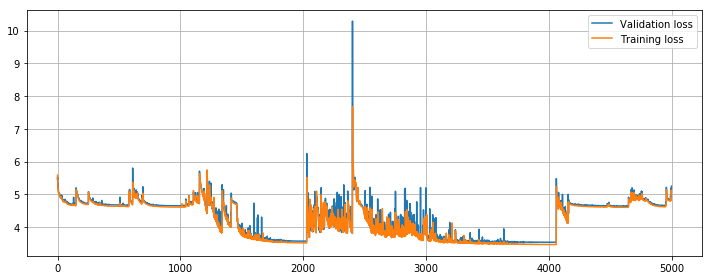

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()
plt.tight_layout()

In [18]:
autoencoder.load_weights(weight_path)

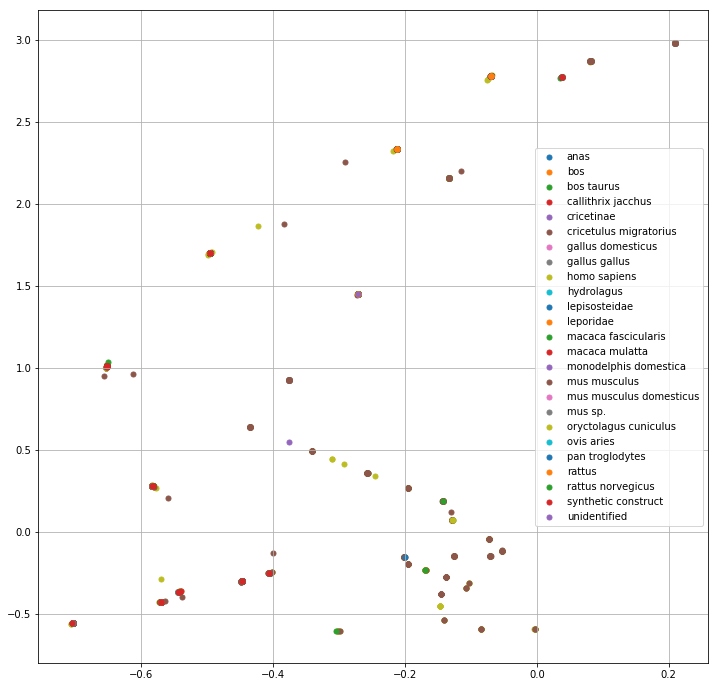

In [19]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals_mask)
labels = le.transform(animals_mask)

unique_labels = np.unique(labels)
len(unique_labels)

c=sns.color_palette(n_colors=25)

f,ax = plt.subplots(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    ax.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', c=c[x],label=le.classes_[x], s=100)
ax.legend()
leg = ax.get_legend()
for i, x in enumerate(leg.legendHandles):
    x.set_color(c[i])
ax.grid()

In [20]:
from abpytools import FabCollection, ChainCollection
import pandas as pd

combinations = pd.read_csv('/home/gil/PhD/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

heavy_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/heavy_chains.json')
light_chains = ChainCollection.load_from_json(path='/home/gil/PhD/UCB/CombinationData/AbFiles/light_chains.json')

heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    
    
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

VL_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Light'].values]
VH_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Heavy'].values]

VH_data_encoded = AminoAcidEncoder(max_length=VH_LENGTH).transform(VH_data)
VL_data_encoded = AminoAcidEncoder(max_length=VL_LENGTH).transform(VL_data)

code_1 = encoder.predict([VL_data_encoded, VH_data_encoded])

latent_data = pd.DataFrame(code_1, columns=[f"Latent{x}" for x in range(1, 51)], index=fab_collection.names)

data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

data.dropna(axis=0, inplace=True, subset=[data.columns[0]])

data = data.join(latent_data)

data.head()

Loading in antibody objects


/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list


,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,Latent1,Latent2,Latent3,Latent4,Latent5,Latent6,...,Latent41,Latent42,Latent43,Latent44,Latent45,Latent46,Latent47,Latent48,Latent49,Latent50
P2,64.473820,0.000000,NaN,NaN,-0.570426,-0.427590,-0.058356,0.092394,-0.420388,-0.103383,...,-0.316180,0.292792,0.029051,-0.535013,0.119790,-0.223727,-0.065256,0.145829,0.309501,-0.663079
P3,73.982970,0.130358,NaN,NaN,-0.570167,-0.427334,-0.058094,0.092211,-0.419919,-0.103418,...,-0.316299,0.292471,0.029163,-0.534840,0.119762,-0.223674,-0.065195,0.145836,0.309063,-0.662834
P4,64.326010,0.060344,NaN,NaN,-0.543011,-0.366099,0.184137,0.084789,0.190491,-0.190136,...,-1.025836,-0.044999,0.270109,-0.380868,0.366136,-0.199848,-0.098999,0.248368,-0.260432,-0.722566
P6,74.192370,0.036953,NaN,NaN,-0.652229,1.013766,0.271635,-0.778319,-0.600948,0.221842,...,-1.820792,-0.278611,1.299492,1.186854,2.674422,1.007680,0.522338,0.176291,0.316142,0.231476
P9,72.899025,0.085337,NaN,NaN,-0.495297,1.703097,-0.059270,-0.327558,-0.347372,0.220473,...,-1.356880,-0.075142,0.876866,1.616517,3.962636,1.158232,0.343019,-0.002527,0.475301,0.295264


In [21]:
X = data[[x for x in data.columns if 'Latent' in x]].as_matrix()

/home/gil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [22]:
norm_variance = [np.var(X[:, x])/abs(np.mean(X[:,x])) for x in range(X.shape[1])]

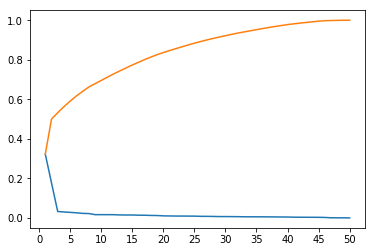

In [23]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=11))

ax.plot(range(1, 51), [norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]])
ax.plot(range(1, 51), np.cumsum([norm_variance[x]/sum(norm_variance) for x in np.argsort(norm_variance)[::-1]]))

In [24]:
X=X[:, np.argsort(norm_variance)[::-1]][:, :20]

/home/gil/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


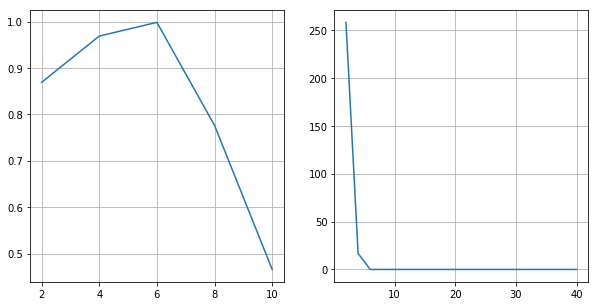

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
f, ax = plt.subplots(1, 2, figsize=(10,5))
# ax[0].xaxis.set_major_locator(MaxNLocator(nbins=11))
# ax[1].xaxis.set_major_locator(MaxNLocator(nbins=11))

s_scores = []
i_scores = []
for k in range(2, 41, 2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    s_scores.append(silhouette_score(X, kmeans.fit_predict(X)))
    i_scores.append(kmeans.inertia_)
ax[0].plot(range(2, 41, 2), s_scores)
ax[1].plot(range(2, 41, 2), i_scores)
ax[0].grid()
ax[1].grid()

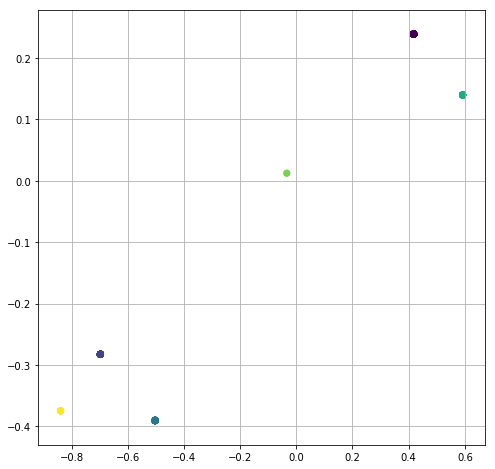

In [29]:
N_CLUSTERS = 6

kmeans = KMeans(N_CLUSTERS, random_state=0)
kmeans.fit(X)
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=kmeans.predict(X))
plt.grid()

/home/gil/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


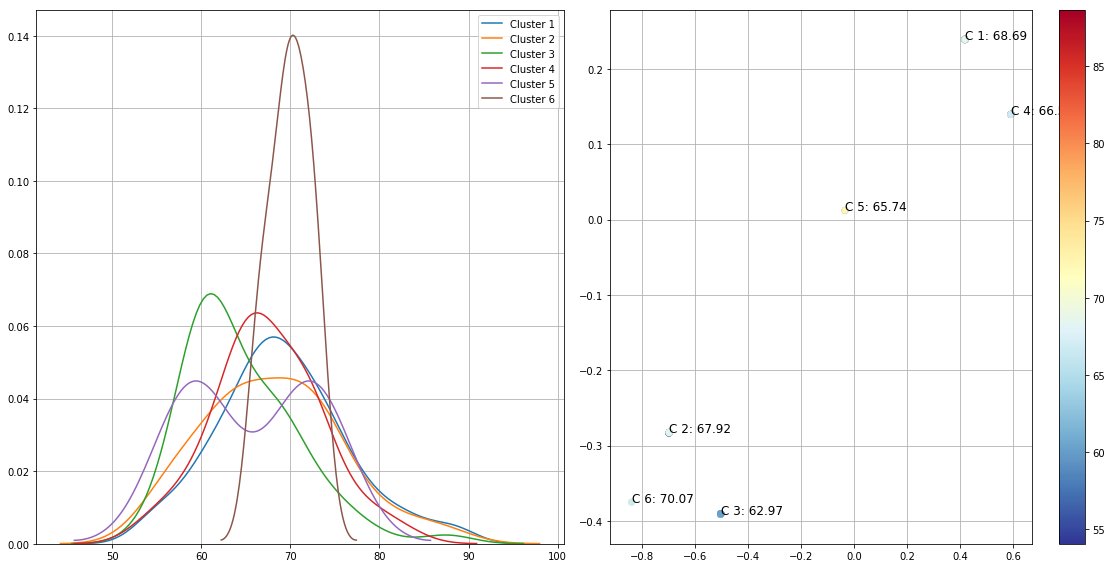

In [34]:
f, ax = plt.subplots(1,2,figsize=(16,8))
kmeans_labels = kmeans.predict(X) 
tms = ax[1].scatter(X[:,0], X[:,1], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
for x in range(N_CLUSTERS):
    ax[1].text(kmeans.cluster_centers_[x][0], kmeans.cluster_centers_[x][1],
               'C {}: {:.2f}'.format(x+1, np.median(data.values[kmeans_labels==x, 0])), fontsize=12)
cbar = f.colorbar(tms)
ax[1].grid()
for x in range(N_CLUSTERS):
    sns.distplot(data.values[kmeans_labels==x, 0], ax=ax[0], hist=False, label='Cluster {}'.format(x+1))
ax[0].legend()
ax[0].grid()
#     print(data.values[kmeans_labels==x, 0].mean(), data.values[kmeans_labels==x, 0].std())
plt.tight_layout()